# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# Importamos los datos

In [4]:
path = '../../../Base de datos/Trayectorias 100 eval'

## Datos de entrenamiento

### Datos

In [5]:
varftrain = np.load(path + '/varftrain.npy')
varftrain = np.transpose(varftrain, (0,3,1,2))

In [6]:
np.shape(varftrain)

(7000, 100, 10, 2)

### Coeficientes

In [7]:
coefvarftrain = np.load(path + '/coefvarftrain.npy')

In [8]:
np.shape(coefvarftrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
varftest = np.load(path + '/varftest.npy')
varftest = np.transpose(varftest, (0,3,1,2))

In [10]:
np.shape(varftest)

(1000, 100, 10, 2)

### Coeficientes

In [11]:
coefvarftest = np.load(path + '/coefvarftest.npy')

In [12]:
np.shape(coefvarftest)

(1000, 7)

## Datos de validación

### Datos

In [13]:
varfval = np.load(path + '/varfval.npy')
varfval = np.transpose(varfval, (0,3,1,2))

In [14]:
np.shape(varfval)

(2000, 100, 10, 2)

### Coeficienes

In [15]:
coefvarfval = np.load(path + '/coefvarfval.npy')

In [16]:
np.shape(coefvarfval)

(2000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((varftrain, coefvarftrain))
test_dataset = tf.data.Dataset.from_tensor_slices((varftest, coefvarftest))
val_dataset = tf.data.Dataset.from_tensor_slices((varfval, coefvarfval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(100, 10, 2), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 100
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [20]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [21]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [22]:
def total_mae_loss(y_true, y_pred):
    total_loss = 0
    num_parameters = 7
    for i in range(num_parameters):
        total_loss += tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])
    tf.print(y_true, summarize = -1)
    tf.print(y_pred, summarize = -1)
    return total_loss / num_parameters

In [23]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [24]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [ ]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l1, l2

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

def objective(trial):
    model = Sequential()
    n_conv_layers = trial.suggest_int("n_conv_layers", 1, 4)
    
    input_shape = (100, 10, 2)  # Tus dimensiones de entrada
    current_shape = input_shape
    
    for i in range(n_conv_layers):
        num_filters = trial.suggest_int(f"num_filters_{i+1}", 8, 64)
        filter_size1 = trial.suggest_int(f"filter_size1_{i+1}", 2, 5)
        filter_size2 = trial.suggest_int(f"filter_size2_{i+1}", 2, 5)
        activation = trial.suggest_categorical(f"activation_{i+1}", ['relu', 'tanh', 'sigmoid'])
        kernel_initializer = trial.suggest_categorical(f"kernel_initializer_{i+1}", ['HeNormal', 'glorot_uniform', 'random_normal'])
        kernel_regularizer = trial.suggest_categorical(f"kernel_regularizer_{i+1}", ['l1', 'l2'])
        
        regularizer = None
        if kernel_regularizer == 'l1':
            regularizer = l1(0.001)
        elif kernel_regularizer == 'l2':
            regularizer = l2(0.001)
            
            
        if (current_shape[0] - filter_size1 + 1 > 0) and (current_shape[1] - filter_size2 + 1 > 0):
            if i == 0:
                model.add(Conv2D(num_filters, (filter_size1, filter_size2), activation=activation, input_shape=input_shape, kernel_initializer=kernel_initializer, kernel_regularizer=regularizer))
            else:
                model.add(Conv2D(num_filters, (filter_size1, filter_size2), activation=activation, kernel_initializer=kernel_initializer, kernel_regularizer=regularizer))
            
            current_shape = (current_shape[0] - filter_size1 + 1, current_shape[1] - filter_size2 + 1, num_filters)
            
        # Decide si agregar una capa de MaxPooling después de esta capa convolucional
        add_maxpooling = trial.suggest_categorical(f"add_maxpooling_after_conv_{i+1}", [True, False])
        if add_maxpooling:
            if current_shape[0] >= 2 and current_shape[1] >= 2:  # Asegurarse de que ambas dimensiones son suficientes para MaxPooling
                model.add(MaxPooling2D(pool_size=(2, 2)))
                current_shape = (current_shape[0] // 2, current_shape[1] // 2, current_shape[2])
        
    model.add(Flatten())
    n_dense_layers = trial.suggest_int("n_dense_layers", 1, 4)
    
    for i in range(n_dense_layers):
        num_units = trial.suggest_int(f"num_units_{i+1}", 16, 128)
        activation = trial.suggest_categorical(f"dense_activation_{i+1}", ['relu', 'tanh', 'sigmoid'])
        kernel_initializer = trial.suggest_categorical(f"dense_kernel_initializer_{i+1}", ['HeNormal', 'glorot_uniform', 'random_normal'])
        kernel_regularizer = trial.suggest_categorical(f"dense_kernel_regularizer_{i+1}", ['l1', 'l2'])

        regularizer = None
        if kernel_regularizer == 'l1':
            regularizer = l1(0.001)
        elif kernel_regularizer == 'l2':
            regularizer = l2(0.001)

        model.add(Dense(num_units, activation=activation, kernel_initializer=kernel_initializer, kernel_regularizer=regularizer))
    
        # Decide si agregar una capa de Dropout después de esta capa densa
        add_dropout = trial.suggest_categorical(f"add_dropout_after_dense_{i+1}", [True, False])
        if add_dropout:
            dropout_rate = trial.suggest_float(f"dropout_rate_after_dense_{i+1}", 0.1, 0.5)
            model.add(Dropout(dropout_rate))
            
    model.add(Dense(7, activation=custom_activation))
    
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)

    optimizer = Adam(learning_rate= learning_rate, clipvalue=100.0)
        
    model.compile(optimizer=optimizer, loss= 'mean_squared_error', metrics=metrics)
    
    history = model.fit(
        train_dataset, 
        validation_data=val_dataset, 
        epochs=20,  
        callbacks=[ early_stop]
    )
    
    val_mean_metric = history.history['val_mean_metric'][-1]
    
    return val_mean_metric

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=300)

print(f'Número de trials finalizados: {len(study.trials)}')
print(f'Mejor trial:')
trial = study.best_trial

print(f'  Valor: {trial.value}')
print('  Parámetros: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2023-10-23 21:34:16,185] A new study created in memory with name: no-name-16a2ca59-c84b-48e5-81e2-36986e91e633


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 10.3829 - a_1: 2.5172 - a_2: 2.5374 - b_1: 2.7578 - b_2: 2.7650 - d_1: 2.7161 - d_2: 2.7363 - n: 2.0179 - mean_metric: 0.5614 - val_loss: 10.2152 - val_a_1: 2.5139 - val_a_2: 2.5253 - val_b_1: 2.7512 - val_b_2: 2.7340 - val_d_1: 2.6409 - val_d_2: 2.7664 - val_n: 1.9402 - val_mean_metric: 0.5535
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 10.1951 - a_1: 2.5150 - a_2: 2.5302 - b_1: 2.7414 - b_2: 2.7434 - d_1: 2.6810 - d_2: 2.7050 - n: 1.9382 - mean_metric: 0.5553 - val_loss: 10.0579 - val_a_1: 2.5176 - val_a_2: 2.5188 - val_b_1: 2.7338 - val_b_2: 2.7149 - val_d_1: 2.6149 - val_d_2: 2.7285 - val_n: 1.8855 - val_mean_metric: 0.5487
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 10.0637 - a_1: 2.5223 - a_2: 2.5275 - b_1: 2.7238 - b_2: 2.7260 - d_1: 2.6493 - d_2: 2.6737 - n: 1.8912 - mean_metric: 0.5509 - val_loss: 9.9120 - val_a_1: 2.5206 - val_a_2: 2.5170 - val_b_

[I 2023-10-23 21:34:36,155] Trial 0 finished with value: 0.4967021346092224 and parameters: {'n_conv_layers': 3, 'num_filters_1': 35, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 41, 'filter_size1_2': 5, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 43, 'filter_size1_3': 3, 'filter_size2_3': 5, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 3, 'num_units_1': 38, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 23, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regul

Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 17.3258 - a_1: 2.7180 - a_2: 2.7814 - b_1: 2.9095 - b_2: 2.9939 - d_1: 2.6480 - d_2: 2.8230 - n: 2.1014 - mean_metric: 0.5906 - val_loss: 12.5305 - val_a_1: 2.5015 - val_a_2: 2.5177 - val_b_1: 2.6553 - val_b_2: 2.5995 - val_d_1: 2.2721 - val_d_2: 2.4008 - val_n: 1.2845 - val_mean_metric: 0.5028
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 12.5273 - a_1: 2.5735 - a_2: 2.6106 - b_1: 2.7442 - b_2: 2.7800 - d_1: 2.3352 - d_2: 2.5422 - n: 1.4476 - mean_metric: 0.5299 - val_loss: 10.4994 - val_a_1: 2.4713 - val_a_2: 2.5056 - val_b_1: 2.5745 - val_b_2: 2.6581 - val_d_1: 2.1117 - val_d_2: 2.4707 - val_n: 1.2379 - val_mean_metric: 0.4965
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 10.3169 - a_1: 2.4943 - a_2: 2.5292 - b_1: 2.5517 - b_2: 2.7614 - d_1: 2.0530 - d_2: 2.6160 - n: 1.3005 - mean_metric: 0.5073 - val_loss: 9.3861 - val_a_1: 2.4844 - val_a_2: 2.5198 - val_b_

[I 2023-10-23 21:34:51,944] Trial 1 finished with value: 0.29133111238479614 and parameters: {'n_conv_layers': 4, 'num_filters_1': 56, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 12, 'filter_size1_2': 4, 'filter_size2_2': 2, 'activation_2': 'tanh', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 21, 'filter_size1_3': 5, 'filter_size2_3': 4, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 62, 'filter_size1_4': 5, 'filter_size2_4': 5, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'random_normal', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': False, 'n_dense_layers': 1, 'num_units_1': 104, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 7.5183 - a_1: 2.4900 - a_2: 2.5087 - b_1: 2.4419 - b_2: 2.4809 - d_1: 1.7816 - d_2: 1.9899 - n: 1.3167 - mean_metric: 0.4671 - val_loss: 6.7998 - val_a_1: 2.4791 - val_a_2: 2.4873 - val_b_1: 2.3309 - val_b_2: 2.2752 - val_d_1: 1.5982 - val_d_2: 1.7924 - val_n: 1.2380 - val_mean_metric: 0.4399
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.5672 - a_1: 2.4607 - a_2: 2.4752 - b_1: 2.2877 - b_2: 2.2005 - d_1: 1.5267 - d_2: 1.6545 - n: 1.2549 - mean_metric: 0.4312 - val_loss: 6.2493 - val_a_1: 2.4699 - val_a_2: 2.4667 - val_b_1: 2.2106 - val_b_2: 2.0523 - val_d_1: 1.4620 - val_d_2: 1.5518 - val_n: 1.2279 - val_mean_metric: 0.4163
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.1114 - a_1: 2.4471 - a_2: 2.4525 - b_1: 2.1770 - b_2: 2.0118 - d_1: 1.4277 - d_2: 1.4671 - n: 1.2470 - mean_metric: 0.4116 - val_loss: 5.8979 - val_a_1: 2.4558 - val_a_2: 2.4534 - val_b_1: 2.10

[I 2023-10-23 21:35:05,727] Trial 2 finished with value: 0.31226637959480286 and parameters: {'n_conv_layers': 4, 'num_filters_1': 51, 'filter_size1_1': 2, 'filter_size2_1': 2, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 41, 'filter_size1_2': 2, 'filter_size2_2': 3, 'activation_2': 'tanh', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 45, 'filter_size1_3': 4, 'filter_size2_3': 5, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 12, 'filter_size1_4': 5, 'filter_size2_4': 3, 'activation_4': 'relu', 'kernel_initializer_4': 'random_normal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 1, 'num_units_1': 21, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glor

Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 8.6782 - a_1: 2.4951 - a_2: 2.5234 - b_1: 2.7179 - b_2: 2.7425 - d_1: 2.4492 - d_2: 2.6076 - n: 1.8145 - mean_metric: 0.5398 - val_loss: 8.1653 - val_a_1: 2.4968 - val_a_2: 2.5550 - val_b_1: 2.7004 - val_b_2: 2.7305 - val_d_1: 2.1415 - val_d_2: 2.4982 - val_n: 1.6338 - val_mean_metric: 0.5190
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 8.1152 - a_1: 2.4902 - a_2: 2.5436 - b_1: 2.6884 - b_2: 2.7168 - d_1: 2.1713 - d_2: 2.3807 - n: 1.6791 - mean_metric: 0.5186 - val_loss: 7.7788 - val_a_1: 2.4902 - val_a_2: 2.5707 - val_b_1: 2.6676 - val_b_2: 2.7081 - val_d_1: 1.9426 - val_d_2: 2.3182 - val_n: 1.5586 - val_mean_metric: 0.5035
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 7.8379 - a_1: 2.4822 - a_2: 2.5535 - b_1: 2.6497 - b_2: 2.6916 - d_1: 2.0539 - d_2: 2.2496 - n: 1.6254 - mean_metric: 0.5072 - val_loss: 7.5031 - val_a_1: 2.4789 - val_a_2: 2.5720 - val_b_1: 2.62

[I 2023-10-23 21:35:18,940] Trial 3 finished with value: 0.41135382652282715 and parameters: {'n_conv_layers': 3, 'num_filters_1': 18, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 13, 'filter_size1_2': 4, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 64, 'filter_size1_3': 3, 'filter_size2_3': 2, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 3, 'num_units_1': 38, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.2532421082780053, 'num_units_2': 27, 'dense_activation_2': 'relu', 'dense_kernel_init

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 10.2943 - a_1: 2.5133 - a_2: 2.5528 - b_1: 2.7859 - b_2: 2.7997 - d_1: 2.7480 - d_2: 2.7723 - n: 1.3229 - mean_metric: 0.5442 - val_loss: 9.4895 - val_a_1: 2.4998 - val_a_2: 2.5250 - val_b_1: 2.7876 - val_b_2: 2.7471 - val_d_1: 2.7064 - val_d_2: 2.7966 - val_n: 1.2113 - val_mean_metric: 0.5350
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 9.1676 - a_1: 2.5078 - a_2: 2.5248 - b_1: 2.7747 - b_2: 2.7659 - d_1: 2.7286 - d_2: 2.7300 - n: 1.2371 - mean_metric: 0.5372 - val_loss: 9.0053 - val_a_1: 2.5020 - val_a_2: 2.5141 - val_b_1: 2.7854 - val_b_2: 2.7407 - val_d_1: 2.7144 - val_d_2: 2.7956 - val_n: 1.2080 - val_mean_metric: 0.5346
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 8.9294 - a_1: 2.5032 - a_2: 2.5146 - b_1: 2.7797 - b_2: 2.7618 - d_1: 2.7340 - d_2: 2.7326 - n: 1.2374 - mean_metric: 0.5369 - val_loss: 8.8666 - val_a_1: 2.5089 - val_a_2: 2.5148 - val_b_1: 2.7

[I 2023-10-23 21:35:32,618] Trial 4 finished with value: 0.5333236455917358 and parameters: {'n_conv_layers': 4, 'num_filters_1': 46, 'filter_size1_1': 2, 'filter_size2_1': 2, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 13, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 53, 'filter_size1_3': 5, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 27, 'filter_size1_4': 4, 'filter_size2_4': 3, 'activation_4': 'relu', 'kernel_initializer_4': 'random_normal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 3, 'num_units_1': 65, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_norm

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 15.1951 - a_1: 2.7549 - a_2: 2.7295 - b_1: 2.9618 - b_2: 2.8800 - d_1: 2.8043 - d_2: 2.7220 - n: 1.8836 - mean_metric: 0.5830 - val_loss: 11.8648 - val_a_1: 2.5001 - val_a_2: 2.5689 - val_b_1: 2.6675 - val_b_2: 2.5216 - val_d_1: 2.0944 - val_d_2: 1.9403 - val_n: 1.3692 - val_mean_metric: 0.4851
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 13.7447 - a_1: 2.6655 - a_2: 2.7023 - b_1: 2.8125 - b_2: 2.7658 - d_1: 2.4561 - d_2: 2.3663 - n: 1.6503 - mean_metric: 0.5418 - val_loss: 11.4363 - val_a_1: 2.4539 - val_a_2: 2.5260 - val_b_1: 2.5365 - val_b_2: 2.4701 - val_d_1: 2.0041 - val_d_2: 1.8126 - val_n: 1.4345 - val_mean_metric: 0.4720
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 13.0485 - a_1: 2.6051 - a_2: 2.6626 - b_1: 2.7330 - b_2: 2.6850 - d_1: 2.2962 - d_2: 2.2171 - n: 1.5825 - mean_metric: 0.5220 - val_loss: 11.0226 - val_a_1: 2.4455 - val_a_2: 2.5060 - val_b_

[I 2023-10-23 21:35:46,991] Trial 5 finished with value: 0.36668819189071655 and parameters: {'n_conv_layers': 2, 'num_filters_1': 29, 'filter_size1_1': 2, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 22, 'filter_size1_2': 5, 'filter_size2_2': 2, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 3, 'num_units_1': 29, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.20669787294443576, 'num_units_2': 126, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.4519759156185814, 'num_units_3': 101, 'dense_activation_3': 'ta

Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 11.1007 - a_1: 2.5183 - a_2: 2.5050 - b_1: 2.7550 - b_2: 2.7444 - d_1: 2.7167 - d_2: 2.7405 - n: 1.7298 - mean_metric: 0.5509 - val_loss: 10.4552 - val_a_1: 2.5106 - val_a_2: 2.5118 - val_b_1: 2.7714 - val_b_2: 2.7355 - val_d_1: 2.6656 - val_d_2: 2.8031 - val_n: 1.4240 - val_mean_metric: 0.5396
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 9.9886 - a_1: 2.5071 - a_2: 2.5045 - b_1: 2.7640 - b_2: 2.7460 - d_1: 2.7130 - d_2: 2.7497 - n: 1.3630 - mean_metric: 0.5395 - val_loss: 9.6163 - val_a_1: 2.5095 - val_a_2: 2.5143 - val_b_1: 2.7782 - val_b_2: 2.7389 - val_d_1: 2.6687 - val_d_2: 2.7964 - val_n: 1.2832 - val_mean_metric: 0.5355
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 9.3221 - a_1: 2.5064 - a_2: 2.5066 - b_1: 2.7610 - b_2: 2.7482 - d_1: 2.7150 - d_2: 2.7396 - n: 1.2759 - mean_metric: 0.5366 - val_loss: 9.1065 - val_a_1: 2.5085 - val_a_2: 2.5156 - val_b_1: 

[I 2023-10-23 21:36:05,287] Trial 6 finished with value: 0.5303703546524048 and parameters: {'n_conv_layers': 4, 'num_filters_1': 56, 'filter_size1_1': 2, 'filter_size2_1': 4, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 46, 'filter_size1_2': 3, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 25, 'filter_size1_3': 3, 'filter_size2_3': 5, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 37, 'filter_size1_4': 3, 'filter_size2_4': 5, 'activation_4': 'relu', 'kernel_initializer_4': 'random_normal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'n_dense_layers': 4, 'num_units_1': 43, 'dense_activation_1': 'sigmoid', 'dense_kernel_initialize

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 13.0804 - a_1: 2.5847 - a_2: 2.6670 - b_1: 2.7456 - b_2: 2.6405 - d_1: 2.2874 - d_2: 2.3881 - n: 1.4148 - mean_metric: 0.5205 - val_loss: 10.0128 - val_a_1: 2.4678 - val_a_2: 2.4595 - val_b_1: 2.4703 - val_b_2: 2.2207 - val_d_1: 1.7626 - val_d_2: 1.8350 - val_n: 1.1911 - val_mean_metric: 0.4462
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 10.5338 - a_1: 2.5202 - a_2: 2.5426 - b_1: 2.5523 - b_2: 2.4213 - d_1: 1.8614 - d_2: 1.9513 - n: 1.3107 - mean_metric: 0.4716 - val_loss: 9.1817 - val_a_1: 2.4620 - val_a_2: 2.4620 - val_b_1: 2.3639 - val_b_2: 2.2576 - val_d_1: 1.5259 - val_d_2: 1.5719 - val_n: 1.1976 - val_mean_metric: 0.4287
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 9.7270 - a_1: 2.5063 - a_2: 2.5005 - b_1: 2.4431 - b_2: 2.3981 - d_1: 1.7483 - d_2: 1.7530 - n: 1.3183 - mean_metric: 0.4563 - val_loss: 8.6820 - val_a_1: 2.4481 - val_a_2: 2.4648 - val_b_1: 2

[I 2023-10-23 21:36:18,955] Trial 7 finished with value: 0.32468175888061523 and parameters: {'n_conv_layers': 1, 'num_filters_1': 13, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'n_dense_layers': 4, 'num_units_1': 61, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 93, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.3703229888674274, 'num_units_3': 81, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.22588851176804076, 'num_units_4': 90, 'dense_activation_4': 'tanh', 'dense_kernel_initializer_4':

Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 26.5039 - a_1: 2.8031 - a_2: 4.4329 - b_1: 3.2543 - b_2: 4.9077 - d_1: 4.8165 - d_2: 4.2265 - n: 3.0532 - mean_metric: 0.8555 - val_loss: 24.2320 - val_a_1: 2.5038 - val_a_2: 4.5185 - val_b_1: 2.8558 - val_b_2: 4.9030 - val_d_1: 4.9595 - val_d_2: 3.9333 - val_n: 3.0020 - val_mean_metric: 0.8265
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 25.1167 - a_1: 3.1460 - a_2: 4.5039 - b_1: 3.5506 - b_2: 4.9943 - d_1: 4.9073 - d_2: 3.6511 - n: 3.0013 - mean_metric: 0.8631 - val_loss: 31.5715 - val_a_1: 4.4935 - val_a_2: 4.5185 - val_b_1: 4.9965 - val_b_2: 4.9030 - val_d_1: 4.9591 - val_d_2: 4.9385 - val_n: 3.0020 - val_mean_metric: 0.9857
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 32.1109 - a_1: 4.3575 - a_2: 4.5039 - b_1: 4.9836 - b_2: 5.0328 - d_1: 4.9910 - d_2: 4.6068 - n: 3.0013 - mean_metric: 0.9794 - val_loss: 31.0200 - val_a_1: 2.5317 - val_a_2: 4.5185 - val_b

[I 2023-10-23 21:36:35,651] Trial 8 finished with value: 1.0503520965576172 and parameters: {'n_conv_layers': 4, 'num_filters_1': 47, 'filter_size1_1': 4, 'filter_size2_1': 4, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 33, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 17, 'filter_size1_3': 5, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 52, 'filter_size1_4': 3, 'filter_size2_4': 3, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'random_normal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 4, 'num_units_1': 123, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 10.1539 - a_1: 2.5046 - a_2: 2.5357 - b_1: 2.7286 - b_2: 2.5251 - d_1: 3.5893 - d_2: 2.0506 - n: 1.2423 - mean_metric: 0.5345 - val_loss: 8.0485 - val_a_1: 2.4721 - val_a_2: 2.4757 - val_b_1: 2.6806 - val_b_2: 2.4140 - val_d_1: 2.4488 - val_d_2: 1.8364 - val_n: 1.1975 - val_mean_metric: 0.4809
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.4534 - a_1: 2.4690 - a_2: 2.4650 - b_1: 2.6356 - b_2: 2.3687 - d_1: 2.1119 - d_2: 1.7519 - n: 1.2339 - mean_metric: 0.4678 - val_loss: 6.9078 - val_a_1: 2.4469 - val_a_2: 2.4707 - val_b_1: 2.5479 - val_b_2: 2.3252 - val_d_1: 1.8683 - val_d_2: 1.6039 - val_n: 1.1977 - val_mean_metric: 0.4479
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.9371 - a_1: 2.4540 - a_2: 2.4729 - b_1: 2.4905 - b_2: 2.3388 - d_1: 1.8211 - d_2: 1.6694 - n: 1.2357 - mean_metric: 0.4505 - val_loss: 6.7385 - val_a_1: 2.4736 - val_a_2: 2.4659 - val_b_1: 2

[I 2023-10-23 21:36:51,021] Trial 9 finished with value: 0.40916183590888977 and parameters: {'n_conv_layers': 3, 'num_filters_1': 48, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 64, 'filter_size1_2': 4, 'filter_size2_2': 5, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 36, 'filter_size1_3': 4, 'filter_size2_3': 2, 'activation_3': 'tanh', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 1, 'num_units_1': 98, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'learning_rate': 0.007020880007412783}. Best is trial 1 with value: 0.29133111238479614.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 13.5720 - a_1: 2.5182 - a_2: 2.5199 - b_1: 2.5878 - b_2: 2.5956 - d_1: 2.0887 - d_2: 2.0911 - n: 1.3013 - mean_metric: 0.4886 - val_loss: 8.1049 - val_a_1: 2.4538 - val_a_2: 2.4689 - val_b_1: 2.2831 - val_b_2: 2.3053 - val_d_1: 1.4922 - val_d_2: 1.5421 - val_n: 1.2051 - val_mean_metric: 0.4259
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.3133 - a_1: 2.4770 - a_2: 2.4814 - b_1: 2.2099 - b_2: 2.2362 - d_1: 1.4551 - d_2: 1.5466 - n: 1.2631 - mean_metric: 0.4253 - val_loss: 6.2604 - val_a_1: 2.4400 - val_a_2: 2.4462 - val_b_1: 2.0129 - val_b_2: 1.9920 - val_d_1: 1.0518 - val_d_2: 1.3540 - val_n: 1.1916 - val_mean_metric: 0.3868
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.1183 - a_1: 2.4542 - a_2: 2.4641 - b_1: 1.9897 - b_2: 1.8345 - d_1: 1.2027 - d_2: 1.2245 - n: 1.2562 - mean_metric: 0.3866 - val_loss: 5.4629 - val_a_1: 2.4189 - val_a_2: 2.4461 - val_b_1: 1

[I 2023-10-23 21:37:06,970] Trial 10 finished with value: 0.2984350025653839 and parameters: {'n_conv_layers': 2, 'num_filters_1': 63, 'filter_size1_1': 4, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 25, 'filter_size1_2': 3, 'filter_size2_2': 2, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 95, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.357459187647155, 'num_units_2': 127, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.10550582511103498, 'learning_rate': 0.00394113661179648

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 12.3878 - a_1: 2.5228 - a_2: 2.5373 - b_1: 2.6681 - b_2: 2.6139 - d_1: 2.3379 - d_2: 2.2660 - n: 1.3139 - mean_metric: 0.5059 - val_loss: 7.9477 - val_a_1: 2.4561 - val_a_2: 2.4717 - val_b_1: 2.4830 - val_b_2: 2.3917 - val_d_1: 1.7548 - val_d_2: 1.6066 - val_n: 1.1955 - val_mean_metric: 0.4448
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.2672 - a_1: 2.4717 - a_2: 2.4851 - b_1: 2.3189 - b_2: 2.2769 - d_1: 1.5934 - d_2: 1.5233 - n: 1.2644 - mean_metric: 0.4335 - val_loss: 6.1234 - val_a_1: 2.4339 - val_a_2: 2.4463 - val_b_1: 2.1326 - val_b_2: 2.0041 - val_d_1: 1.2688 - val_d_2: 1.1382 - val_n: 1.2067 - val_mean_metric: 0.3912
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.3789 - a_1: 2.4550 - a_2: 2.4611 - b_1: 2.1435 - b_2: 2.0548 - d_1: 1.3803 - d_2: 1.2154 - n: 1.2601 - mean_metric: 0.4034 - val_loss: 5.7218 - val_a_1: 2.4206 - val_a_2: 2.4517 - val_b_1: 1

[I 2023-10-23 21:37:22,152] Trial 11 finished with value: 0.29281628131866455 and parameters: {'n_conv_layers': 2, 'num_filters_1': 63, 'filter_size1_1': 4, 'filter_size2_1': 5, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 27, 'filter_size1_2': 3, 'filter_size2_2': 2, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 97, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.35041225255689484, 'num_units_2': 123, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.10396768117769961, 'learning_rate': 0.00406991735038

Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 22.5822 - a_1: 2.5413 - a_2: 2.5383 - b_1: 2.6498 - b_2: 2.6196 - d_1: 2.1377 - d_2: 2.1710 - n: 1.3147 - mean_metric: 0.4969 - val_loss: 11.3519 - val_a_1: 2.4576 - val_a_2: 2.4936 - val_b_1: 2.5770 - val_b_2: 2.4378 - val_d_1: 1.6637 - val_d_2: 1.8464 - val_n: 1.1859 - val_mean_metric: 0.4542
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 10.2763 - a_1: 2.5074 - a_2: 2.5189 - b_1: 2.5340 - b_2: 2.5078 - d_1: 1.7829 - d_2: 1.8433 - n: 1.2803 - mean_metric: 0.4659 - val_loss: 9.1408 - val_a_1: 2.4683 - val_a_2: 2.4655 - val_b_1: 2.5082 - val_b_2: 2.3874 - val_d_1: 1.5400 - val_d_2: 1.6101 - val_n: 1.2253 - val_mean_metric: 0.4400
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 9.4622 - a_1: 2.5015 - a_2: 2.4908 - b_1: 2.4857 - b_2: 2.4469 - d_1: 1.7068 - d_2: 1.7297 - n: 1.2569 - mean_metric: 0.4548 - val_loss: 8.5713 - val_a_1: 2.4805 - val_a_2: 2.4826 - val_b_1:

[I 2023-10-23 21:37:37,332] Trial 12 finished with value: 0.37158799171447754 and parameters: {'n_conv_layers': 1, 'num_filters_1': 64, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'n_dense_layers': 2, 'num_units_1': 98, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.3276587776273893, 'num_units_2': 99, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.10549897397172604, 'learning_rate': 0.0034434616460529976}. Best is trial 1 with value: 0.29133111238479614.


Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 16.7224 - a_1: 3.0809 - a_2: 2.8437 - b_1: 2.8502 - b_2: 2.9230 - d_1: 2.4838 - d_2: 3.0319 - n: 1.9504 - mean_metric: 0.5965 - val_loss: 11.4629 - val_a_1: 2.4898 - val_a_2: 2.5164 - val_b_1: 2.7321 - val_b_2: 2.6392 - val_d_1: 2.3415 - val_d_2: 2.6290 - val_n: 1.2056 - val_mean_metric: 0.5127
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 9.7797 - a_1: 2.4731 - a_2: 2.5116 - b_1: 2.6773 - b_2: 2.6326 - d_1: 2.1013 - d_2: 2.4721 - n: 1.2445 - mean_metric: 0.5012 - val_loss: 8.5721 - val_a_1: 2.4461 - val_a_2: 2.5134 - val_b_1: 2.6157 - val_b_2: 2.6298 - val_d_1: 1.9863 - val_d_2: 2.3947 - val_n: 1.2153 - val_mean_metric: 0.4895
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 8.1078 - a_1: 2.4628 - a_2: 2.5193 - b_1: 2.6576 - b_2: 2.6127 - d_1: 2.1026 - d_2: 2.1435 - n: 1.2419 - mean_metric: 0.4896 - val_loss: 7.2889 - val_a_1: 2.4396 - val_a_2: 2.5103 - val_b_1: 2.

[I 2023-10-23 21:37:51,224] Trial 13 finished with value: 0.402763307094574 and parameters: {'n_conv_layers': 2, 'num_filters_1': 58, 'filter_size1_1': 4, 'filter_size2_1': 5, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 10, 'filter_size1_2': 3, 'filter_size2_2': 2, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 1, 'num_units_1': 115, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.34592109346497846, 'learning_rate': 0.013240970267983081}. Best is trial 1 with value: 0.29133111238479614.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.1357 - a_1: 2.5147 - a_2: 2.5326 - b_1: 2.7209 - b_2: 2.7668 - d_1: 2.3277 - d_2: 2.3142 - n: 1.3866 - mean_metric: 0.5154 - val_loss: 8.6452 - val_a_1: 2.4643 - val_a_2: 2.4783 - val_b_1: 2.4141 - val_b_2: 2.4869 - val_d_1: 1.7814 - val_d_2: 1.6246 - val_n: 1.2251 - val_mean_metric: 0.4483
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.2425 - a_1: 2.4674 - a_2: 2.4973 - b_1: 2.3644 - b_2: 2.3828 - d_1: 1.7162 - d_2: 1.6607 - n: 1.3070 - mean_metric: 0.4479 - val_loss: 7.0849 - val_a_1: 2.4454 - val_a_2: 2.4645 - val_b_1: 2.2049 - val_b_2: 2.1460 - val_d_1: 1.4904 - val_d_2: 1.4649 - val_n: 1.2002 - val_mean_metric: 0.4156
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 7.1136 - a_1: 2.4683 - a_2: 2.4678 - b_1: 2.2171 - b_2: 2.1955 - d_1: 1.5481 - d_2: 1.5726 - n: 1.2922 - mean_metric: 0.4281 - val_loss: 6.3959 - val_a_1: 2.4421 - val_a_2: 2.4571 - val_b_1: 2.

[I 2023-10-23 21:38:05,554] Trial 14 finished with value: 0.3055765628814697 and parameters: {'n_conv_layers': 2, 'num_filters_1': 40, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 24, 'filter_size1_2': 4, 'filter_size2_2': 3, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 82, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.2691832250055219, 'num_units_2': 66, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.22794698192320442, 'learning_rate': 0.00136271758287

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 25.5486 - a_1: 2.9271 - a_2: 2.6785 - b_1: 3.0323 - b_2: 3.1291 - d_1: 3.2649 - d_2: 3.1480 - n: 1.6204 - mean_metric: 0.6163 - val_loss: 16.8129 - val_a_1: 2.6041 - val_a_2: 2.5109 - val_b_1: 2.6856 - val_b_2: 2.7242 - val_d_1: 2.4867 - val_d_2: 2.5292 - val_n: 1.2477 - val_mean_metric: 0.5200
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 13.6824 - a_1: 2.5477 - a_2: 2.5268 - b_1: 2.6439 - b_2: 2.6541 - d_1: 2.4112 - d_2: 2.4023 - n: 1.2732 - mean_metric: 0.5121 - val_loss: 10.9403 - val_a_1: 2.4677 - val_a_2: 2.5740 - val_b_1: 2.6107 - val_b_2: 2.5416 - val_d_1: 2.1932 - val_d_2: 2.2389 - val_n: 1.2225 - val_mean_metric: 0.4909
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 10.4517 - a_1: 2.5266 - a_2: 2.5310 - b_1: 2.6187 - b_2: 2.5741 - d_1: 2.2791 - d_2: 2.2746 - n: 1.2811 - mean_metric: 0.5004 - val_loss: 9.8589 - val_a_1: 2.4685 - val_a_2: 2.4875 - val_b_1:

[I 2023-10-23 21:38:19,909] Trial 15 finished with value: 0.36718013882637024 and parameters: {'n_conv_layers': 3, 'num_filters_1': 55, 'filter_size1_1': 4, 'filter_size2_1': 5, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 31, 'filter_size1_2': 3, 'filter_size2_2': 2, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 9, 'filter_size1_3': 2, 'filter_size2_3': 4, 'activation_3': 'relu', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 1, 'num_units_1': 107, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.40238443740667407, 'learning_rate': 0.015720207477387543}. Best is trial 1 with valu

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.8505 - a_1: 2.5612 - a_2: 2.5565 - b_1: 2.6917 - b_2: 2.6801 - d_1: 2.1870 - d_2: 2.2184 - n: 1.3677 - mean_metric: 0.5061 - val_loss: 7.7295 - val_a_1: 2.4518 - val_a_2: 2.4877 - val_b_1: 2.4793 - val_b_2: 2.4822 - val_d_1: 1.6959 - val_d_2: 1.6256 - val_n: 1.1920 - val_mean_metric: 0.4465
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.5828 - a_1: 2.4949 - a_2: 2.5080 - b_1: 2.4957 - b_2: 2.4880 - d_1: 1.7422 - d_2: 1.7110 - n: 1.2969 - mean_metric: 0.4584 - val_loss: 6.5932 - val_a_1: 2.4618 - val_a_2: 2.4791 - val_b_1: 2.3894 - val_b_2: 2.3520 - val_d_1: 1.4871 - val_d_2: 1.4661 - val_n: 1.2071 - val_mean_metric: 0.4288
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.8583 - a_1: 2.4803 - a_2: 2.5040 - b_1: 2.4274 - b_2: 2.3768 - d_1: 1.6006 - d_2: 1.5526 - n: 1.2832 - mean_metric: 0.4425 - val_loss: 6.2478 - val_a_1: 2.4599 - val_a_2: 2.4786 - val_b_1: 2

[I 2023-10-23 21:38:34,172] Trial 16 finished with value: 0.3173832595348358 and parameters: {'n_conv_layers': 1, 'num_filters_1': 39, 'filter_size1_1': 3, 'filter_size2_1': 4, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'n_dense_layers': 2, 'num_units_1': 79, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.26789925315211377, 'num_units_2': 107, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2549470736084731, 'learning_rate': 0.0014596882408431883}. Best is trial 1 with value: 0.29133111238479614.


Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 14.0181 - a_1: 2.7323 - a_2: 2.7041 - b_1: 2.9004 - b_2: 3.0007 - d_1: 2.9568 - d_2: 2.9177 - n: 1.4606 - mean_metric: 0.5815 - val_loss: 11.0556 - val_a_1: 2.5060 - val_a_2: 2.5140 - val_b_1: 2.7574 - val_b_2: 2.7384 - val_d_1: 2.6887 - val_d_2: 2.7577 - val_n: 1.1979 - val_mean_metric: 0.5315
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 10.1524 - a_1: 2.5060 - a_2: 2.5075 - b_1: 2.7476 - b_2: 2.7480 - d_1: 2.7180 - d_2: 2.7181 - n: 1.2186 - mean_metric: 0.5338 - val_loss: 9.5343 - val_a_1: 2.5050 - val_a_2: 2.5148 - val_b_1: 2.7578 - val_b_2: 2.7351 - val_d_1: 2.6864 - val_d_2: 2.7580 - val_n: 1.1885 - val_mean_metric: 0.5310
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 9.1771 - a_1: 2.5061 - a_2: 2.5073 - b_1: 2.7477 - b_2: 2.7430 - d_1: 2.7186 - d_2: 2.7191 - n: 1.2084 - mean_metric: 0.5334 - val_loss: 8.9401 - val_a_1: 2.5053 - val_a_2: 2.5146 - val_b_1: 2

[I 2023-10-23 21:38:47,204] Trial 17 finished with value: 0.5312517881393433 and parameters: {'n_conv_layers': 3, 'num_filters_1': 27, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 18, 'filter_size1_2': 4, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 28, 'filter_size1_3': 5, 'filter_size2_3': 4, 'activation_3': 'relu', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 1, 'num_units_1': 84, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4029264027711772, 'learning_rate': 0.028620431641197236}. Best is trial 1 with value:

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 92.9265 - a_1: 5.2117 - a_2: 4.3258 - b_1: 3.0200 - b_2: 3.0561 - d_1: 3.6044 - d_2: 3.0761 - n: 2.8329 - mean_metric: 0.7821 - val_loss: 93.5506 - val_a_1: 2.5069 - val_a_2: 2.5390 - val_b_1: 2.7602 - val_b_2: 2.7394 - val_d_1: 2.6656 - val_d_2: 2.7571 - val_n: 1.3124 - val_mean_metric: 0.5352
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 91.3331 - a_1: 2.5451 - a_2: 2.5389 - b_1: 2.7528 - b_2: 2.7487 - d_1: 2.7198 - d_2: 2.7229 - n: 1.2553 - mean_metric: 0.5377 - val_loss: 86.4276 - val_a_1: 2.5082 - val_a_2: 2.5143 - val_b_1: 2.7654 - val_b_2: 2.7412 - val_d_1: 2.7015 - val_d_2: 2.7748 - val_n: 1.2038 - val_mean_metric: 0.5330
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 95.1364 - a_1: 2.5251 - a_2: 2.5197 - b_1: 2.7508 - b_2: 2.7568 - d_1: 2.7230 - d_2: 2.7219 - n: 1.2439 - mean_metric: 0.5363 - val_loss: 70.5672 - val_a_1: 2.5080 - val_a_2: 2.5167 - val_b

[I 2023-10-23 21:39:02,315] Trial 18 finished with value: 0.5323604941368103 and parameters: {'n_conv_layers': 2, 'num_filters_1': 60, 'filter_size1_1': 4, 'filter_size2_1': 4, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 9, 'filter_size1_2': 2, 'filter_size2_2': 2, 'activation_2': 'tanh', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 128, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.1947218950039005, 'num_units_2': 77, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.19178666927147078, 'learning_rate': 0.09436924920645155}. 

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 36.9581 - a_1: 2.8661 - a_2: 2.8262 - b_1: 2.8396 - b_2: 3.0014 - d_1: 2.4027 - d_2: 2.6479 - n: 1.5311 - mean_metric: 0.5639 - val_loss: 23.3921 - val_a_1: 2.5905 - val_a_2: 2.4767 - val_b_1: 2.6453 - val_b_2: 2.6601 - val_d_1: 2.1991 - val_d_2: 2.2201 - val_n: 1.3478 - val_mean_metric: 0.4999
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 19.0772 - a_1: 2.5927 - a_2: 2.6295 - b_1: 2.6371 - b_2: 2.6999 - d_1: 2.0861 - d_2: 2.0799 - n: 1.4170 - mean_metric: 0.5022 - val_loss: 14.1054 - val_a_1: 2.4855 - val_a_2: 2.4871 - val_b_1: 2.3803 - val_b_2: 2.4912 - val_d_1: 1.8799 - val_d_2: 1.6729 - val_n: 1.2690 - val_mean_metric: 0.4542
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 11.4578 - a_1: 2.5246 - a_2: 2.5226 - b_1: 2.3769 - b_2: 2.3174 - d_1: 1.6959 - d_2: 1.5701 - n: 1.3397 - mean_metric: 0.4464 - val_loss: 8.7163 - val_a_1: 2.4498 - val_a_2: 2.5109 - val_b_

[I 2023-10-23 21:39:17,423] Trial 19 finished with value: 0.30577683448791504 and parameters: {'n_conv_layers': 1, 'num_filters_1': 54, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'n_dense_layers': 1, 'num_units_1': 111, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.11227072509355196, 'learning_rate': 0.006043457659140732}. Best is trial 1 with value: 0.29133111238479614.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.5179 - a_1: 2.5250 - a_2: 2.5184 - b_1: 2.6862 - b_2: 2.6701 - d_1: 2.2941 - d_2: 2.2825 - n: 1.2842 - mean_metric: 0.5060 - val_loss: 8.6769 - val_a_1: 2.4762 - val_a_2: 2.4829 - val_b_1: 2.4785 - val_b_2: 2.4131 - val_d_1: 1.6557 - val_d_2: 1.7039 - val_n: 1.2273 - val_mean_metric: 0.4472
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.9129 - a_1: 2.4679 - a_2: 2.4738 - b_1: 2.3830 - b_2: 2.2797 - d_1: 1.6454 - d_2: 1.6713 - n: 1.2525 - mean_metric: 0.4409 - val_loss: 6.8208 - val_a_1: 2.4488 - val_a_2: 2.4540 - val_b_1: 2.1986 - val_b_2: 2.1340 - val_d_1: 1.4745 - val_d_2: 1.4515 - val_n: 1.2146 - val_mean_metric: 0.4143
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.6733 - a_1: 2.4518 - a_2: 2.4654 - b_1: 2.2417 - b_2: 2.1580 - d_1: 1.5220 - d_2: 1.5290 - n: 1.2338 - mean_metric: 0.4231 - val_loss: 5.9933 - val_a_1: 2.4481 - val_a_2: 2.4516 - val_b_1: 2

[I 2023-10-23 21:39:32,620] Trial 20 finished with value: 0.3002298176288605 and parameters: {'n_conv_layers': 4, 'num_filters_1': 43, 'filter_size1_1': 4, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 59, 'filter_size1_2': 3, 'filter_size2_2': 2, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 14, 'filter_size1_3': 4, 'filter_size2_3': 4, 'activation_3': 'tanh', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 62, 'filter_size1_4': 5, 'filter_size2_4': 5, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': False, 'n_dense_layers': 2, 'num_units_1': 56, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 14.1185 - a_1: 2.5544 - a_2: 2.5412 - b_1: 2.6508 - b_2: 2.6393 - d_1: 2.2290 - d_2: 2.2025 - n: 1.2988 - mean_metric: 0.5014 - val_loss: 8.1866 - val_a_1: 2.4614 - val_a_2: 2.4871 - val_b_1: 2.3848 - val_b_2: 2.3285 - val_d_1: 1.5075 - val_d_2: 1.5464 - val_n: 1.2041 - val_mean_metric: 0.4311
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.4664 - a_1: 2.4746 - a_2: 2.4815 - b_1: 2.3218 - b_2: 2.2577 - d_1: 1.5101 - d_2: 1.6164 - n: 1.2609 - mean_metric: 0.4331 - val_loss: 6.3118 - val_a_1: 2.4557 - val_a_2: 2.4650 - val_b_1: 2.1478 - val_b_2: 2.0748 - val_d_1: 1.2982 - val_d_2: 1.2673 - val_n: 1.1995 - val_mean_metric: 0.3998
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.1687 - a_1: 2.4606 - a_2: 2.4718 - b_1: 2.0300 - b_2: 2.0049 - d_1: 1.2257 - d_2: 1.2448 - n: 1.2522 - mean_metric: 0.3947 - val_loss: 5.4546 - val_a_1: 2.4399 - val_a_2: 2.4661 - val_b_1: 1

[I 2023-10-23 21:39:48,722] Trial 21 finished with value: 0.29207566380500793 and parameters: {'n_conv_layers': 2, 'num_filters_1': 63, 'filter_size1_1': 4, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 26, 'filter_size1_2': 3, 'filter_size2_2': 2, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 94, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.37358798537806326, 'num_units_2': 127, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.10531503920669949, 'learning_rate': 0.00317725154092

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 16.4864 - a_1: 2.5372 - a_2: 2.5614 - b_1: 2.6177 - b_2: 2.6635 - d_1: 2.1474 - d_2: 2.2660 - n: 1.2961 - mean_metric: 0.5006 - val_loss: 10.0846 - val_a_1: 2.4580 - val_a_2: 2.4675 - val_b_1: 2.3381 - val_b_2: 2.3641 - val_d_1: 1.5432 - val_d_2: 1.5283 - val_n: 1.1954 - val_mean_metric: 0.4304
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 8.6627 - a_1: 2.4834 - a_2: 2.5021 - b_1: 2.3265 - b_2: 2.3372 - d_1: 1.6246 - d_2: 1.5862 - n: 1.2800 - mean_metric: 0.4399 - val_loss: 6.9542 - val_a_1: 2.4468 - val_a_2: 2.4654 - val_b_1: 2.1425 - val_b_2: 2.1748 - val_d_1: 1.3739 - val_d_2: 1.4023 - val_n: 1.1936 - val_mean_metric: 0.4089
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.8170 - a_1: 2.4698 - a_2: 2.4881 - b_1: 2.2068 - b_2: 2.1487 - d_1: 1.3882 - d_2: 1.3360 - n: 1.2574 - mean_metric: 0.4136 - val_loss: 5.8490 - val_a_1: 2.4349 - val_a_2: 2.4695 - val_b_1: 

[I 2023-10-23 21:40:04,936] Trial 22 finished with value: 0.29510948061943054 and parameters: {'n_conv_layers': 2, 'num_filters_1': 64, 'filter_size1_1': 3, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 29, 'filter_size1_2': 4, 'filter_size2_2': 2, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 91, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.38090120832772684, 'num_units_2': 118, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.1592187411881547, 'learning_rate': 0.001943606610842

Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 12.2754 - a_1: 2.5224 - a_2: 2.5568 - b_1: 2.6283 - b_2: 2.6863 - d_1: 2.2736 - d_2: 2.2910 - n: 1.3196 - mean_metric: 0.5065 - val_loss: 8.2340 - val_a_1: 2.4668 - val_a_2: 2.4676 - val_b_1: 2.3097 - val_b_2: 2.3859 - val_d_1: 1.6402 - val_d_2: 1.6090 - val_n: 1.2233 - val_mean_metric: 0.4368
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.3599 - a_1: 2.4911 - a_2: 2.4938 - b_1: 2.2268 - b_2: 2.2825 - d_1: 1.5863 - d_2: 1.4711 - n: 1.2714 - mean_metric: 0.4301 - val_loss: 6.2310 - val_a_1: 2.4519 - val_a_2: 2.4447 - val_b_1: 2.0717 - val_b_2: 2.1122 - val_d_1: 1.4125 - val_d_2: 1.1352 - val_n: 1.2182 - val_mean_metric: 0.3979
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 5.8858 - a_1: 2.4626 - a_2: 2.4529 - b_1: 1.9618 - b_2: 1.8534 - d_1: 1.2428 - d_2: 1.1407 - n: 1.2577 - mean_metric: 0.3849 - val_loss: 5.2647 - val_a_1: 2.4384 - val_a_2: 2.4365 - val_b_1: 1

[I 2023-10-23 21:40:21,268] Trial 23 finished with value: 0.2853942811489105 and parameters: {'n_conv_layers': 2, 'num_filters_1': 60, 'filter_size1_1': 4, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 18, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 105, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.30065881268642114, 'num_units_2': 79, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.1552819072661207, 'learning_rate': 0.0029660478919379

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 18.1310 - a_1: 2.9414 - a_2: 2.7684 - b_1: 2.8705 - b_2: 2.9501 - d_1: 2.8581 - d_2: 2.6596 - n: 2.8562 - mean_metric: 0.6195 - val_loss: 11.9366 - val_a_1: 2.4701 - val_a_2: 2.5693 - val_b_1: 2.6292 - val_b_2: 2.6937 - val_d_1: 2.2540 - val_d_2: 2.1214 - val_n: 1.8214 - val_mean_metric: 0.5129
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 10.7807 - a_1: 2.5697 - a_2: 2.5531 - b_1: 2.6241 - b_2: 2.6837 - d_1: 2.0664 - d_2: 2.1129 - n: 1.5178 - mean_metric: 0.5018 - val_loss: 8.4687 - val_a_1: 2.4413 - val_a_2: 2.4981 - val_b_1: 2.4086 - val_b_2: 2.3940 - val_d_1: 1.5326 - val_d_2: 1.7738 - val_n: 1.2329 - val_mean_metric: 0.4423
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.5103 - a_1: 2.4684 - a_2: 2.4825 - b_1: 2.2688 - b_2: 2.2192 - d_1: 1.4665 - d_2: 1.5120 - n: 1.2513 - mean_metric: 0.4253 - val_loss: 6.3998 - val_a_1: 2.4343 - val_a_2: 2.4410 - val_b_1:

[I 2023-10-23 21:40:36,400] Trial 24 finished with value: 0.3016716539859772 and parameters: {'n_conv_layers': 3, 'num_filters_1': 51, 'filter_size1_1': 4, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 18, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 25, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 1, 'num_units_1': 105, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.31093797036899995, 'learning_rate': 0.00878782875574561}. Best is trial 23 with valu

Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 9.6721 - a_1: 2.4990 - a_2: 2.5086 - b_1: 2.6677 - b_2: 2.5889 - d_1: 2.4373 - d_2: 2.3636 - n: 1.3654 - mean_metric: 0.5111 - val_loss: 7.6965 - val_a_1: 2.4602 - val_a_2: 2.4776 - val_b_1: 2.5817 - val_b_2: 2.4276 - val_d_1: 2.2637 - val_d_2: 2.1428 - val_n: 1.2117 - val_mean_metric: 0.4821
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.7392 - a_1: 2.4839 - a_2: 2.4911 - b_1: 2.5624 - b_2: 2.4236 - d_1: 2.4066 - d_2: 2.1247 - n: 1.3163 - mean_metric: 0.4918 - val_loss: 7.0426 - val_a_1: 2.4770 - val_a_2: 2.4797 - val_b_1: 2.4016 - val_b_2: 2.3045 - val_d_1: 2.3467 - val_d_2: 1.8740 - val_n: 1.2044 - val_mean_metric: 0.4673
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 7.0686 - a_1: 2.4854 - a_2: 2.4880 - b_1: 2.3552 - b_2: 2.2680 - d_1: 2.1800 - d_2: 1.9208 - n: 1.2955 - mean_metric: 0.4664 - val_loss: 6.0838 - val_a_1: 2.4588 - val_a_2: 2.4761 - val_b_1: 2.

[I 2023-10-23 21:40:52,794] Trial 25 finished with value: 0.3081151843070984 and parameters: {'n_conv_layers': 2, 'num_filters_1': 60, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 18, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 3, 'num_units_1': 118, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.2948965202219741, 'num_units_2': 47, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.29189827596977613, 'num_units_3': 47, 'dense_activation_3': 

Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 15.4792 - a_1: 2.5748 - a_2: 2.6333 - b_1: 2.7858 - b_2: 2.7862 - d_1: 2.4921 - d_2: 2.4602 - n: 1.5672 - mean_metric: 0.5382 - val_loss: 12.9440 - val_a_1: 2.5068 - val_a_2: 2.5327 - val_b_1: 2.6932 - val_b_2: 2.6782 - val_d_1: 1.9419 - val_d_2: 2.1991 - val_n: 1.2380 - val_mean_metric: 0.4891
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 12.4227 - a_1: 2.5443 - a_2: 2.5429 - b_1: 2.6436 - b_2: 2.6806 - d_1: 1.8416 - d_2: 2.0307 - n: 1.2942 - mean_metric: 0.4846 - val_loss: 11.2209 - val_a_1: 2.4737 - val_a_2: 2.5122 - val_b_1: 2.5973 - val_b_2: 2.5958 - val_d_1: 1.6283 - val_d_2: 1.8178 - val_n: 1.2049 - val_mean_metric: 0.4594
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 11.0702 - a_1: 2.4848 - a_2: 2.5317 - b_1: 2.5799 - b_2: 2.6333 - d_1: 1.6945 - d_2: 1.8302 - n: 1.2714 - mean_metric: 0.4674 - val_loss: 10.3812 - val_a_1: 2.4761 - val_a_2: 2.4918 - val_b

[I 2023-10-23 21:41:09,648] Trial 26 finished with value: 0.4401702880859375 and parameters: {'n_conv_layers': 1, 'num_filters_1': 53, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'n_dense_layers': 2, 'num_units_1': 75, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 82, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.18403381352204123, 'learning_rate': 0.0008376021764213835}. Best is trial 23 with value: 0.2853942811489105.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 18.5084 - a_1: 2.6883 - a_2: 2.9249 - b_1: 3.0141 - b_2: 2.7125 - d_1: 2.5505 - d_2: 2.2903 - n: 1.7986 - mean_metric: 0.5597 - val_loss: 12.4853 - val_a_1: 2.5658 - val_a_2: 2.5973 - val_b_1: 2.5072 - val_b_2: 2.4843 - val_d_1: 1.7123 - val_d_2: 1.7633 - val_n: 1.2347 - val_mean_metric: 0.4605
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 10.7125 - a_1: 2.5180 - a_2: 2.5231 - b_1: 2.4913 - b_2: 2.4539 - d_1: 1.8361 - d_2: 1.8075 - n: 1.2861 - mean_metric: 0.4641 - val_loss: 8.8421 - val_a_1: 2.4507 - val_a_2: 2.4979 - val_b_1: 2.4210 - val_b_2: 2.4301 - val_d_1: 1.6524 - val_d_2: 1.7029 - val_n: 1.1981 - val_mean_metric: 0.4446
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 8.6473 - a_1: 2.4924 - a_2: 2.4942 - b_1: 2.4050 - b_2: 2.3482 - d_1: 1.6736 - d_2: 1.6984 - n: 1.2747 - mean_metric: 0.4475 - val_loss: 7.9236 - val_a_1: 2.4597 - val_a_2: 2.4613 - val_b_1:

[I 2023-10-23 21:41:25,087] Trial 27 finished with value: 0.3689103424549103 and parameters: {'n_conv_layers': 3, 'num_filters_1': 59, 'filter_size1_1': 4, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 20, 'filter_size1_2': 2, 'filter_size2_2': 3, 'activation_2': 'tanh', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 35, 'filter_size1_3': 5, 'filter_size2_3': 4, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 1, 'num_units_1': 90, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.24595425202711776, 'learning_rate': 0.011716447485246535}. Best is trial 23 wit

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 7.5618 - a_1: 2.4763 - a_2: 2.4846 - b_1: 2.3952 - b_2: 2.3194 - d_1: 1.7591 - d_2: 1.7036 - n: 1.3239 - mean_metric: 0.4501 - val_loss: 5.9784 - val_a_1: 2.4354 - val_a_2: 2.4453 - val_b_1: 2.1928 - val_b_2: 1.9618 - val_d_1: 1.4210 - val_d_2: 1.2812 - val_n: 1.2225 - val_mean_metric: 0.4014
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 5.6883 - a_1: 2.4601 - a_2: 2.4445 - b_1: 2.0576 - b_2: 1.8779 - d_1: 1.3759 - d_2: 1.1577 - n: 1.2696 - mean_metric: 0.3933 - val_loss: 4.9011 - val_a_1: 2.4294 - val_a_2: 2.4137 - val_b_1: 1.8749 - val_b_2: 1.6071 - val_d_1: 1.1210 - val_d_2: 0.8982 - val_n: 1.2085 - val_mean_metric: 0.3579
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 4.9809 - a_1: 2.4227 - a_2: 2.4158 - b_1: 1.8200 - b_2: 1.6651 - d_1: 1.1460 - d_2: 1.0231 - n: 1.2501 - mean_metric: 0.3653 - val_loss: 4.5208 - val_a_1: 2.3880 - val_a_2: 2.4141 - val_b_1: 1.70

[I 2023-10-23 21:41:39,318] Trial 28 finished with value: 0.2752625644207001 and parameters: {'n_conv_layers': 2, 'num_filters_1': 33, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 15, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 2, 'num_units_1': 104, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4218333129648007, 'num_units_2': 66, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.1572235724826917, 'learning_rate': 0.002963095189049349}.

Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 7.5184 - a_1: 2.4759 - a_2: 2.5045 - b_1: 2.4351 - b_2: 2.7249 - d_1: 1.8251 - d_2: 2.4017 - n: 1.3381 - mean_metric: 0.4887 - val_loss: 6.1208 - val_a_1: 2.4697 - val_a_2: 2.4567 - val_b_1: 2.2920 - val_b_2: 2.5444 - val_d_1: 1.5182 - val_d_2: 1.5399 - val_n: 1.2207 - val_mean_metric: 0.4349
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 5.9919 - a_1: 2.4516 - a_2: 2.4617 - b_1: 2.1955 - b_2: 2.3639 - d_1: 1.5165 - d_2: 1.5264 - n: 1.2784 - mean_metric: 0.4292 - val_loss: 5.5651 - val_a_1: 2.4408 - val_a_2: 2.4460 - val_b_1: 2.1230 - val_b_2: 2.2470 - val_d_1: 1.3195 - val_d_2: 1.3349 - val_n: 1.2156 - val_mean_metric: 0.4066
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 5.5661 - a_1: 2.4359 - a_2: 2.4594 - b_1: 1.9975 - b_2: 2.2241 - d_1: 1.2633 - d_2: 1.5140 - n: 1.2615 - mean_metric: 0.4093 - val_loss: 5.1935 - val_a_1: 2.4110 - val_a_2: 2.4567 - val_b_1: 1.

[I 2023-10-23 21:41:56,005] Trial 29 finished with value: 0.3194701373577118 and parameters: {'n_conv_layers': 3, 'num_filters_1': 33, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 14, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 18, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 3, 'num_units_1': 104, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 65, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kerne

Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 8.5837 - a_1: 2.5240 - a_2: 2.5564 - b_1: 2.5443 - b_2: 2.5026 - d_1: 1.9213 - d_2: 1.8810 - n: 1.4287 - mean_metric: 0.4780 - val_loss: 6.6875 - val_a_1: 2.4194 - val_a_2: 2.4534 - val_b_1: 2.1920 - val_b_2: 2.1484 - val_d_1: 1.6091 - val_d_2: 1.4808 - val_n: 1.2076 - val_mean_metric: 0.4185
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.7249 - a_1: 2.4274 - a_2: 2.4596 - b_1: 2.1861 - b_2: 2.1549 - d_1: 1.5452 - d_2: 1.5147 - n: 1.3229 - mean_metric: 0.4234 - val_loss: 5.8003 - val_a_1: 2.3824 - val_a_2: 2.4158 - val_b_1: 1.9765 - val_b_2: 1.9851 - val_d_1: 1.2764 - val_d_2: 1.2678 - val_n: 1.2073 - val_mean_metric: 0.3875
Epoch 3/20
70/70 [==============================] - 1s 8ms/step - loss: 5.9484 - a_1: 2.4099 - a_2: 2.4471 - b_1: 1.9753 - b_2: 2.0406 - d_1: 1.2356 - d_2: 1.3255 - n: 1.3011 - mean_metric: 0.3962 - val_loss: 5.3550 - val_a_1: 2.3681 - val_a_2: 2.3941 - val_b_1: 1.88

[I 2023-10-23 21:42:09,179] Trial 30 finished with value: 0.29264673590660095 and parameters: {'n_conv_layers': 2, 'num_filters_1': 25, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 9, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 1, 'num_units_1': 119, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.45686215158119325, 'learning_rate': 0.00217881850045535}. Best is trial 28 with value: 0.2752625644207001.


Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 8.1377 - a_1: 2.4800 - a_2: 2.5005 - b_1: 2.4707 - b_2: 2.4935 - d_1: 1.7483 - d_2: 1.7086 - n: 1.3419 - mean_metric: 0.4587 - val_loss: 6.2859 - val_a_1: 2.4205 - val_a_2: 2.4600 - val_b_1: 2.1117 - val_b_2: 2.1069 - val_d_1: 1.3236 - val_d_2: 1.1976 - val_n: 1.2078 - val_mean_metric: 0.3973
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.0934 - a_1: 2.4193 - a_2: 2.4592 - b_1: 1.9815 - b_2: 2.0921 - d_1: 1.2676 - d_2: 1.2635 - n: 1.2943 - mean_metric: 0.3975 - val_loss: 5.0056 - val_a_1: 2.3920 - val_a_2: 2.4272 - val_b_1: 1.6912 - val_b_2: 1.8123 - val_d_1: 0.9264 - val_d_2: 0.9229 - val_n: 1.2152 - val_mean_metric: 0.3527
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.2037 - a_1: 2.3940 - a_2: 2.4078 - b_1: 1.7619 - b_2: 1.8340 - d_1: 1.0516 - d_2: 1.0480 - n: 1.2755 - mean_metric: 0.3663 - val_loss: 4.5131 - val_a_1: 2.3641 - val_a_2: 2.4032 - val_b_1: 1.59

[I 2023-10-23 21:42:23,388] Trial 31 finished with value: 0.269029438495636 and parameters: {'n_conv_layers': 2, 'num_filters_1': 33, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 15, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 2, 'num_units_1': 109, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4344784710428725, 'num_units_2': 52, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.15585065733890055, 'learning_rate': 0.002773406089001545}.

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 8.4616 - a_1: 2.4692 - a_2: 2.5055 - b_1: 2.5490 - b_2: 2.4894 - d_1: 1.7647 - d_2: 1.8522 - n: 1.3385 - mean_metric: 0.4658 - val_loss: 6.6638 - val_a_1: 2.4183 - val_a_2: 2.4581 - val_b_1: 2.1498 - val_b_2: 2.1108 - val_d_1: 1.3507 - val_d_2: 1.4419 - val_n: 1.2441 - val_mean_metric: 0.4080
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 6.3354 - a_1: 2.4416 - a_2: 2.4564 - b_1: 1.9559 - b_2: 2.0111 - d_1: 1.2550 - d_2: 1.3621 - n: 1.2782 - mean_metric: 0.3970 - val_loss: 5.4211 - val_a_1: 2.3836 - val_a_2: 2.4079 - val_b_1: 1.6954 - val_b_2: 1.7782 - val_d_1: 0.9814 - val_d_2: 1.1508 - val_n: 1.2040 - val_mean_metric: 0.3593
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.6063 - a_1: 2.4093 - a_2: 2.3988 - b_1: 1.7382 - b_2: 1.7932 - d_1: 1.0624 - d_2: 1.1569 - n: 1.2851 - mean_metric: 0.3684 - val_loss: 4.9649 - val_a_1: 2.3845 - val_a_2: 2.3785 - val_b_1: 1.5

[I 2023-10-23 21:42:37,792] Trial 32 finished with value: 0.28318101167678833 and parameters: {'n_conv_layers': 2, 'num_filters_1': 34, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 15, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 2, 'num_units_1': 110, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4389880248178731, 'num_units_2': 51, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.16388880557108382, 'learning_rate': 0.001003585162234872

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 8.5189 - a_1: 2.4875 - a_2: 2.4994 - b_1: 2.4020 - b_2: 2.5192 - d_1: 1.8143 - d_2: 1.7283 - n: 1.3434 - mean_metric: 0.4604 - val_loss: 6.9033 - val_a_1: 2.4222 - val_a_2: 2.4389 - val_b_1: 2.0919 - val_b_2: 2.2278 - val_d_1: 1.3456 - val_d_2: 1.2787 - val_n: 1.2145 - val_mean_metric: 0.4033
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 6.5869 - a_1: 2.4344 - a_2: 2.4284 - b_1: 1.9128 - b_2: 2.0944 - d_1: 1.3086 - d_2: 1.2509 - n: 1.2821 - mean_metric: 0.3956 - val_loss: 5.5299 - val_a_1: 2.3748 - val_a_2: 2.3724 - val_b_1: 1.5678 - val_b_2: 1.8273 - val_d_1: 1.0025 - val_d_2: 0.9041 - val_n: 1.2078 - val_mean_metric: 0.3486
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.6383 - a_1: 2.4062 - a_2: 2.3980 - b_1: 1.6065 - b_2: 1.7525 - d_1: 1.0792 - d_2: 1.0144 - n: 1.2740 - mean_metric: 0.3587 - val_loss: 5.0150 - val_a_1: 2.3718 - val_a_2: 2.3720 - val_b_1: 1.

[I 2023-10-23 21:42:52,172] Trial 33 finished with value: 0.2740146219730377 and parameters: {'n_conv_layers': 2, 'num_filters_1': 33, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 15, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 2, 'num_units_1': 111, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.44222093335001755, 'num_units_2': 52, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.15618036571215063, 'learning_rate': 0.001118853522740007

Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 9.3195 - a_1: 2.4856 - a_2: 2.4911 - b_1: 2.5799 - b_2: 2.5866 - d_1: 1.9085 - d_2: 1.9515 - n: 1.3614 - mean_metric: 0.4781 - val_loss: 7.9291 - val_a_1: 2.4643 - val_a_2: 2.4706 - val_b_1: 2.3336 - val_b_2: 2.3519 - val_d_1: 1.4219 - val_d_2: 1.4376 - val_n: 1.2261 - val_mean_metric: 0.4245
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.8431 - a_1: 2.4931 - a_2: 2.4864 - b_1: 2.2415 - b_2: 2.2734 - d_1: 1.4851 - d_2: 1.4262 - n: 1.3018 - mean_metric: 0.4265 - val_loss: 6.9860 - val_a_1: 2.4351 - val_a_2: 2.4545 - val_b_1: 2.0297 - val_b_2: 2.0267 - val_d_1: 1.3149 - val_d_2: 1.2247 - val_n: 1.2213 - val_mean_metric: 0.3936
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.9665 - a_1: 2.4572 - a_2: 2.4399 - b_1: 1.9578 - b_2: 1.9794 - d_1: 1.3507 - d_2: 1.2594 - n: 1.3008 - mean_metric: 0.3965 - val_loss: 6.1993 - val_a_1: 2.4077 - val_a_2: 2.4257 - val_b_1: 1.

[I 2023-10-23 21:43:07,464] Trial 34 finished with value: 0.29222965240478516 and parameters: {'n_conv_layers': 2, 'num_filters_1': 35, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 15, 'filter_size1_2': 2, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 2, 'num_units_1': 126, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.44156612012149205, 'num_units_2': 51, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.1631340319548308, 'learning_rate': 0.000426670378635035

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 7.9602 - a_1: 2.5216 - a_2: 2.5264 - b_1: 2.6151 - b_2: 2.5740 - d_1: 2.1241 - d_2: 2.1722 - n: 1.4056 - mean_metric: 0.4960 - val_loss: 6.3599 - val_a_1: 2.4516 - val_a_2: 2.4725 - val_b_1: 2.3800 - val_b_2: 2.3214 - val_d_1: 1.4881 - val_d_2: 1.7056 - val_n: 1.2286 - val_mean_metric: 0.4351
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 6.5082 - a_1: 2.4787 - a_2: 2.4722 - b_1: 2.3909 - b_2: 2.1801 - d_1: 1.5879 - d_2: 1.5685 - n: 1.3184 - mean_metric: 0.4355 - val_loss: 5.3294 - val_a_1: 2.4079 - val_a_2: 2.4482 - val_b_1: 2.1279 - val_b_2: 1.8172 - val_d_1: 1.1154 - val_d_2: 1.3177 - val_n: 1.2253 - val_mean_metric: 0.3860
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.7339 - a_1: 2.4267 - a_2: 2.4625 - b_1: 2.1181 - b_2: 1.8828 - d_1: 1.3795 - d_2: 1.3568 - n: 1.2972 - mean_metric: 0.4021 - val_loss: 4.7463 - val_a_1: 2.3650 - val_a_2: 2.4426 - val_b_1: 1.7

[I 2023-10-23 21:43:21,902] Trial 35 finished with value: 0.28646644949913025 and parameters: {'n_conv_layers': 1, 'num_filters_1': 21, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'n_dense_layers': 3, 'num_units_1': 112, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4956314839897787, 'num_units_2': 39, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.1986107112804443, 'num_units_3': 127, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.1063695779282729, 'learning_rate': 0.0

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 10.0884 - a_1: 2.4649 - a_2: 2.4797 - b_1: 2.3571 - b_2: 2.3071 - d_1: 1.5984 - d_2: 1.7168 - n: 1.3066 - mean_metric: 0.4429 - val_loss: 7.1993 - val_a_1: 2.4304 - val_a_2: 2.4230 - val_b_1: 1.9359 - val_b_2: 1.8617 - val_d_1: 1.1327 - val_d_2: 1.3508 - val_n: 1.2173 - val_mean_metric: 0.3826
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 6.3802 - a_1: 2.4281 - a_2: 2.4343 - b_1: 1.7527 - b_2: 1.7327 - d_1: 1.0646 - d_2: 1.1105 - n: 1.2720 - mean_metric: 0.3669 - val_loss: 5.4073 - val_a_1: 2.3720 - val_a_2: 2.4030 - val_b_1: 1.5332 - val_b_2: 1.5900 - val_d_1: 0.8688 - val_d_2: 0.9154 - val_n: 1.2119 - val_mean_metric: 0.3374
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.3662 - a_1: 2.3927 - a_2: 2.4222 - b_1: 1.5904 - b_2: 1.5627 - d_1: 0.9401 - d_2: 0.9462 - n: 1.2585 - mean_metric: 0.3456 - val_loss: 4.6495 - val_a_1: 2.3505 - val_a_2: 2.3981 - val_b_1: 1.

[I 2023-10-23 21:43:36,327] Trial 36 finished with value: 0.2628514766693115 and parameters: {'n_conv_layers': 2, 'num_filters_1': 31, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 37, 'filter_size1_2': 3, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 2, 'num_units_1': 118, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 58, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.14983300348562428, 'learning_rate': 0.0014955029224499401}. Best is trial 36 with value: 0.262851476669311

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 9.9999 - a_1: 2.5606 - a_2: 2.6434 - b_1: 2.6642 - b_2: 2.6168 - d_1: 2.0933 - d_2: 1.9792 - n: 1.4110 - mean_metric: 0.4970 - val_loss: 6.8175 - val_a_1: 2.4461 - val_a_2: 2.4606 - val_b_1: 2.4369 - val_b_2: 2.3054 - val_d_1: 1.7172 - val_d_2: 1.5953 - val_n: 1.2364 - val_mean_metric: 0.4398
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 6.7928 - a_1: 2.4741 - a_2: 2.4760 - b_1: 2.3395 - b_2: 2.2824 - d_1: 1.7293 - d_2: 1.6385 - n: 1.3100 - mean_metric: 0.4433 - val_loss: 5.9177 - val_a_1: 2.4195 - val_a_2: 2.4394 - val_b_1: 2.1143 - val_b_2: 2.1398 - val_d_1: 1.5031 - val_d_2: 1.4316 - val_n: 1.2184 - val_mean_metric: 0.4109
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.1483 - a_1: 2.4299 - a_2: 2.4695 - b_1: 2.0812 - b_2: 2.2168 - d_1: 1.4749 - d_2: 1.5593 - n: 1.2924 - mean_metric: 0.4208 - val_loss: 5.4346 - val_a_1: 2.3706 - val_a_2: 2.4387 - val_b_1: 1.

[I 2023-10-23 21:43:50,782] Trial 37 finished with value: 0.2914121150970459 and parameters: {'n_conv_layers': 2, 'num_filters_1': 30, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 38, 'filter_size1_2': 3, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 3, 'num_units_1': 116, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 61, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.13830414962484366, 'num_units_3': 83, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'rand

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 21.4031 - a_1: 2.4880 - a_2: 2.5241 - b_1: 2.4511 - b_2: 2.5108 - d_1: 2.1768 - d_2: 2.0065 - n: 1.3260 - mean_metric: 0.4817 - val_loss: 14.2406 - val_a_1: 2.4261 - val_a_2: 2.4568 - val_b_1: 2.3212 - val_b_2: 2.3069 - val_d_1: 1.7883 - val_d_2: 1.6702 - val_n: 1.2396 - val_mean_metric: 0.4401
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 11.1211 - a_1: 2.4629 - a_2: 2.5091 - b_1: 2.3355 - b_2: 2.3027 - d_1: 1.7199 - d_2: 1.6426 - n: 1.3109 - mean_metric: 0.4444 - val_loss: 8.2782 - val_a_1: 2.4192 - val_a_2: 2.4523 - val_b_1: 2.2334 - val_b_2: 2.1960 - val_d_1: 1.5420 - val_d_2: 1.4726 - val_n: 1.2087 - val_mean_metric: 0.4189
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 7.7531 - a_1: 2.4572 - a_2: 2.4699 - b_1: 2.2610 - b_2: 2.2043 - d_1: 1.5103 - d_2: 1.4678 - n: 1.3246 - mean_metric: 0.4260 - val_loss: 6.6804 - val_a_1: 2.3958 - val_a_2: 2.4373 - val_b_1: 2

[I 2023-10-23 21:44:04,997] Trial 38 finished with value: 0.3208020031452179 and parameters: {'n_conv_layers': 1, 'num_filters_1': 22, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': False, 'n_dense_layers': 2, 'num_units_1': 120, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 41, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.20045237604868113, 'learning_rate': 0.00036368644288892025}. Best is trial 36 with value: 0.2628514766693115.


Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 7.6135 - a_1: 2.4812 - a_2: 2.5036 - b_1: 2.5693 - b_2: 2.4825 - d_1: 1.8708 - d_2: 1.8559 - n: 1.3030 - mean_metric: 0.4688 - val_loss: 6.5897 - val_a_1: 2.4503 - val_a_2: 2.4631 - val_b_1: 2.3837 - val_b_2: 2.2506 - val_d_1: 1.4588 - val_d_2: 1.5598 - val_n: 1.2242 - val_mean_metric: 0.4271
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.3786 - a_1: 2.4439 - a_2: 2.4453 - b_1: 2.2437 - b_2: 2.1833 - d_1: 1.4347 - d_2: 1.4866 - n: 1.2544 - mean_metric: 0.4198 - val_loss: 5.6929 - val_a_1: 2.4104 - val_a_2: 2.4229 - val_b_1: 1.9613 - val_b_2: 2.0151 - val_d_1: 1.2083 - val_d_2: 1.3169 - val_n: 1.2029 - val_mean_metric: 0.3883
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.4504 - a_1: 2.3861 - a_2: 2.4177 - b_1: 1.8265 - b_2: 1.8656 - d_1: 1.1467 - d_2: 1.2270 - n: 1.2462 - mean_metric: 0.3770 - val_loss: 4.9197 - val_a_1: 2.3559 - val_a_2: 2.3899 - val_b_1: 1.61

[I 2023-10-23 21:44:19,103] Trial 39 finished with value: 0.27357351779937744 and parameters: {'n_conv_layers': 2, 'num_filters_1': 31, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 47, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 3, 'num_units_1': 101, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 71, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.13406403900932756, 'num_units_3': 41, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'HeN

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 8.2806 - a_1: 2.4787 - a_2: 2.4898 - b_1: 2.5995 - b_2: 2.5827 - d_1: 1.9563 - d_2: 2.1940 - n: 1.4123 - mean_metric: 0.4889 - val_loss: 7.2057 - val_a_1: 2.4657 - val_a_2: 2.4835 - val_b_1: 2.3994 - val_b_2: 2.4134 - val_d_1: 1.6354 - val_d_2: 1.8289 - val_n: 1.2823 - val_mean_metric: 0.4494
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 7.0303 - a_1: 2.4709 - a_2: 2.4849 - b_1: 2.3577 - b_2: 2.3005 - d_1: 1.6640 - d_2: 1.6462 - n: 1.3277 - mean_metric: 0.4434 - val_loss: 6.3476 - val_a_1: 2.4513 - val_a_2: 2.4798 - val_b_1: 2.2287 - val_b_2: 2.0739 - val_d_1: 1.4808 - val_d_2: 1.4081 - val_n: 1.2236 - val_mean_metric: 0.4134
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.2972 - a_1: 2.4693 - a_2: 2.4781 - b_1: 2.2113 - b_2: 1.9228 - d_1: 1.5196 - d_2: 1.3546 - n: 1.2862 - mean_metric: 0.4119 - val_loss: 5.7143 - val_a_1: 2.4430 - val_a_2: 2.4756 - val_b_1: 2.1

[I 2023-10-23 21:44:33,346] Trial 40 finished with value: 0.2925654947757721 and parameters: {'n_conv_layers': 2, 'num_filters_1': 38, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 48, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 3, 'num_units_1': 123, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 22, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.13542184740235574, 'num_units_3': 46, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'HeNo

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 7.5633 - a_1: 2.4878 - a_2: 2.4799 - b_1: 2.4767 - b_2: 2.5782 - d_1: 1.7765 - d_2: 1.5938 - n: 1.2698 - mean_metric: 0.4562 - val_loss: 6.5173 - val_a_1: 2.4417 - val_a_2: 2.4520 - val_b_1: 2.2697 - val_b_2: 2.3523 - val_d_1: 1.4079 - val_d_2: 1.2610 - val_n: 1.2072 - val_mean_metric: 0.4148
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.1285 - a_1: 2.4222 - a_2: 2.4594 - b_1: 2.0013 - b_2: 2.2158 - d_1: 1.2673 - d_2: 1.2459 - n: 1.2354 - mean_metric: 0.3997 - val_loss: 5.3800 - val_a_1: 2.4119 - val_a_2: 2.4428 - val_b_1: 1.6676 - val_b_2: 1.9319 - val_d_1: 0.9577 - val_d_2: 1.1119 - val_n: 1.2022 - val_mean_metric: 0.3632
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.1622 - a_1: 2.3895 - a_2: 2.4207 - b_1: 1.6144 - b_2: 1.7248 - d_1: 0.9826 - d_2: 1.0171 - n: 1.2411 - mean_metric: 0.3543 - val_loss: 4.7645 - val_a_1: 2.3769 - val_a_2: 2.4042 - val_b_1: 1.43

[I 2023-10-23 21:44:47,582] Trial 41 finished with value: 0.2661556303501129 and parameters: {'n_conv_layers': 2, 'num_filters_1': 31, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 53, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 3, 'num_units_1': 103, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 70, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.13560108898347362, 'num_units_3': 60, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'HeNo

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 9.0396 - a_1: 2.5025 - a_2: 2.5622 - b_1: 2.5919 - b_2: 2.6829 - d_1: 2.1553 - d_2: 2.2842 - n: 1.3629 - mean_metric: 0.5023 - val_loss: 7.1854 - val_a_1: 2.4478 - val_a_2: 2.4812 - val_b_1: 2.2529 - val_b_2: 2.4808 - val_d_1: 1.6614 - val_d_2: 1.5521 - val_n: 1.1937 - val_mean_metric: 0.4358
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 7.3745 - a_1: 2.5023 - a_2: 2.5268 - b_1: 2.2378 - b_2: 2.4594 - d_1: 1.6292 - d_2: 1.5602 - n: 1.3072 - mean_metric: 0.4425 - val_loss: 6.5054 - val_a_1: 2.4530 - val_a_2: 2.4643 - val_b_1: 2.0933 - val_b_2: 2.3094 - val_d_1: 1.3365 - val_d_2: 1.3333 - val_n: 1.1911 - val_mean_metric: 0.4083
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.6652 - a_1: 2.4907 - a_2: 2.5181 - b_1: 1.9731 - b_2: 2.3251 - d_1: 1.3138 - d_2: 1.4121 - n: 1.3093 - mean_metric: 0.4150 - val_loss: 5.7810 - val_a_1: 2.4227 - val_a_2: 2.4593 - val_b_1: 1.61

[I 2023-10-23 21:45:02,441] Trial 42 finished with value: 0.28926241397857666 and parameters: {'n_conv_layers': 2, 'num_filters_1': 31, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 53, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 4, 'num_units_1': 100, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 71, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.12692472766542204, 'num_units_3': 63, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'HeN

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 7.2996 - a_1: 2.4819 - a_2: 2.5069 - b_1: 2.4415 - b_2: 2.5228 - d_1: 1.8842 - d_2: 1.8493 - n: 1.2742 - mean_metric: 0.4655 - val_loss: 6.2312 - val_a_1: 2.4611 - val_a_2: 2.4626 - val_b_1: 2.2131 - val_b_2: 2.2961 - val_d_1: 1.5069 - val_d_2: 1.4777 - val_n: 1.2082 - val_mean_metric: 0.4221
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.0809 - a_1: 2.4512 - a_2: 2.4545 - b_1: 2.0792 - b_2: 2.2683 - d_1: 1.4575 - d_2: 1.4461 - n: 1.2470 - mean_metric: 0.4170 - val_loss: 5.4389 - val_a_1: 2.4263 - val_a_2: 2.4376 - val_b_1: 1.8078 - val_b_2: 2.1324 - val_d_1: 1.2127 - val_d_2: 1.2576 - val_n: 1.2081 - val_mean_metric: 0.3867
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.2474 - a_1: 2.4058 - a_2: 2.4274 - b_1: 1.6447 - b_2: 2.1006 - d_1: 1.0807 - d_2: 1.2117 - n: 1.2382 - mean_metric: 0.3767 - val_loss: 4.7593 - val_a_1: 2.3893 - val_a_2: 2.4105 - val_b_1: 1.46

[I 2023-10-23 21:45:16,179] Trial 43 finished with value: 0.27483421564102173 and parameters: {'n_conv_layers': 2, 'num_filters_1': 26, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 45, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 3, 'num_units_1': 87, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 56, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.13323257846842645, 'num_units_3': 34, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'HeNo

Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 8.2406 - a_1: 2.5227 - a_2: 2.4824 - b_1: 2.6506 - b_2: 2.6365 - d_1: 2.1292 - d_2: 2.1554 - n: 1.2657 - mean_metric: 0.4929 - val_loss: 7.3569 - val_a_1: 2.4933 - val_a_2: 2.4656 - val_b_1: 2.5314 - val_b_2: 2.5084 - val_d_1: 1.7501 - val_d_2: 1.7961 - val_n: 1.2098 - val_mean_metric: 0.4570
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 6.9532 - a_1: 2.4754 - a_2: 2.4546 - b_1: 2.3867 - b_2: 2.4009 - d_1: 1.6379 - d_2: 1.6359 - n: 1.2264 - mean_metric: 0.4423 - val_loss: 6.5449 - val_a_1: 2.4639 - val_a_2: 2.4531 - val_b_1: 2.2440 - val_b_2: 2.2472 - val_d_1: 1.5162 - val_d_2: 1.4935 - val_n: 1.2095 - val_mean_metric: 0.4221
Epoch 3/20
70/70 [==============================] - 1s 8ms/step - loss: 6.4014 - a_1: 2.4456 - a_2: 2.4436 - b_1: 2.1441 - b_2: 2.2277 - d_1: 1.4764 - d_2: 1.4485 - n: 1.2228 - mean_metric: 0.4171 - val_loss: 6.1568 - val_a_1: 2.4386 - val_a_2: 2.4418 - val_b_1: 2.05

[I 2023-10-23 21:45:29,301] Trial 44 finished with value: 0.2939399778842926 and parameters: {'n_conv_layers': 2, 'num_filters_1': 17, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 52, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 3, 'num_units_1': 111, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 73, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False, 'num_units_3': 56, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_

Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 7.1555 - a_1: 2.4631 - a_2: 2.5206 - b_1: 2.3781 - b_2: 2.4265 - d_1: 1.9507 - d_2: 2.1011 - n: 1.3077 - mean_metric: 0.4714 - val_loss: 6.0020 - val_a_1: 2.4443 - val_a_2: 2.4788 - val_b_1: 2.1347 - val_b_2: 2.1313 - val_d_1: 1.6231 - val_d_2: 1.5876 - val_n: 1.2146 - val_mean_metric: 0.4217
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 5.7472 - a_1: 2.4435 - a_2: 2.4688 - b_1: 2.1655 - b_2: 1.8983 - d_1: 1.5768 - d_2: 1.3588 - n: 1.2647 - mean_metric: 0.4100 - val_loss: 4.8326 - val_a_1: 2.4188 - val_a_2: 2.4633 - val_b_1: 2.0133 - val_b_2: 1.4882 - val_d_1: 1.2754 - val_d_2: 0.9063 - val_n: 1.1950 - val_mean_metric: 0.3643
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 4.7835 - a_1: 2.4156 - a_2: 2.4421 - b_1: 1.8103 - b_2: 1.5011 - d_1: 1.2024 - d_2: 1.0461 - n: 1.2562 - mean_metric: 0.3632 - val_loss: 4.0327 - val_a_1: 2.3954 - val_a_2: 2.4457 - val_b_1: 1.

[I 2023-10-23 21:45:44,152] Trial 45 finished with value: 0.2655673325061798 and parameters: {'n_conv_layers': 3, 'num_filters_1': 42, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 41, 'filter_size1_2': 2, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 64, 'filter_size1_3': 2, 'filter_size2_3': 2, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 3, 'num_units_1': 71, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 30, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kern

Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 13.7257 - a_1: 2.9931 - a_2: 3.1135 - b_1: 3.1027 - b_2: 2.9286 - d_1: 2.7653 - d_2: 2.8918 - n: 3.1809 - mean_metric: 0.6526 - val_loss: 11.2436 - val_a_1: 2.7030 - val_a_2: 2.9131 - val_b_1: 2.8829 - val_b_2: 2.7097 - val_d_1: 2.5252 - val_d_2: 2.7487 - val_n: 2.7770 - val_mean_metric: 0.5965
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 11.6128 - a_1: 2.7626 - a_2: 2.8277 - b_1: 2.9169 - b_2: 2.8488 - d_1: 2.6578 - d_2: 2.8061 - n: 2.5750 - mean_metric: 0.6034 - val_loss: 9.7155 - val_a_1: 2.5599 - val_a_2: 2.6336 - val_b_1: 2.7545 - val_b_2: 2.7057 - val_d_1: 2.4585 - val_d_2: 2.7497 - val_n: 2.0732 - val_mean_metric: 0.5555
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 10.3755 - a_1: 2.6510 - a_2: 2.6360 - b_1: 2.7995 - b_2: 2.8145 - d_1: 2.6068 - d_2: 2.7774 - n: 2.1331 - mean_metric: 0.5730 - val_loss: 9.0412 - val_a_1: 2.5070 - val_a_2: 2.5266 - val_b_1

[I 2023-10-23 21:46:01,425] Trial 46 finished with value: 0.44424498081207275 and parameters: {'n_conv_layers': 3, 'num_filters_1': 42, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 42, 'filter_size1_2': 2, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 62, 'filter_size1_3': 2, 'filter_size2_3': 2, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 66, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 17, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_ke

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 8.7556 - a_1: 2.4924 - a_2: 2.5171 - b_1: 2.7465 - b_2: 2.7844 - d_1: 2.4196 - d_2: 2.4505 - n: 1.9808 - mean_metric: 0.5410 - val_loss: 8.3225 - val_a_1: 2.4864 - val_a_2: 2.4992 - val_b_1: 2.7454 - val_b_2: 2.7491 - val_d_1: 2.2254 - val_d_2: 2.3624 - val_n: 1.8090 - val_mean_metric: 0.5227
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 8.1446 - a_1: 2.4816 - a_2: 2.4905 - b_1: 2.7150 - b_2: 2.7374 - d_1: 2.2075 - d_2: 2.2493 - n: 1.7748 - mean_metric: 0.5181 - val_loss: 7.9716 - val_a_1: 2.4797 - val_a_2: 2.4924 - val_b_1: 2.7227 - val_b_2: 2.7452 - val_d_1: 2.1215 - val_d_2: 2.1761 - val_n: 1.7135 - val_mean_metric: 0.5095
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 7.8205 - a_1: 2.4806 - a_2: 2.4830 - b_1: 2.7014 - b_2: 2.7233 - d_1: 2.0993 - d_2: 2.0940 - n: 1.6859 - mean_metric: 0.5060 - val_loss: 7.6696 - val_a_1: 2.4863 - val_a_2: 2.4818 - val_b_1: 2.71

[I 2023-10-23 21:46:15,397] Trial 47 finished with value: 0.35191047191619873 and parameters: {'n_conv_layers': 3, 'num_filters_1': 44, 'filter_size1_1': 2, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 37, 'filter_size1_2': 2, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 56, 'filter_size1_3': 2, 'filter_size2_3': 2, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 3, 'num_units_1': 53, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 29, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_ke

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 8.2361 - a_1: 2.5027 - a_2: 2.5037 - b_1: 2.7359 - b_2: 2.6757 - d_1: 2.5764 - d_2: 2.3429 - n: 1.4132 - mean_metric: 0.5211 - val_loss: 7.3108 - val_a_1: 2.4724 - val_a_2: 2.5005 - val_b_1: 2.7013 - val_b_2: 2.5383 - val_d_1: 2.3107 - val_d_2: 1.9072 - val_n: 1.2360 - val_mean_metric: 0.4853
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.8452 - a_1: 2.4675 - a_2: 2.4877 - b_1: 2.5717 - b_2: 2.4828 - d_1: 1.9936 - d_2: 1.7196 - n: 1.2992 - mean_metric: 0.4673 - val_loss: 6.1172 - val_a_1: 2.4460 - val_a_2: 2.4825 - val_b_1: 2.3963 - val_b_2: 2.3443 - val_d_1: 1.6220 - val_d_2: 1.4840 - val_n: 1.2370 - val_mean_metric: 0.4340
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.1152 - a_1: 2.4624 - a_2: 2.4678 - b_1: 2.3346 - b_2: 2.3375 - d_1: 1.6125 - d_2: 1.4492 - n: 1.2646 - mean_metric: 0.4333 - val_loss: 5.6309 - val_a_1: 2.4477 - val_a_2: 2.4722 - val_b_1: 2.21

[I 2023-10-23 21:46:29,524] Trial 48 finished with value: 0.29018160700798035 and parameters: {'n_conv_layers': 3, 'num_filters_1': 36, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 41, 'filter_size1_2': 2, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 50, 'filter_size1_3': 3, 'filter_size2_3': 2, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 3, 'num_units_1': 16, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 31, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_re

Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 7.2414 - a_1: 2.4468 - a_2: 2.4467 - b_1: 2.3012 - b_2: 2.1962 - d_1: 1.5103 - d_2: 1.3086 - n: 1.2699 - mean_metric: 0.4196 - val_loss: 5.9751 - val_a_1: 2.4229 - val_a_2: 2.3934 - val_b_1: 1.8983 - val_b_2: 1.6741 - val_d_1: 1.1886 - val_d_2: 1.0212 - val_n: 1.1997 - val_mean_metric: 0.3654
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 5.5768 - a_1: 2.3700 - a_2: 2.3703 - b_1: 1.7119 - b_2: 1.5893 - d_1: 1.0189 - d_2: 0.8976 - n: 1.2320 - mean_metric: 0.3481 - val_loss: 5.1688 - val_a_1: 2.3733 - val_a_2: 2.3623 - val_b_1: 1.5232 - val_b_2: 1.4819 - val_d_1: 0.8683 - val_d_2: 0.8270 - val_n: 1.1885 - val_mean_metric: 0.3290
Epoch 3/20
70/70 [==============================] - 1s 8ms/step - loss: 5.0394 - a_1: 2.3333 - a_2: 2.3555 - b_1: 1.5115 - b_2: 1.4483 - d_1: 0.7902 - d_2: 0.7817 - n: 1.2173 - mean_metric: 0.3247 - val_loss: 4.9845 - val_a_1: 2.3520 - val_a_2: 2.3568 - val_b_1: 1.46

[I 2023-10-23 21:46:42,215] Trial 49 finished with value: 0.2620527446269989 and parameters: {'n_conv_layers': 3, 'num_filters_1': 29, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 51, 'filter_size1_2': 2, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 59, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 3, 'num_units_1': 71, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 84, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_re

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 8.3989 - a_1: 2.4565 - a_2: 2.4836 - b_1: 2.2443 - b_2: 2.5184 - d_1: 1.5209 - d_2: 1.4452 - n: 1.2653 - mean_metric: 0.4336 - val_loss: 7.4893 - val_a_1: 2.4319 - val_a_2: 2.4526 - val_b_1: 1.8179 - val_b_2: 2.3230 - val_d_1: 1.1071 - val_d_2: 1.3332 - val_n: 1.2046 - val_mean_metric: 0.3925
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.8252 - a_1: 2.3663 - a_2: 2.4178 - b_1: 1.6312 - b_2: 1.9816 - d_1: 0.9614 - d_2: 1.0894 - n: 1.2300 - mean_metric: 0.3633 - val_loss: 6.2993 - val_a_1: 2.3608 - val_a_2: 2.4012 - val_b_1: 1.4251 - val_b_2: 1.6832 - val_d_1: 0.9037 - val_d_2: 0.9271 - val_n: 1.1980 - val_mean_metric: 0.3376
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.0440 - a_1: 2.3374 - a_2: 2.3746 - b_1: 1.4058 - b_2: 1.4649 - d_1: 0.7991 - d_2: 0.8502 - n: 1.2173 - mean_metric: 0.3251 - val_loss: 5.8617 - val_a_1: 2.3393 - val_a_2: 2.3906 - val_b_1: 1.27

[I 2023-10-23 21:46:55,465] Trial 50 finished with value: 0.2571104168891907 and parameters: {'n_conv_layers': 3, 'num_filters_1': 28, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 54, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 58, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 69, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 87, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_re

Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 8.4203 - a_1: 2.4834 - a_2: 2.4783 - b_1: 2.3825 - b_2: 2.1863 - d_1: 1.6082 - d_2: 1.4800 - n: 1.3286 - mean_metric: 0.4342 - val_loss: 7.0493 - val_a_1: 2.4309 - val_a_2: 2.3989 - val_b_1: 1.9598 - val_b_2: 1.6495 - val_d_1: 1.3244 - val_d_2: 1.1103 - val_n: 1.2277 - val_mean_metric: 0.3748
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 6.7805 - a_1: 2.4100 - a_2: 2.3813 - b_1: 1.7842 - b_2: 1.6373 - d_1: 1.2001 - d_2: 0.9719 - n: 1.2382 - mean_metric: 0.3615 - val_loss: 6.4245 - val_a_1: 2.3869 - val_a_2: 2.3849 - val_b_1: 1.5111 - val_b_2: 1.5260 - val_d_1: 1.1759 - val_d_2: 1.0087 - val_n: 1.1976 - val_mean_metric: 0.3466
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.2188 - a_1: 2.3562 - a_2: 2.3622 - b_1: 1.5230 - b_2: 1.4980 - d_1: 0.9515 - d_2: 0.8209 - n: 1.2233 - mean_metric: 0.3340 - val_loss: 6.1594 - val_a_1: 2.3365 - val_a_2: 2.3658 - val_b_1: 1.64

[I 2023-10-23 21:47:08,561] Trial 51 finished with value: 0.26347339153289795 and parameters: {'n_conv_layers': 3, 'num_filters_1': 28, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 56, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 57, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 73, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 85, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_r

Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 8.3648 - a_1: 2.4852 - a_2: 2.4540 - b_1: 2.2788 - b_2: 2.3073 - d_1: 1.6113 - d_2: 1.4841 - n: 1.2641 - mean_metric: 0.4322 - val_loss: 7.1020 - val_a_1: 2.4004 - val_a_2: 2.4253 - val_b_1: 1.9110 - val_b_2: 1.8985 - val_d_1: 1.2595 - val_d_2: 1.1546 - val_n: 1.2137 - val_mean_metric: 0.3798
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 6.7271 - a_1: 2.3713 - a_2: 2.4043 - b_1: 1.7349 - b_2: 1.7013 - d_1: 1.1101 - d_2: 1.0109 - n: 1.2412 - mean_metric: 0.3601 - val_loss: 6.3684 - val_a_1: 2.3517 - val_a_2: 2.3731 - val_b_1: 1.5299 - val_b_2: 1.6200 - val_d_1: 0.9111 - val_d_2: 1.1111 - val_n: 1.2037 - val_mean_metric: 0.3439
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.1508 - a_1: 2.3287 - a_2: 2.3629 - b_1: 1.5293 - b_2: 1.4687 - d_1: 0.8918 - d_2: 0.8753 - n: 1.2245 - mean_metric: 0.3323 - val_loss: 6.0222 - val_a_1: 2.3599 - val_a_2: 2.3538 - val_b_1: 1.39

[I 2023-10-23 21:47:21,676] Trial 52 finished with value: 0.2640479803085327 and parameters: {'n_conv_layers': 3, 'num_filters_1': 28, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 57, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 59, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 69, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 88, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_re

Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 8.4153 - a_1: 2.4567 - a_2: 2.4666 - b_1: 2.3381 - b_2: 2.3050 - d_1: 1.5278 - d_2: 1.5903 - n: 1.2627 - mean_metric: 0.4342 - val_loss: 7.1260 - val_a_1: 2.3790 - val_a_2: 2.4198 - val_b_1: 1.9107 - val_b_2: 1.8614 - val_d_1: 1.2684 - val_d_2: 1.1803 - val_n: 1.2292 - val_mean_metric: 0.3794
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 6.7506 - a_1: 2.3672 - a_2: 2.3936 - b_1: 1.7274 - b_2: 1.6964 - d_1: 1.0407 - d_2: 1.0751 - n: 1.2388 - mean_metric: 0.3590 - val_loss: 6.2860 - val_a_1: 2.3610 - val_a_2: 2.3896 - val_b_1: 1.4991 - val_b_2: 1.5225 - val_d_1: 0.8777 - val_d_2: 0.9540 - val_n: 1.2019 - val_mean_metric: 0.3347
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.1971 - a_1: 2.3382 - a_2: 2.3649 - b_1: 1.5014 - b_2: 1.4601 - d_1: 0.8897 - d_2: 0.8836 - n: 1.2274 - mean_metric: 0.3317 - val_loss: 6.0589 - val_a_1: 2.3578 - val_a_2: 2.3679 - val_b_1: 1.48

[I 2023-10-23 21:47:34,816] Trial 53 finished with value: 0.25439006090164185 and parameters: {'n_conv_layers': 3, 'num_filters_1': 23, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 60, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 58, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 69, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 87, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_

Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 8.1664 - a_1: 2.4887 - a_2: 2.4735 - b_1: 2.2940 - b_2: 2.4210 - d_1: 1.5241 - d_2: 1.5161 - n: 1.3251 - mean_metric: 0.4371 - val_loss: 7.0198 - val_a_1: 2.4375 - val_a_2: 2.4320 - val_b_1: 1.8934 - val_b_2: 2.1194 - val_d_1: 1.1112 - val_d_2: 1.3011 - val_n: 1.2090 - val_mean_metric: 0.3873
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 6.4806 - a_1: 2.3896 - a_2: 2.3900 - b_1: 1.6238 - b_2: 1.8561 - d_1: 0.9824 - d_2: 1.1282 - n: 1.2347 - mean_metric: 0.3611 - val_loss: 5.9987 - val_a_1: 2.3715 - val_a_2: 2.3708 - val_b_1: 1.5111 - val_b_2: 1.5695 - val_d_1: 0.8989 - val_d_2: 0.9636 - val_n: 1.2231 - val_mean_metric: 0.3379
Epoch 3/20
70/70 [==============================] - 1s 8ms/step - loss: 5.8226 - a_1: 2.3514 - a_2: 2.3634 - b_1: 1.4398 - b_2: 1.4691 - d_1: 0.8252 - d_2: 0.8625 - n: 1.2260 - mean_metric: 0.3278 - val_loss: 5.6673 - val_a_1: 2.3478 - val_a_2: 2.3559 - val_b_1: 1.37

[I 2023-10-23 21:47:47,885] Trial 54 finished with value: 0.2706194818019867 and parameters: {'n_conv_layers': 4, 'num_filters_1': 23, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 59, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 58, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 11, 'filter_size1_4': 2, 'filter_size2_4': 2, 'activation_4': 'tanh', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': False, 'n_dense_layers': 4, 'num_units_1': 46, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glor

Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 8.2898 - a_1: 2.4539 - a_2: 2.4573 - b_1: 2.1454 - b_2: 2.2235 - d_1: 1.4233 - d_2: 1.5843 - n: 1.2653 - mean_metric: 0.4219 - val_loss: 7.0768 - val_a_1: 2.3861 - val_a_2: 2.4113 - val_b_1: 1.6605 - val_b_2: 1.8580 - val_d_1: 1.0079 - val_d_2: 1.2332 - val_n: 1.2224 - val_mean_metric: 0.3648
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.6927 - a_1: 2.3617 - a_2: 2.3856 - b_1: 1.5946 - b_2: 1.5970 - d_1: 0.9160 - d_2: 1.0190 - n: 1.2379 - mean_metric: 0.3457 - val_loss: 6.3430 - val_a_1: 2.3513 - val_a_2: 2.3756 - val_b_1: 1.4236 - val_b_2: 1.4663 - val_d_1: 0.8869 - val_d_2: 0.8957 - val_n: 1.1954 - val_mean_metric: 0.3281
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.1797 - a_1: 2.3160 - a_2: 2.3456 - b_1: 1.4425 - b_2: 1.4062 - d_1: 0.7550 - d_2: 0.8357 - n: 1.2231 - mean_metric: 0.3212 - val_loss: 6.0857 - val_a_1: 2.3327 - val_a_2: 2.3681 - val_b_1: 1.41

[I 2023-10-23 21:48:01,163] Trial 55 finished with value: 0.2538885772228241 and parameters: {'n_conv_layers': 3, 'num_filters_1': 28, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 58, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 57, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 66, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 96, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_r

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 8.9441 - a_1: 2.4820 - a_2: 2.4783 - b_1: 2.3515 - b_2: 2.3751 - d_1: 1.6959 - d_2: 1.6942 - n: 1.3036 - mean_metric: 0.4475 - val_loss: 7.8562 - val_a_1: 2.4534 - val_a_2: 2.4258 - val_b_1: 2.1317 - val_b_2: 2.1655 - val_d_1: 1.3176 - val_d_2: 1.3706 - val_n: 1.2066 - val_mean_metric: 0.4049
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 7.3745 - a_1: 2.3957 - a_2: 2.4217 - b_1: 1.9264 - b_2: 2.0382 - d_1: 1.1821 - d_2: 1.3336 - n: 1.2446 - mean_metric: 0.3902 - val_loss: 6.5280 - val_a_1: 2.3524 - val_a_2: 2.3895 - val_b_1: 1.7345 - val_b_2: 1.7038 - val_d_1: 0.9529 - val_d_2: 1.0260 - val_n: 1.2147 - val_mean_metric: 0.3523
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.4430 - a_1: 2.3469 - a_2: 2.3698 - b_1: 1.7749 - b_2: 1.6730 - d_1: 0.9013 - d_2: 1.0010 - n: 1.2419 - mean_metric: 0.3518 - val_loss: 6.0870 - val_a_1: 2.3192 - val_a_2: 2.3604 - val_b_1: 1.58

[I 2023-10-23 21:48:14,813] Trial 56 finished with value: 0.2774816155433655 and parameters: {'n_conv_layers': 3, 'num_filters_1': 19, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 63, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 51, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 61, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 99, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regular

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 9.0717 - a_1: 2.4789 - a_2: 2.5175 - b_1: 2.3796 - b_2: 2.5197 - d_1: 1.6982 - d_2: 1.6994 - n: 1.3018 - mean_metric: 0.4543 - val_loss: 7.9642 - val_a_1: 2.4437 - val_a_2: 2.4448 - val_b_1: 2.0689 - val_b_2: 2.2597 - val_d_1: 1.3447 - val_d_2: 1.3377 - val_n: 1.2380 - val_mean_metric: 0.4069
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 7.4729 - a_1: 2.4098 - a_2: 2.4361 - b_1: 1.7979 - b_2: 2.0536 - d_1: 1.2022 - d_2: 1.2545 - n: 1.2330 - mean_metric: 0.3853 - val_loss: 6.9773 - val_a_1: 2.3956 - val_a_2: 2.3992 - val_b_1: 1.5444 - val_b_2: 1.8250 - val_d_1: 1.0993 - val_d_2: 1.1598 - val_n: 1.2289 - val_mean_metric: 0.3609
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.7223 - a_1: 2.3663 - a_2: 2.3730 - b_1: 1.5762 - b_2: 1.6298 - d_1: 0.9845 - d_2: 0.9985 - n: 1.2319 - mean_metric: 0.3472 - val_loss: 6.5491 - val_a_1: 2.3701 - val_a_2: 2.3555 - val_b_1: 1.56

[I 2023-10-23 21:48:28,015] Trial 57 finished with value: 0.2806776762008667 and parameters: {'n_conv_layers': 3, 'num_filters_1': 15, 'filter_size1_1': 4, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 56, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 56, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 77, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 98, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_r

Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 9.0839 - a_1: 2.4540 - a_2: 2.4907 - b_1: 2.3181 - b_2: 2.5877 - d_1: 1.9341 - d_2: 1.8451 - n: 1.2942 - mean_metric: 0.4645 - val_loss: 8.0459 - val_a_1: 2.4452 - val_a_2: 2.4814 - val_b_1: 2.0909 - val_b_2: 2.3832 - val_d_1: 1.6291 - val_d_2: 1.4309 - val_n: 1.1901 - val_mean_metric: 0.4229
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.5161 - a_1: 2.3991 - a_2: 2.4765 - b_1: 1.9786 - b_2: 2.1886 - d_1: 1.3859 - d_2: 1.2838 - n: 1.2320 - mean_metric: 0.4027 - val_loss: 6.9005 - val_a_1: 2.3894 - val_a_2: 2.4534 - val_b_1: 1.7545 - val_b_2: 2.0826 - val_d_1: 1.0484 - val_d_2: 1.1505 - val_n: 1.2074 - val_mean_metric: 0.3743
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.5412 - a_1: 2.3680 - a_2: 2.4117 - b_1: 1.7654 - b_2: 1.7139 - d_1: 0.9972 - d_2: 1.0160 - n: 1.2343 - mean_metric: 0.3580 - val_loss: 6.0826 - val_a_1: 2.3900 - val_a_2: 2.3784 - val_b_1: 1.

[I 2023-10-23 21:48:43,581] Trial 58 finished with value: 0.2822955846786499 and parameters: {'n_conv_layers': 4, 'num_filters_1': 9, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 62, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 47, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 38, 'filter_size1_4': 2, 'filter_size2_4': 2, 'activation_4': 'tanh', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 4, 'num_units_1': 28, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uni

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 8.7237 - a_1: 2.4778 - a_2: 2.4685 - b_1: 2.3281 - b_2: 2.3770 - d_1: 1.5333 - d_2: 1.4823 - n: 1.2791 - mean_metric: 0.4341 - val_loss: 7.6241 - val_a_1: 2.4608 - val_a_2: 2.4378 - val_b_1: 1.9042 - val_b_2: 2.0525 - val_d_1: 1.1741 - val_d_2: 1.2115 - val_n: 1.2713 - val_mean_metric: 0.3875
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.9774 - a_1: 2.3993 - a_2: 2.3942 - b_1: 1.6404 - b_2: 1.7117 - d_1: 1.0130 - d_2: 1.0605 - n: 1.2497 - mean_metric: 0.3568 - val_loss: 6.5514 - val_a_1: 2.3854 - val_a_2: 2.3805 - val_b_1: 1.4997 - val_b_2: 1.5447 - val_d_1: 0.8734 - val_d_2: 0.8810 - val_n: 1.2171 - val_mean_metric: 0.3339
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.4505 - a_1: 2.3594 - a_2: 2.3658 - b_1: 1.4561 - b_2: 1.5041 - d_1: 0.8462 - d_2: 0.8728 - n: 1.2241 - mean_metric: 0.3306 - val_loss: 6.3468 - val_a_1: 2.3758 - val_a_2: 2.3736 - val_b_1: 1.43

[I 2023-10-23 21:48:56,779] Trial 59 finished with value: 0.2643982470035553 and parameters: {'n_conv_layers': 3, 'num_filters_1': 24, 'filter_size1_1': 4, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 51, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 60, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 56, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 85, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_r

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 8.5680 - a_1: 2.4468 - a_2: 2.4706 - b_1: 2.3788 - b_2: 2.3104 - d_1: 1.5762 - d_2: 1.5480 - n: 1.3232 - mean_metric: 0.4374 - val_loss: 7.4713 - val_a_1: 2.3923 - val_a_2: 2.4283 - val_b_1: 2.1690 - val_b_2: 1.8418 - val_d_1: 1.3311 - val_d_2: 1.2359 - val_n: 1.2319 - val_mean_metric: 0.3912
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.8228 - a_1: 2.3644 - a_2: 2.3912 - b_1: 1.8650 - b_2: 1.6280 - d_1: 1.0977 - d_2: 1.0372 - n: 1.2428 - mean_metric: 0.3617 - val_loss: 6.3518 - val_a_1: 2.3386 - val_a_2: 2.4000 - val_b_1: 1.5826 - val_b_2: 1.6173 - val_d_1: 0.8469 - val_d_2: 0.8971 - val_n: 1.2102 - val_mean_metric: 0.3374
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.2022 - a_1: 2.3271 - a_2: 2.3611 - b_1: 1.6008 - b_2: 1.4255 - d_1: 0.8858 - d_2: 0.8604 - n: 1.2314 - mean_metric: 0.3326 - val_loss: 6.0470 - val_a_1: 2.3334 - val_a_2: 2.3750 - val_b_1: 1.50

[I 2023-10-23 21:49:10,232] Trial 60 finished with value: 0.2625690996646881 and parameters: {'n_conv_layers': 3, 'num_filters_1': 28, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 56, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 54, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 62, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 102, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 8.8573 - a_1: 2.4688 - a_2: 2.4849 - b_1: 2.4345 - b_2: 2.2948 - d_1: 1.7799 - d_2: 1.6861 - n: 1.2839 - mean_metric: 0.4492 - val_loss: 7.9132 - val_a_1: 2.4421 - val_a_2: 2.4504 - val_b_1: 2.2844 - val_b_2: 2.0509 - val_d_1: 1.5193 - val_d_2: 1.3934 - val_n: 1.2103 - val_mean_metric: 0.4135
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.4082 - a_1: 2.4143 - a_2: 2.4291 - b_1: 2.2002 - b_2: 1.8794 - d_1: 1.4347 - d_2: 1.1527 - n: 1.2309 - mean_metric: 0.3965 - val_loss: 6.8245 - val_a_1: 2.4174 - val_a_2: 2.3752 - val_b_1: 1.9823 - val_b_2: 1.6976 - val_d_1: 1.3453 - val_d_2: 1.0165 - val_n: 1.2063 - val_mean_metric: 0.3730
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.4304 - a_1: 2.3714 - a_2: 2.3764 - b_1: 1.8378 - b_2: 1.6522 - d_1: 1.2040 - d_2: 0.9085 - n: 1.2380 - mean_metric: 0.3604 - val_loss: 6.1954 - val_a_1: 2.3730 - val_a_2: 2.3621 - val_b_1: 1.5

[I 2023-10-23 21:49:23,835] Trial 61 finished with value: 0.2745436728000641 and parameters: {'n_conv_layers': 3, 'num_filters_1': 28, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 56, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 55, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 62, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 106, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_

Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 7.8179 - a_1: 2.4516 - a_2: 2.4633 - b_1: 2.3463 - b_2: 2.2634 - d_1: 1.5136 - d_2: 1.5191 - n: 1.2560 - mean_metric: 0.4298 - val_loss: 6.7104 - val_a_1: 2.3803 - val_a_2: 2.4321 - val_b_1: 1.8638 - val_b_2: 1.9990 - val_d_1: 1.1815 - val_d_2: 1.3078 - val_n: 1.2093 - val_mean_metric: 0.3833
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 6.2713 - a_1: 2.3425 - a_2: 2.3963 - b_1: 1.6863 - b_2: 1.8079 - d_1: 0.9790 - d_2: 1.1440 - n: 1.2329 - mean_metric: 0.3606 - val_loss: 5.7204 - val_a_1: 2.3689 - val_a_2: 2.3847 - val_b_1: 1.4344 - val_b_2: 1.5777 - val_d_1: 0.8412 - val_d_2: 0.9087 - val_n: 1.1931 - val_mean_metric: 0.3317
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.5816 - a_1: 2.3218 - a_2: 2.3633 - b_1: 1.4513 - b_2: 1.5058 - d_1: 0.7540 - d_2: 0.8816 - n: 1.2224 - mean_metric: 0.3266 - val_loss: 5.4043 - val_a_1: 2.3299 - val_a_2: 2.3531 - val_b_1: 1.38

[I 2023-10-23 21:49:37,066] Trial 62 finished with value: 0.26497572660446167 and parameters: {'n_conv_layers': 3, 'num_filters_1': 20, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 60, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 59, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 67, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 94, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_

Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 8.8857 - a_1: 2.4496 - a_2: 2.4496 - b_1: 2.3044 - b_2: 2.3818 - d_1: 1.5749 - d_2: 1.4600 - n: 1.2622 - mean_metric: 0.4321 - val_loss: 7.6946 - val_a_1: 2.4114 - val_a_2: 2.4461 - val_b_1: 1.8536 - val_b_2: 1.9877 - val_d_1: 1.2916 - val_d_2: 1.1159 - val_n: 1.2496 - val_mean_metric: 0.3827
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 7.1190 - a_1: 2.3790 - a_2: 2.3957 - b_1: 1.7081 - b_2: 1.6455 - d_1: 1.1331 - d_2: 0.9374 - n: 1.2416 - mean_metric: 0.3559 - val_loss: 6.7580 - val_a_1: 2.3697 - val_a_2: 2.3916 - val_b_1: 1.5391 - val_b_2: 1.4410 - val_d_1: 0.9973 - val_d_2: 0.8626 - val_n: 1.2340 - val_mean_metric: 0.3356
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.5527 - a_1: 2.3654 - a_2: 2.3672 - b_1: 1.5038 - b_2: 1.4678 - d_1: 0.8928 - d_2: 0.7721 - n: 1.2244 - mean_metric: 0.3295 - val_loss: 6.3447 - val_a_1: 2.3434 - val_a_2: 2.3761 - val_b_1: 1.43

[I 2023-10-23 21:49:50,440] Trial 63 finished with value: 0.25992971658706665 and parameters: {'n_conv_layers': 3, 'num_filters_1': 25, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 50, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 50, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 74, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 103, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 9.3054 - a_1: 2.4628 - a_2: 2.4685 - b_1: 2.4752 - b_2: 2.4119 - d_1: 1.6718 - d_2: 1.5875 - n: 1.3572 - mean_metric: 0.4492 - val_loss: 8.0628 - val_a_1: 2.4295 - val_a_2: 2.4701 - val_b_1: 2.1602 - val_b_2: 2.0354 - val_d_1: 1.2729 - val_d_2: 1.2397 - val_n: 1.1964 - val_mean_metric: 0.3966
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 7.4371 - a_1: 2.3908 - a_2: 2.4004 - b_1: 1.8630 - b_2: 1.7524 - d_1: 1.1557 - d_2: 1.0487 - n: 1.2317 - mean_metric: 0.3685 - val_loss: 6.9651 - val_a_1: 2.4180 - val_a_2: 2.3874 - val_b_1: 1.5874 - val_b_2: 1.5323 - val_d_1: 1.0125 - val_d_2: 0.8871 - val_n: 1.2066 - val_mean_metric: 0.3416
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.7664 - a_1: 2.3622 - a_2: 2.3606 - b_1: 1.5154 - b_2: 1.4840 - d_1: 0.9094 - d_2: 0.8490 - n: 1.2197 - mean_metric: 0.3328 - val_loss: 6.6198 - val_a_1: 2.3874 - val_a_2: 2.3754 - val_b_1: 1.41

[I 2023-10-23 21:50:03,994] Trial 64 finished with value: 0.2686351239681244 and parameters: {'n_conv_layers': 3, 'num_filters_1': 26, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 50, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 50, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 50, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 111, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 8.9971 - a_1: 2.4424 - a_2: 2.5059 - b_1: 2.1431 - b_2: 2.4619 - d_1: 1.5055 - d_2: 1.5097 - n: 1.3183 - mean_metric: 0.4321 - val_loss: 7.7418 - val_a_1: 2.3887 - val_a_2: 2.4454 - val_b_1: 1.6461 - val_b_2: 2.1701 - val_d_1: 1.1731 - val_d_2: 1.2201 - val_n: 1.2099 - val_mean_metric: 0.3796
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 7.4422 - a_1: 2.3663 - a_2: 2.4494 - b_1: 1.5846 - b_2: 2.0518 - d_1: 0.9632 - d_2: 1.1674 - n: 1.2198 - mean_metric: 0.3672 - val_loss: 6.8257 - val_a_1: 2.3528 - val_a_2: 2.4273 - val_b_1: 1.3840 - val_b_2: 1.7344 - val_d_1: 0.8095 - val_d_2: 1.0842 - val_n: 1.1864 - val_mean_metric: 0.3400
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.7237 - a_1: 2.3318 - a_2: 2.4135 - b_1: 1.4146 - b_2: 1.6597 - d_1: 0.7835 - d_2: 1.0177 - n: 1.2210 - mean_metric: 0.3373 - val_loss: 6.3822 - val_a_1: 2.3332 - val_a_2: 2.3841 - val_b_1: 1.34

[I 2023-10-23 21:50:17,384] Trial 65 finished with value: 0.26918700337409973 and parameters: {'n_conv_layers': 3, 'num_filters_1': 24, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 54, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 53, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 62, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 105, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel

Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 8.6341 - a_1: 2.4546 - a_2: 2.4634 - b_1: 2.3307 - b_2: 2.3031 - d_1: 1.6756 - d_2: 1.5965 - n: 1.2655 - mean_metric: 0.4385 - val_loss: 7.3632 - val_a_1: 2.4260 - val_a_2: 2.4250 - val_b_1: 1.9094 - val_b_2: 2.1276 - val_d_1: 1.3281 - val_d_2: 1.2960 - val_n: 1.2171 - val_mean_metric: 0.3942
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.8115 - a_1: 2.3849 - a_2: 2.4181 - b_1: 1.8077 - b_2: 1.8845 - d_1: 1.0733 - d_2: 1.1800 - n: 1.2382 - mean_metric: 0.3729 - val_loss: 6.1403 - val_a_1: 2.3895 - val_a_2: 2.3968 - val_b_1: 1.5623 - val_b_2: 1.6800 - val_d_1: 0.8476 - val_d_2: 0.9717 - val_n: 1.2006 - val_mean_metric: 0.3422
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.0132 - a_1: 2.3566 - a_2: 2.3859 - b_1: 1.5867 - b_2: 1.5469 - d_1: 0.8788 - d_2: 0.9410 - n: 1.2267 - mean_metric: 0.3398 - val_loss: 5.7305 - val_a_1: 2.3665 - val_a_2: 2.4340 - val_b_1: 1.42

[I 2023-10-23 21:50:32,024] Trial 66 finished with value: 0.2650596499443054 and parameters: {'n_conv_layers': 3, 'num_filters_1': 29, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 61, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 41, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 82, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 103, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regulari

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 8.4591 - a_1: 2.4625 - a_2: 2.4959 - b_1: 2.3965 - b_2: 2.3794 - d_1: 1.5659 - d_2: 1.5059 - n: 1.2669 - mean_metric: 0.4379 - val_loss: 7.7330 - val_a_1: 2.4319 - val_a_2: 2.4720 - val_b_1: 2.2355 - val_b_2: 2.1234 - val_d_1: 1.3848 - val_d_2: 1.2582 - val_n: 1.2077 - val_mean_metric: 0.4062
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 7.2581 - a_1: 2.4089 - a_2: 2.4619 - b_1: 2.0508 - b_2: 1.9214 - d_1: 1.2683 - d_2: 1.1860 - n: 1.2277 - mean_metric: 0.3897 - val_loss: 6.6515 - val_a_1: 2.3832 - val_a_2: 2.4343 - val_b_1: 1.7736 - val_b_2: 1.7503 - val_d_1: 1.0444 - val_d_2: 1.0681 - val_n: 1.2164 - val_mean_metric: 0.3615
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.2479 - a_1: 2.3441 - a_2: 2.3972 - b_1: 1.6460 - b_2: 1.5003 - d_1: 0.9544 - d_2: 0.8878 - n: 1.2219 - mean_metric: 0.3406 - val_loss: 6.2350 - val_a_1: 2.3624 - val_a_2: 2.4028 - val_b_1: 1.64

[I 2023-10-23 21:50:46,162] Trial 67 finished with value: 0.270914226770401 and parameters: {'n_conv_layers': 4, 'num_filters_1': 26, 'filter_size1_1': 2, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 58, 'filter_size1_2': 4, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 48, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 22, 'filter_size1_4': 4, 'filter_size2_4': 4, 'activation_4': 'tanh', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 4, 'num_units_1': 80, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': '

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 8.3302 - a_1: 2.4610 - a_2: 2.4776 - b_1: 2.3293 - b_2: 2.3256 - d_1: 1.6016 - d_2: 1.6464 - n: 1.2828 - mean_metric: 0.4396 - val_loss: 7.3359 - val_a_1: 2.4407 - val_a_2: 2.4282 - val_b_1: 2.0228 - val_b_2: 1.9075 - val_d_1: 1.3682 - val_d_2: 1.3915 - val_n: 1.2248 - val_mean_metric: 0.3960
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.8337 - a_1: 2.4110 - a_2: 2.4059 - b_1: 1.8803 - b_2: 1.7572 - d_1: 1.2330 - d_2: 1.1272 - n: 1.2555 - mean_metric: 0.3755 - val_loss: 6.3705 - val_a_1: 2.3831 - val_a_2: 2.3833 - val_b_1: 1.6906 - val_b_2: 1.6584 - val_d_1: 1.0737 - val_d_2: 1.0453 - val_n: 1.2117 - val_mean_metric: 0.3546
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.1570 - a_1: 2.3622 - a_2: 2.3799 - b_1: 1.6448 - b_2: 1.5527 - d_1: 0.9761 - d_2: 0.9168 - n: 1.2333 - mean_metric: 0.3442 - val_loss: 6.0123 - val_a_1: 2.3571 - val_a_2: 2.3808 - val_b_1: 1.50

[I 2023-10-23 21:50:59,762] Trial 68 finished with value: 0.2784857749938965 and parameters: {'n_conv_layers': 3, 'num_filters_1': 17, 'filter_size1_1': 4, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 64, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 43, 'filter_size1_3': 3, 'filter_size2_3': 4, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 37, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 116, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_

Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 9.3421 - a_1: 2.4889 - a_2: 2.5026 - b_1: 2.6959 - b_2: 2.6164 - d_1: 2.2862 - d_2: 2.3064 - n: 1.2558 - mean_metric: 0.5026 - val_loss: 8.3591 - val_a_1: 2.4747 - val_a_2: 2.4849 - val_b_1: 2.6384 - val_b_2: 2.5636 - val_d_1: 2.0762 - val_d_2: 2.1197 - val_n: 1.1972 - val_mean_metric: 0.4818
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 7.9041 - a_1: 2.4642 - a_2: 2.4837 - b_1: 2.6209 - b_2: 2.5927 - d_1: 1.8339 - d_2: 1.8071 - n: 1.2324 - mean_metric: 0.4678 - val_loss: 7.1043 - val_a_1: 2.4824 - val_a_2: 2.4865 - val_b_1: 2.5101 - val_b_2: 2.4974 - val_d_1: 1.4232 - val_d_2: 1.3811 - val_n: 1.1805 - val_mean_metric: 0.4325
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 6.9355 - a_1: 2.4764 - a_2: 2.4868 - b_1: 2.5258 - b_2: 2.4869 - d_1: 1.3145 - d_2: 1.2968 - n: 1.2244 - mean_metric: 0.4296 - val_loss: 6.6443 - val_a_1: 2.4779 - val_a_2: 2.4842 - val_b_1: 2.

[I 2023-10-23 21:51:17,878] Trial 69 finished with value: 0.2934623956680298 and parameters: {'n_conv_layers': 3, 'num_filters_1': 37, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 49, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 62, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 58, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 79, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_r

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 8.6415 - a_1: 2.4813 - a_2: 2.5015 - b_1: 2.4896 - b_2: 2.5166 - d_1: 1.7482 - d_2: 1.7544 - n: 1.3330 - mean_metric: 0.4613 - val_loss: 7.3294 - val_a_1: 2.4376 - val_a_2: 2.4620 - val_b_1: 2.1165 - val_b_2: 2.2802 - val_d_1: 1.2692 - val_d_2: 1.3373 - val_n: 1.2251 - val_mean_metric: 0.4066
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 7.1266 - a_1: 2.4124 - a_2: 2.4587 - b_1: 1.8785 - b_2: 2.2513 - d_1: 1.2274 - d_2: 1.4060 - n: 1.2571 - mean_metric: 0.4010 - val_loss: 6.3371 - val_a_1: 2.3888 - val_a_2: 2.4524 - val_b_1: 1.4785 - val_b_2: 2.0860 - val_d_1: 0.8700 - val_d_2: 1.1966 - val_n: 1.1972 - val_mean_metric: 0.3615
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.4213 - a_1: 2.3789 - a_2: 2.4447 - b_1: 1.5827 - b_2: 2.0104 - d_1: 0.9994 - d_2: 1.2712 - n: 1.2438 - mean_metric: 0.3712 - val_loss: 5.7689 - val_a_1: 2.3839 - val_a_2: 2.4135 - val_b_1: 1.40

[I 2023-10-23 21:51:32,064] Trial 70 finished with value: 0.27176231145858765 and parameters: {'n_conv_layers': 3, 'num_filters_1': 23, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 44, 'filter_size1_2': 4, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 53, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 75, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 101, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 8.2131 - a_1: 2.4381 - a_2: 2.4428 - b_1: 2.3166 - b_2: 2.2816 - d_1: 1.5011 - d_2: 1.5307 - n: 1.2785 - mean_metric: 0.4291 - val_loss: 7.2507 - val_a_1: 2.3892 - val_a_2: 2.4338 - val_b_1: 1.9250 - val_b_2: 1.9543 - val_d_1: 1.2449 - val_d_2: 1.2095 - val_n: 1.3444 - val_mean_metric: 0.3872
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.7163 - a_1: 2.3529 - a_2: 2.3794 - b_1: 1.7927 - b_2: 1.7307 - d_1: 1.1149 - d_2: 1.0086 - n: 1.2482 - mean_metric: 0.3618 - val_loss: 6.2937 - val_a_1: 2.3766 - val_a_2: 2.3661 - val_b_1: 1.6174 - val_b_2: 1.4936 - val_d_1: 1.1279 - val_d_2: 0.8365 - val_n: 1.2296 - val_mean_metric: 0.3422
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.0327 - a_1: 2.3293 - a_2: 2.3424 - b_1: 1.5041 - b_2: 1.4515 - d_1: 0.8980 - d_2: 0.7615 - n: 1.2423 - mean_metric: 0.3275 - val_loss: 5.8616 - val_a_1: 2.3299 - val_a_2: 2.3582 - val_b_1: 1.45

[I 2023-10-23 21:51:45,703] Trial 71 finished with value: 0.2583249509334564 and parameters: {'n_conv_layers': 3, 'num_filters_1': 28, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 55, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 57, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 71, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 83, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_r

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 8.2572 - a_1: 2.4417 - a_2: 2.4763 - b_1: 2.2743 - b_2: 2.4092 - d_1: 1.5926 - d_2: 1.5541 - n: 1.3439 - mean_metric: 0.4387 - val_loss: 7.1959 - val_a_1: 2.3943 - val_a_2: 2.4258 - val_b_1: 1.9003 - val_b_2: 2.1486 - val_d_1: 1.2197 - val_d_2: 1.3330 - val_n: 1.2158 - val_mean_metric: 0.3914
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.7521 - a_1: 2.3612 - a_2: 2.4045 - b_1: 1.7543 - b_2: 1.8789 - d_1: 1.0880 - d_2: 1.1691 - n: 1.2268 - mean_metric: 0.3697 - val_loss: 6.3749 - val_a_1: 2.3592 - val_a_2: 2.4092 - val_b_1: 1.5995 - val_b_2: 1.6524 - val_d_1: 1.0250 - val_d_2: 1.0015 - val_n: 1.2013 - val_mean_metric: 0.3484
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.1913 - a_1: 2.3388 - a_2: 2.3680 - b_1: 1.5540 - b_2: 1.6196 - d_1: 0.8933 - d_2: 0.9274 - n: 1.2261 - mean_metric: 0.3400 - val_loss: 5.9773 - val_a_1: 2.3429 - val_a_2: 2.3712 - val_b_1: 1.45

[I 2023-10-23 21:51:59,285] Trial 72 finished with value: 0.2671646475791931 and parameters: {'n_conv_layers': 3, 'num_filters_1': 30, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 54, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 61, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 70, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 76, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_r

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 7.3854 - a_1: 2.4699 - a_2: 2.4455 - b_1: 2.3002 - b_2: 2.1278 - d_1: 1.5515 - d_2: 1.4419 - n: 1.3137 - mean_metric: 0.4249 - val_loss: 6.4148 - val_a_1: 2.4373 - val_a_2: 2.3912 - val_b_1: 2.0069 - val_b_2: 1.7396 - val_d_1: 1.3681 - val_d_2: 1.1191 - val_n: 1.2375 - val_mean_metric: 0.3809
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 5.8926 - a_1: 2.4091 - a_2: 2.3638 - b_1: 1.7973 - b_2: 1.5639 - d_1: 1.1781 - d_2: 0.8742 - n: 1.2423 - mean_metric: 0.3556 - val_loss: 5.3845 - val_a_1: 2.3920 - val_a_2: 2.3530 - val_b_1: 1.5443 - val_b_2: 1.4344 - val_d_1: 0.9541 - val_d_2: 0.7750 - val_n: 1.1990 - val_mean_metric: 0.3299
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.3365 - a_1: 2.3718 - a_2: 2.3432 - b_1: 1.4978 - b_2: 1.4091 - d_1: 0.9339 - d_2: 0.7305 - n: 1.2176 - mean_metric: 0.3268 - val_loss: 5.1246 - val_a_1: 2.3725 - val_a_2: 2.3433 - val_b_1: 1.33

[I 2023-10-23 21:52:12,929] Trial 73 finished with value: 0.25716137886047363 and parameters: {'n_conv_layers': 3, 'num_filters_1': 27, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 58, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 54, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 63, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 90, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_

Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 7.7892 - a_1: 2.4596 - a_2: 2.4798 - b_1: 2.3635 - b_2: 2.4389 - d_1: 1.5008 - d_2: 1.6131 - n: 1.3423 - mean_metric: 0.4420 - val_loss: 6.6195 - val_a_1: 2.3868 - val_a_2: 2.4570 - val_b_1: 1.9660 - val_b_2: 2.1604 - val_d_1: 1.2220 - val_d_2: 1.2995 - val_n: 1.2400 - val_mean_metric: 0.3943
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.1409 - a_1: 2.3847 - a_2: 2.4287 - b_1: 1.7253 - b_2: 1.8902 - d_1: 1.0729 - d_2: 1.1893 - n: 1.2363 - mean_metric: 0.3711 - val_loss: 5.6486 - val_a_1: 2.3792 - val_a_2: 2.4054 - val_b_1: 1.7143 - val_b_2: 1.6175 - val_d_1: 0.8545 - val_d_2: 0.9883 - val_n: 1.2100 - val_mean_metric: 0.3459
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.4734 - a_1: 2.3617 - a_2: 2.3839 - b_1: 1.5536 - b_2: 1.5772 - d_1: 0.8726 - d_2: 0.9265 - n: 1.2266 - mean_metric: 0.3391 - val_loss: 5.1874 - val_a_1: 2.3586 - val_a_2: 2.3881 - val_b_1: 1.38

[I 2023-10-23 21:52:26,476] Trial 74 finished with value: 0.2651427090167999 and parameters: {'n_conv_layers': 3, 'num_filters_1': 21, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 55, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 54, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 64, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 90, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_r

Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 7.9377 - a_1: 2.4869 - a_2: 2.4706 - b_1: 2.4022 - b_2: 2.3146 - d_1: 1.5989 - d_2: 1.6156 - n: 1.2917 - mean_metric: 0.4413 - val_loss: 6.9726 - val_a_1: 2.4233 - val_a_2: 2.4423 - val_b_1: 2.1378 - val_b_2: 2.0672 - val_d_1: 1.3787 - val_d_2: 1.3931 - val_n: 1.2033 - val_mean_metric: 0.4041
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.4879 - a_1: 2.4038 - a_2: 2.4345 - b_1: 1.8203 - b_2: 2.0038 - d_1: 1.1416 - d_2: 1.3351 - n: 1.2413 - mean_metric: 0.3852 - val_loss: 5.8278 - val_a_1: 2.3855 - val_a_2: 2.4043 - val_b_1: 1.6412 - val_b_2: 1.7741 - val_d_1: 0.9608 - val_d_2: 1.1247 - val_n: 1.1982 - val_mean_metric: 0.3558
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.5997 - a_1: 2.3460 - a_2: 2.3896 - b_1: 1.5660 - b_2: 1.6845 - d_1: 0.9040 - d_2: 1.0212 - n: 1.2199 - mean_metric: 0.3463 - val_loss: 5.2995 - val_a_1: 2.3487 - val_a_2: 2.3844 - val_b_1: 1.47

[I 2023-10-23 21:52:40,010] Trial 75 finished with value: 0.27526912093162537 and parameters: {'n_conv_layers': 3, 'num_filters_1': 27, 'filter_size1_1': 3, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 60, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 57, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 73, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 96, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 7.5909 - a_1: 2.4303 - a_2: 2.5081 - b_1: 2.1491 - b_2: 2.3278 - d_1: 1.7058 - d_2: 1.5672 - n: 1.3021 - mean_metric: 0.4354 - val_loss: 6.3850 - val_a_1: 2.3840 - val_a_2: 2.4393 - val_b_1: 1.8412 - val_b_2: 1.9664 - val_d_1: 1.2750 - val_d_2: 1.2696 - val_n: 1.2148 - val_mean_metric: 0.3838
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.1279 - a_1: 2.3716 - a_2: 2.4213 - b_1: 1.8015 - b_2: 1.8374 - d_1: 1.2271 - d_2: 1.1443 - n: 1.2344 - mean_metric: 0.3744 - val_loss: 5.7245 - val_a_1: 2.3856 - val_a_2: 2.4023 - val_b_1: 1.6691 - val_b_2: 1.7216 - val_d_1: 1.0035 - val_d_2: 1.1041 - val_n: 1.2076 - val_mean_metric: 0.3560
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.6401 - a_1: 2.3609 - a_2: 2.3928 - b_1: 1.7319 - b_2: 1.6203 - d_1: 1.0338 - d_2: 0.9792 - n: 1.2314 - mean_metric: 0.3531 - val_loss: 5.2559 - val_a_1: 2.3655 - val_a_2: 2.3815 - val_b_1: 1.53

[I 2023-10-23 21:52:54,262] Trial 76 finished with value: 0.2743421196937561 and parameters: {'n_conv_layers': 3, 'num_filters_1': 25, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 58, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 52, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 68, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 83, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regula

Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 8.2559 - a_1: 2.4699 - a_2: 2.4894 - b_1: 2.3509 - b_2: 2.3763 - d_1: 1.6258 - d_2: 1.5990 - n: 1.3053 - mean_metric: 0.4426 - val_loss: 7.3864 - val_a_1: 2.4290 - val_a_2: 2.4444 - val_b_1: 2.1167 - val_b_2: 2.0926 - val_d_1: 1.4474 - val_d_2: 1.3483 - val_n: 1.2056 - val_mean_metric: 0.4053
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.1691 - a_1: 2.4349 - a_2: 2.4320 - b_1: 2.0646 - b_2: 2.0065 - d_1: 1.4159 - d_2: 1.2900 - n: 1.2319 - mean_metric: 0.4006 - val_loss: 6.6999 - val_a_1: 2.4179 - val_a_2: 2.4094 - val_b_1: 2.0183 - val_b_2: 1.8347 - val_d_1: 1.3126 - val_d_2: 1.0394 - val_n: 1.1988 - val_mean_metric: 0.3788
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.4862 - a_1: 2.4203 - a_2: 2.4055 - b_1: 1.8996 - b_2: 1.7723 - d_1: 1.2277 - d_2: 1.0163 - n: 1.2306 - mean_metric: 0.3724 - val_loss: 6.0108 - val_a_1: 2.4023 - val_a_2: 2.3976 - val_b_1: 1.

[I 2023-10-23 21:53:09,427] Trial 77 finished with value: 0.2979220747947693 and parameters: {'n_conv_layers': 3, 'num_filters_1': 22, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 51, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 55, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 58, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 110, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kerne

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 7.1889 - a_1: 2.4471 - a_2: 2.4621 - b_1: 2.4121 - b_2: 2.3809 - d_1: 1.8593 - d_2: 1.7886 - n: 1.3182 - mean_metric: 0.4565 - val_loss: 5.9444 - val_a_1: 2.4234 - val_a_2: 2.4249 - val_b_1: 2.1705 - val_b_2: 2.1298 - val_d_1: 1.3996 - val_d_2: 1.3331 - val_n: 1.2113 - val_mean_metric: 0.4055
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 5.5995 - a_1: 2.4130 - a_2: 2.4074 - b_1: 1.9884 - b_2: 2.0078 - d_1: 1.3301 - d_2: 1.3229 - n: 1.2558 - mean_metric: 0.3959 - val_loss: 5.0209 - val_a_1: 2.3876 - val_a_2: 2.3982 - val_b_1: 1.6438 - val_b_2: 2.0683 - val_d_1: 1.1502 - val_d_2: 1.0542 - val_n: 1.2243 - val_mean_metric: 0.3694
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 4.7743 - a_1: 2.3717 - a_2: 2.3761 - b_1: 1.6785 - b_2: 1.7361 - d_1: 1.0347 - d_2: 1.0325 - n: 1.2437 - mean_metric: 0.3569 - val_loss: 4.2528 - val_a_1: 2.3600 - val_a_2: 2.3676 - val_b_1: 1.

[I 2023-10-23 21:53:24,255] Trial 78 finished with value: 0.27085161209106445 and parameters: {'n_conv_layers': 4, 'num_filters_1': 29, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 62, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 61, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 49, 'filter_size1_4': 3, 'filter_size2_4': 4, 'activation_4': 'tanh', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'n_dense_layers': 4, 'num_units_1': 65, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 8.5117 - a_1: 2.4931 - a_2: 2.4657 - b_1: 2.5318 - b_2: 2.2786 - d_1: 1.8071 - d_2: 1.7043 - n: 1.2999 - mean_metric: 0.4538 - val_loss: 7.1155 - val_a_1: 2.4673 - val_a_2: 2.4170 - val_b_1: 2.3588 - val_b_2: 1.8294 - val_d_1: 1.4106 - val_d_2: 1.1091 - val_n: 1.2030 - val_mean_metric: 0.3963
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.7706 - a_1: 2.4538 - a_2: 2.3955 - b_1: 2.2817 - b_2: 1.6291 - d_1: 1.4514 - d_2: 0.9713 - n: 1.2371 - mean_metric: 0.3864 - val_loss: 6.3485 - val_a_1: 2.4600 - val_a_2: 2.3895 - val_b_1: 2.1906 - val_b_2: 1.4924 - val_d_1: 1.4024 - val_d_2: 0.7451 - val_n: 1.1995 - val_mean_metric: 0.3679
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.2263 - a_1: 2.4341 - a_2: 2.3915 - b_1: 2.0908 - b_2: 1.6042 - d_1: 1.3768 - d_2: 0.8134 - n: 1.2344 - mean_metric: 0.3716 - val_loss: 5.8937 - val_a_1: 2.4225 - val_a_2: 2.4016 - val_b_1: 1.91

[I 2023-10-23 21:53:38,071] Trial 79 finished with value: 0.28159794211387634 and parameters: {'n_conv_layers': 3, 'num_filters_1': 32, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 58, 'filter_size1_2': 4, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 58, 'filter_size1_3': 2, 'filter_size2_3': 4, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 77, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 81, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_

Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 8.7861 - a_1: 2.4615 - a_2: 2.4761 - b_1: 2.3946 - b_2: 2.3524 - d_1: 1.5934 - d_2: 1.5104 - n: 1.3144 - mean_metric: 0.4389 - val_loss: 7.5412 - val_a_1: 2.4056 - val_a_2: 2.4241 - val_b_1: 2.0680 - val_b_2: 1.8916 - val_d_1: 1.3256 - val_d_2: 1.2139 - val_n: 1.2128 - val_mean_metric: 0.3885
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 7.3639 - a_1: 2.4028 - a_2: 2.4236 - b_1: 1.8668 - b_2: 1.7524 - d_1: 1.2528 - d_2: 1.1759 - n: 1.2938 - mean_metric: 0.3785 - val_loss: 6.8102 - val_a_1: 2.3508 - val_a_2: 2.3668 - val_b_1: 1.7905 - val_b_2: 1.6187 - val_d_1: 0.9746 - val_d_2: 0.9818 - val_n: 1.2152 - val_mean_metric: 0.3499
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.7193 - a_1: 2.3496 - a_2: 2.3929 - b_1: 1.5962 - b_2: 1.5533 - d_1: 0.9870 - d_2: 1.0031 - n: 1.2768 - mean_metric: 0.3471 - val_loss: 6.3361 - val_a_1: 2.3505 - val_a_2: 2.3647 - val_b_1: 1.44

[I 2023-10-23 21:53:52,589] Trial 80 finished with value: 0.2696920335292816 and parameters: {'n_conv_layers': 3, 'num_filters_1': 35, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 54, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 64, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 54, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 96, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_r

Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 7.5582 - a_1: 2.4182 - a_2: 2.4834 - b_1: 2.1087 - b_2: 2.3169 - d_1: 1.4234 - d_2: 1.4350 - n: 1.2643 - mean_metric: 0.4186 - val_loss: 6.5518 - val_a_1: 2.3943 - val_a_2: 2.4386 - val_b_1: 1.7256 - val_b_2: 1.9941 - val_d_1: 1.0481 - val_d_2: 1.1481 - val_n: 1.2157 - val_mean_metric: 0.3706
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 6.1057 - a_1: 2.3562 - a_2: 2.4028 - b_1: 1.5397 - b_2: 1.7278 - d_1: 0.9667 - d_2: 1.0367 - n: 1.2293 - mean_metric: 0.3503 - val_loss: 5.8358 - val_a_1: 2.3455 - val_a_2: 2.3918 - val_b_1: 1.4653 - val_b_2: 1.6304 - val_d_1: 0.9110 - val_d_2: 0.9387 - val_n: 1.2006 - val_mean_metric: 0.3371
Epoch 3/20
70/70 [==============================] - 1s 8ms/step - loss: 5.6287 - a_1: 2.3381 - a_2: 2.3649 - b_1: 1.3913 - b_2: 1.4988 - d_1: 0.8199 - d_2: 0.8417 - n: 1.2186 - mean_metric: 0.3258 - val_loss: 5.4592 - val_a_1: 2.3310 - val_a_2: 2.3671 - val_b_1: 1.29

[I 2023-10-23 21:54:05,447] Trial 81 finished with value: 0.2595271170139313 and parameters: {'n_conv_layers': 3, 'num_filters_1': 27, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 52, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 55, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 60, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 77, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kerne

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 7.7394 - a_1: 2.4278 - a_2: 2.4586 - b_1: 2.2659 - b_2: 2.2914 - d_1: 1.5567 - d_2: 1.4046 - n: 1.2942 - mean_metric: 0.4264 - val_loss: 6.7674 - val_a_1: 2.3920 - val_a_2: 2.4497 - val_b_1: 1.8964 - val_b_2: 1.8814 - val_d_1: 1.2582 - val_d_2: 1.1425 - val_n: 1.2605 - val_mean_metric: 0.3804
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 6.2277 - a_1: 2.3554 - a_2: 2.4006 - b_1: 1.7226 - b_2: 1.6584 - d_1: 1.0566 - d_2: 1.0236 - n: 1.2533 - mean_metric: 0.3569 - val_loss: 5.8416 - val_a_1: 2.3663 - val_a_2: 2.3921 - val_b_1: 1.5278 - val_b_2: 1.5161 - val_d_1: 0.9653 - val_d_2: 0.9182 - val_n: 1.2198 - val_mean_metric: 0.3378
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.6756 - a_1: 2.3381 - a_2: 2.3659 - b_1: 1.5000 - b_2: 1.4204 - d_1: 0.8498 - d_2: 0.8465 - n: 1.2251 - mean_metric: 0.3280 - val_loss: 5.4946 - val_a_1: 2.3385 - val_a_2: 2.3758 - val_b_1: 1.

[I 2023-10-23 21:54:18,816] Trial 82 finished with value: 0.2600758969783783 and parameters: {'n_conv_layers': 3, 'num_filters_1': 25, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 49, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 54, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 60, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 76, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kerne

Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 8.0228 - a_1: 2.4352 - a_2: 2.5013 - b_1: 2.3176 - b_2: 2.3232 - d_1: 1.5661 - d_2: 1.5772 - n: 1.2780 - mean_metric: 0.4357 - val_loss: 6.9499 - val_a_1: 2.3806 - val_a_2: 2.4413 - val_b_1: 1.9397 - val_b_2: 2.0729 - val_d_1: 1.2146 - val_d_2: 1.2565 - val_n: 1.2003 - val_mean_metric: 0.3873
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.4128 - a_1: 2.3517 - a_2: 2.4165 - b_1: 1.7005 - b_2: 1.8011 - d_1: 1.0611 - d_2: 1.1003 - n: 1.2347 - mean_metric: 0.3629 - val_loss: 6.1053 - val_a_1: 2.3661 - val_a_2: 2.3968 - val_b_1: 1.5069 - val_b_2: 1.7520 - val_d_1: 0.9221 - val_d_2: 1.0338 - val_n: 1.2200 - val_mean_metric: 0.3468
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.8041 - a_1: 2.3320 - a_2: 2.3722 - b_1: 1.4668 - b_2: 1.4929 - d_1: 0.8468 - d_2: 0.8776 - n: 1.2292 - mean_metric: 0.3303 - val_loss: 5.6585 - val_a_1: 2.3330 - val_a_2: 2.3702 - val_b_1: 1.37

[I 2023-10-23 21:54:32,543] Trial 83 finished with value: 0.2665335237979889 and parameters: {'n_conv_layers': 3, 'num_filters_1': 25, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 49, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 57, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 72, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 76, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kerne

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 8.2868 - a_1: 2.4962 - a_2: 2.5393 - b_1: 2.2647 - b_2: 2.3966 - d_1: 1.6059 - d_2: 1.5781 - n: 1.3193 - mean_metric: 0.4420 - val_loss: 6.6705 - val_a_1: 2.4027 - val_a_2: 2.4250 - val_b_1: 1.8505 - val_b_2: 1.9986 - val_d_1: 1.1075 - val_d_2: 1.2627 - val_n: 1.1914 - val_mean_metric: 0.3791
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.5416 - a_1: 2.4148 - a_2: 2.4376 - b_1: 1.6887 - b_2: 1.8169 - d_1: 1.0967 - d_2: 1.1266 - n: 1.2883 - mean_metric: 0.3693 - val_loss: 6.0942 - val_a_1: 2.3924 - val_a_2: 2.4035 - val_b_1: 1.6520 - val_b_2: 1.6974 - val_d_1: 0.9177 - val_d_2: 0.9401 - val_n: 1.2202 - val_mean_metric: 0.3476
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.9859 - a_1: 2.3792 - a_2: 2.4156 - b_1: 1.5608 - b_2: 1.5238 - d_1: 0.9647 - d_2: 0.9427 - n: 1.2698 - mean_metric: 0.3440 - val_loss: 5.6062 - val_a_1: 2.3584 - val_a_2: 2.3870 - val_b_1: 1.4

[I 2023-10-23 21:54:46,657] Trial 84 finished with value: 0.2740735411643982 and parameters: {'n_conv_layers': 3, 'num_filters_1': 23, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 47, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 47, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 60, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 80, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regu

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 7.8965 - a_1: 2.4393 - a_2: 2.4877 - b_1: 2.2114 - b_2: 2.3168 - d_1: 1.5384 - d_2: 1.4239 - n: 1.2688 - mean_metric: 0.4259 - val_loss: 6.8767 - val_a_1: 2.4119 - val_a_2: 2.4512 - val_b_1: 1.7275 - val_b_2: 2.0655 - val_d_1: 1.1826 - val_d_2: 1.2162 - val_n: 1.2062 - val_mean_metric: 0.3798
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 6.4175 - a_1: 2.3742 - a_2: 2.4250 - b_1: 1.6191 - b_2: 1.7400 - d_1: 0.9964 - d_2: 1.1016 - n: 1.2378 - mean_metric: 0.3576 - val_loss: 6.0685 - val_a_1: 2.3594 - val_a_2: 2.4013 - val_b_1: 1.4777 - val_b_2: 1.5679 - val_d_1: 0.9470 - val_d_2: 0.9847 - val_n: 1.1990 - val_mean_metric: 0.3387
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.9095 - a_1: 2.3394 - a_2: 2.3825 - b_1: 1.4920 - b_2: 1.4849 - d_1: 0.8445 - d_2: 0.8847 - n: 1.2199 - mean_metric: 0.3312 - val_loss: 5.6548 - val_a_1: 2.3303 - val_a_2: 2.3712 - val_b_1: 1.40

[I 2023-10-23 21:55:00,297] Trial 85 finished with value: 0.2563958168029785 and parameters: {'n_conv_layers': 3, 'num_filters_1': 27, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 52, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 51, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 50, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 84, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kerne

Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 9.7285 - a_1: 2.5029 - a_2: 2.5585 - b_1: 2.7527 - b_2: 2.7191 - d_1: 2.5744 - d_2: 2.3006 - n: 1.3676 - mean_metric: 0.5220 - val_loss: 8.3043 - val_a_1: 2.4912 - val_a_2: 2.4754 - val_b_1: 2.7067 - val_b_2: 2.5589 - val_d_1: 2.1570 - val_d_2: 1.7436 - val_n: 1.2453 - val_mean_metric: 0.4764
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.5954 - a_1: 2.4595 - a_2: 2.4609 - b_1: 2.5488 - b_2: 2.4414 - d_1: 1.7318 - d_2: 1.5724 - n: 1.2373 - mean_metric: 0.4496 - val_loss: 7.0765 - val_a_1: 2.4574 - val_a_2: 2.4746 - val_b_1: 2.3345 - val_b_2: 2.3240 - val_d_1: 1.5231 - val_d_2: 1.4732 - val_n: 1.2049 - val_mean_metric: 0.4272
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.9461 - a_1: 2.4499 - a_2: 2.4591 - b_1: 2.2364 - b_2: 2.2857 - d_1: 1.4901 - d_2: 1.4602 - n: 1.2166 - mean_metric: 0.4231 - val_loss: 6.6738 - val_a_1: 2.4528 - val_a_2: 2.4669 - val_b_1: 2.

[I 2023-10-23 21:55:16,329] Trial 86 finished with value: 0.2982177138328552 and parameters: {'n_conv_layers': 3, 'num_filters_1': 19, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 53, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 50, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 4, 'num_units_1': 48, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 88, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel

Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 8.9873 - a_1: 2.5334 - a_2: 2.5593 - b_1: 2.5223 - b_2: 2.5511 - d_1: 1.8246 - d_2: 1.8511 - n: 1.3874 - mean_metric: 0.4740 - val_loss: 7.5426 - val_a_1: 2.4483 - val_a_2: 2.4462 - val_b_1: 2.2229 - val_b_2: 2.2878 - val_d_1: 1.5003 - val_d_2: 1.4143 - val_n: 1.2057 - val_mean_metric: 0.4189
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 7.7294 - a_1: 2.4674 - a_2: 2.4756 - b_1: 2.2459 - b_2: 2.2469 - d_1: 1.5552 - d_2: 1.5170 - n: 1.2909 - mean_metric: 0.4293 - val_loss: 7.1789 - val_a_1: 2.4376 - val_a_2: 2.4505 - val_b_1: 2.1064 - val_b_2: 2.0718 - val_d_1: 1.4472 - val_d_2: 1.3594 - val_n: 1.1978 - val_mean_metric: 0.4049
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 7.1652 - a_1: 2.4478 - a_2: 2.4501 - b_1: 2.1166 - b_2: 2.0067 - d_1: 1.4473 - d_2: 1.3618 - n: 1.2651 - mean_metric: 0.4075 - val_loss: 6.5623 - val_a_1: 2.4304 - val_a_2: 2.4245 - val_b_1: 2.02

[I 2023-10-23 21:55:31,452] Trial 87 finished with value: 0.3020751476287842 and parameters: {'n_conv_layers': 3, 'num_filters_1': 27, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 60, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 52, 'filter_size1_3': 4, 'filter_size2_3': 4, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 40, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 75, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_ker

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 7.7362 - a_1: 2.4355 - a_2: 2.4901 - b_1: 2.2549 - b_2: 2.3469 - d_1: 1.5454 - d_2: 1.5277 - n: 1.2662 - mean_metric: 0.4316 - val_loss: 6.7494 - val_a_1: 2.3816 - val_a_2: 2.4625 - val_b_1: 1.8999 - val_b_2: 2.0559 - val_d_1: 1.1970 - val_d_2: 1.3169 - val_n: 1.2448 - val_mean_metric: 0.3889
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.1699 - a_1: 2.3620 - a_2: 2.4283 - b_1: 1.6650 - b_2: 1.7427 - d_1: 0.9827 - d_2: 1.0828 - n: 1.2432 - mean_metric: 0.3580 - val_loss: 5.7425 - val_a_1: 2.3573 - val_a_2: 2.3954 - val_b_1: 1.5362 - val_b_2: 1.5558 - val_d_1: 0.8796 - val_d_2: 0.8561 - val_n: 1.1989 - val_mean_metric: 0.3338
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 5.6102 - a_1: 2.3337 - a_2: 2.3829 - b_1: 1.4831 - b_2: 1.4672 - d_1: 0.8385 - d_2: 0.8249 - n: 1.2288 - mean_metric: 0.3285 - val_loss: 5.5398 - val_a_1: 2.3504 - val_a_2: 2.3743 - val_b_1: 1.4

[I 2023-10-23 21:55:45,164] Trial 88 finished with value: 0.26715078949928284 and parameters: {'n_conv_layers': 3, 'num_filters_1': 24, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 49, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 55, 'filter_size1_3': 4, 'filter_size2_3': 2, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 51, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 68, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kern

Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 7.4557 - a_1: 2.4799 - a_2: 2.4785 - b_1: 2.4274 - b_2: 2.4150 - d_1: 1.7864 - d_2: 1.6835 - n: 1.3131 - mean_metric: 0.4539 - val_loss: 6.5007 - val_a_1: 2.4455 - val_a_2: 2.4445 - val_b_1: 2.1705 - val_b_2: 2.1892 - val_d_1: 1.4569 - val_d_2: 1.3526 - val_n: 1.2050 - val_mean_metric: 0.4108
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 6.3029 - a_1: 2.4366 - a_2: 2.4462 - b_1: 2.1076 - b_2: 2.1105 - d_1: 1.3973 - d_2: 1.3279 - n: 1.2351 - mean_metric: 0.4063 - val_loss: 6.0491 - val_a_1: 2.4532 - val_a_2: 2.4498 - val_b_1: 2.0151 - val_b_2: 2.1214 - val_d_1: 1.2581 - val_d_2: 1.2396 - val_n: 1.2190 - val_mean_metric: 0.3952
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.7342 - a_1: 2.4246 - a_2: 2.4321 - b_1: 1.9871 - b_2: 1.9694 - d_1: 1.0857 - d_2: 1.0672 - n: 1.2344 - mean_metric: 0.3795 - val_loss: 5.5667 - val_a_1: 2.4009 - val_a_2: 2.4116 - val_b_1: 1.9

[I 2023-10-23 21:56:00,143] Trial 89 finished with value: 0.27544501423835754 and parameters: {'n_conv_layers': 3, 'num_filters_1': 26, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 52, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 49, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 44, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 63, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_ker

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 7.7624 - a_1: 2.4324 - a_2: 2.4944 - b_1: 2.2007 - b_2: 2.2642 - d_1: 1.4698 - d_2: 1.5056 - n: 1.2551 - mean_metric: 0.4240 - val_loss: 6.3626 - val_a_1: 2.4534 - val_a_2: 2.4438 - val_b_1: 1.7459 - val_b_2: 1.9160 - val_d_1: 1.0435 - val_d_2: 1.1889 - val_n: 1.2155 - val_mean_metric: 0.3719
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 5.8547 - a_1: 2.3749 - a_2: 2.4223 - b_1: 1.6820 - b_2: 1.6712 - d_1: 0.9870 - d_2: 1.0465 - n: 1.2236 - mean_metric: 0.3549 - val_loss: 5.4206 - val_a_1: 2.4087 - val_a_2: 2.4114 - val_b_1: 1.4509 - val_b_2: 1.4972 - val_d_1: 0.8102 - val_d_2: 1.0314 - val_n: 1.2029 - val_mean_metric: 0.3349
Epoch 3/20
70/70 [==============================] - 1s 8ms/step - loss: 5.2703 - a_1: 2.3552 - a_2: 2.3943 - b_1: 1.5098 - b_2: 1.4927 - d_1: 0.8292 - d_2: 0.9059 - n: 1.2202 - mean_metric: 0.3331 - val_loss: 4.9901 - val_a_1: 2.3640 - val_a_2: 2.3838 - val_b_1: 1.37

[I 2023-10-23 21:56:13,662] Trial 90 finished with value: 0.2666292190551758 and parameters: {'n_conv_layers': 3, 'num_filters_1': 21, 'filter_size1_1': 4, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 46, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 32, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 4, 'num_units_1': 86, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 90, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regulari

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 9.5202 - a_1: 2.5894 - a_2: 2.5757 - b_1: 2.6564 - b_2: 2.6565 - d_1: 1.9754 - d_2: 1.9818 - n: 1.4783 - mean_metric: 0.4952 - val_loss: 7.5546 - val_a_1: 2.4640 - val_a_2: 2.4631 - val_b_1: 2.3850 - val_b_2: 2.2933 - val_d_1: 1.5282 - val_d_2: 1.4252 - val_n: 1.2149 - val_mean_metric: 0.4266
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 7.7196 - a_1: 2.5132 - a_2: 2.4936 - b_1: 2.2696 - b_2: 2.1780 - d_1: 1.5695 - d_2: 1.5236 - n: 1.3328 - mean_metric: 0.4317 - val_loss: 6.6969 - val_a_1: 2.4523 - val_a_2: 2.4472 - val_b_1: 1.9897 - val_b_2: 1.9404 - val_d_1: 1.3014 - val_d_2: 1.2722 - val_n: 1.2237 - val_mean_metric: 0.3911
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 7.0904 - a_1: 2.4830 - a_2: 2.4626 - b_1: 2.0676 - b_2: 1.9884 - d_1: 1.3984 - d_2: 1.3676 - n: 1.3363 - mean_metric: 0.4077 - val_loss: 6.2239 - val_a_1: 2.4328 - val_a_2: 2.4385 - val_b_1: 1.83

[I 2023-10-23 21:56:28,123] Trial 91 finished with value: 0.28272178769111633 and parameters: {'n_conv_layers': 3, 'num_filters_1': 29, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 51, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 59, 'filter_size1_3': 5, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 65, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 84, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kern

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 7.8556 - a_1: 2.4297 - a_2: 2.4608 - b_1: 2.1655 - b_2: 2.1136 - d_1: 1.4952 - d_2: 1.4798 - n: 1.2848 - mean_metric: 0.4180 - val_loss: 6.5980 - val_a_1: 2.3926 - val_a_2: 2.4198 - val_b_1: 1.7220 - val_b_2: 1.6218 - val_d_1: 1.0809 - val_d_2: 1.0136 - val_n: 1.2168 - val_mean_metric: 0.3551
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 6.2777 - a_1: 2.3690 - a_2: 2.3849 - b_1: 1.5739 - b_2: 1.5770 - d_1: 0.9670 - d_2: 0.9286 - n: 1.2358 - mean_metric: 0.3433 - val_loss: 5.9765 - val_a_1: 2.3560 - val_a_2: 2.3691 - val_b_1: 1.4639 - val_b_2: 1.4655 - val_d_1: 0.8950 - val_d_2: 0.8489 - val_n: 1.2101 - val_mean_metric: 0.3285
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.8359 - a_1: 2.3428 - a_2: 2.3583 - b_1: 1.3924 - b_2: 1.4294 - d_1: 0.7929 - d_2: 0.8038 - n: 1.2280 - mean_metric: 0.3219 - val_loss: 5.7242 - val_a_1: 2.3382 - val_a_2: 2.3676 - val_b_1: 1.49

[I 2023-10-23 21:56:41,833] Trial 92 finished with value: 0.25191250443458557 and parameters: {'n_conv_layers': 3, 'num_filters_1': 30, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 34, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 62, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 69, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 86, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kern

Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 7.7641 - a_1: 2.4318 - a_2: 2.4992 - b_1: 2.3018 - b_2: 2.2705 - d_1: 1.3960 - d_2: 1.4259 - n: 1.2790 - mean_metric: 0.4234 - val_loss: 6.6233 - val_a_1: 2.3728 - val_a_2: 2.4399 - val_b_1: 1.6776 - val_b_2: 1.9740 - val_d_1: 1.0852 - val_d_2: 1.2518 - val_n: 1.2272 - val_mean_metric: 0.3725
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 6.1933 - a_1: 2.3601 - a_2: 2.4154 - b_1: 1.5709 - b_2: 1.6655 - d_1: 0.9542 - d_2: 1.0437 - n: 1.2401 - mean_metric: 0.3500 - val_loss: 5.7934 - val_a_1: 2.3530 - val_a_2: 2.3905 - val_b_1: 1.4402 - val_b_2: 1.4443 - val_d_1: 0.8473 - val_d_2: 0.8976 - val_n: 1.1926 - val_mean_metric: 0.3272
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.7441 - a_1: 2.3374 - a_2: 2.3795 - b_1: 1.4187 - b_2: 1.4116 - d_1: 0.8332 - d_2: 0.8559 - n: 1.2195 - mean_metric: 0.3252 - val_loss: 5.6220 - val_a_1: 2.3238 - val_a_2: 2.3759 - val_b_1: 1.44

[I 2023-10-23 21:56:55,608] Trial 93 finished with value: 0.260611355304718 and parameters: {'n_conv_layers': 3, 'num_filters_1': 30, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 32, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 62, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 58, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 80, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel

Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 7.4555 - a_1: 2.4574 - a_2: 2.4558 - b_1: 2.1725 - b_2: 2.0465 - d_1: 1.4038 - d_2: 1.3736 - n: 1.2597 - mean_metric: 0.4099 - val_loss: 6.3232 - val_a_1: 2.3900 - val_a_2: 2.4468 - val_b_1: 1.7087 - val_b_2: 1.6049 - val_d_1: 1.0604 - val_d_2: 1.0277 - val_n: 1.2891 - val_mean_metric: 0.3570
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 5.9890 - a_1: 2.3674 - a_2: 2.3864 - b_1: 1.5814 - b_2: 1.5201 - d_1: 0.9692 - d_2: 0.9080 - n: 1.2378 - mean_metric: 0.3413 - val_loss: 5.7601 - val_a_1: 2.3523 - val_a_2: 2.3957 - val_b_1: 1.4730 - val_b_2: 1.4340 - val_d_1: 0.8286 - val_d_2: 0.9013 - val_n: 1.2346 - val_mean_metric: 0.3289
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.6197 - a_1: 2.3409 - a_2: 2.3541 - b_1: 1.4597 - b_2: 1.4118 - d_1: 0.8194 - d_2: 0.7941 - n: 1.2240 - mean_metric: 0.3236 - val_loss: 5.4463 - val_a_1: 2.3349 - val_a_2: 2.3726 - val_b_1: 1.42

[I 2023-10-23 21:57:09,316] Trial 94 finished with value: 0.25745320320129395 and parameters: {'n_conv_layers': 3, 'num_filters_1': 32, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 39, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 56, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 68, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 87, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'dens

Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 8.0753 - a_1: 2.4636 - a_2: 2.4667 - b_1: 2.3554 - b_2: 2.2981 - d_1: 1.6284 - d_2: 1.4993 - n: 1.3325 - mean_metric: 0.4372 - val_loss: 6.9389 - val_a_1: 2.4340 - val_a_2: 2.4162 - val_b_1: 2.1343 - val_b_2: 1.8193 - val_d_1: 1.3747 - val_d_2: 1.1568 - val_n: 1.1998 - val_mean_metric: 0.3883
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 6.3978 - a_1: 2.3884 - a_2: 2.3865 - b_1: 1.8846 - b_2: 1.6350 - d_1: 1.2101 - d_2: 0.9576 - n: 1.2468 - mean_metric: 0.3643 - val_loss: 5.8626 - val_a_1: 2.3630 - val_a_2: 2.3770 - val_b_1: 1.5497 - val_b_2: 1.5315 - val_d_1: 0.9393 - val_d_2: 0.8869 - val_n: 1.2188 - val_mean_metric: 0.3366
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.8317 - a_1: 2.3429 - a_2: 2.3601 - b_1: 1.5584 - b_2: 1.5314 - d_1: 0.9264 - d_2: 0.8384 - n: 1.2314 - mean_metric: 0.3356 - val_loss: 5.5614 - val_a_1: 2.3337 - val_a_2: 2.3405 - val_b_1: 1.40

[I 2023-10-23 21:57:23,164] Trial 95 finished with value: 0.26281407475471497 and parameters: {'n_conv_layers': 3, 'num_filters_1': 34, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 29, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 57, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 77, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 86, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'dens

Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 8.2354 - a_1: 2.4652 - a_2: 2.4692 - b_1: 2.3424 - b_2: 2.2781 - d_1: 1.5157 - d_2: 1.4601 - n: 1.3716 - mean_metric: 0.4328 - val_loss: 6.8558 - val_a_1: 2.4109 - val_a_2: 2.4423 - val_b_1: 1.9220 - val_b_2: 1.7306 - val_d_1: 1.1378 - val_d_2: 1.1197 - val_n: 1.2062 - val_mean_metric: 0.3707
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 6.4086 - a_1: 2.3712 - a_2: 2.3924 - b_1: 1.7051 - b_2: 1.6333 - d_1: 1.0346 - d_2: 0.9453 - n: 1.2344 - mean_metric: 0.3520 - val_loss: 5.9854 - val_a_1: 2.3953 - val_a_2: 2.3790 - val_b_1: 1.4881 - val_b_2: 1.5031 - val_d_1: 0.8373 - val_d_2: 0.9349 - val_n: 1.1956 - val_mean_metric: 0.3324
Epoch 3/20
70/70 [==============================] - 1s 14ms/step - loss: 5.8474 - a_1: 2.3447 - a_2: 2.3572 - b_1: 1.4894 - b_2: 1.4798 - d_1: 0.8421 - d_2: 0.7919 - n: 1.2240 - mean_metric: 0.3275 - val_loss: 5.6239 - val_a_1: 2.3381 - val_a_2: 2.3478 - val_b_1: 1.4

[I 2023-10-23 21:57:37,056] Trial 96 finished with value: 0.2552160620689392 and parameters: {'n_conv_layers': 3, 'num_filters_1': 31, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 39, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 63, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 68, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 98, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'dens

Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 8.0627 - a_1: 2.4577 - a_2: 2.4634 - b_1: 2.3413 - b_2: 2.2982 - d_1: 1.3889 - d_2: 1.4583 - n: 1.3626 - mean_metric: 0.4287 - val_loss: 6.8237 - val_a_1: 2.4277 - val_a_2: 2.4202 - val_b_1: 1.8552 - val_b_2: 1.9340 - val_d_1: 1.1241 - val_d_2: 1.2105 - val_n: 1.2058 - val_mean_metric: 0.3771
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.2425 - a_1: 2.3626 - a_2: 2.4030 - b_1: 1.6341 - b_2: 1.5734 - d_1: 0.9496 - d_2: 0.9891 - n: 1.2496 - mean_metric: 0.3472 - val_loss: 5.8977 - val_a_1: 2.3520 - val_a_2: 2.3973 - val_b_1: 1.5612 - val_b_2: 1.4369 - val_d_1: 0.8955 - val_d_2: 0.8344 - val_n: 1.2215 - val_mean_metric: 0.3313
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.7342 - a_1: 2.3304 - a_2: 2.3631 - b_1: 1.4776 - b_2: 1.4178 - d_1: 0.7864 - d_2: 0.7936 - n: 1.2410 - mean_metric: 0.3239 - val_loss: 5.5855 - val_a_1: 2.3330 - val_a_2: 2.3726 - val_b_1: 1.41

[I 2023-10-23 21:57:51,063] Trial 97 finished with value: 0.25398871302604675 and parameters: {'n_conv_layers': 3, 'num_filters_1': 31, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 34, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 64, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 68, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 97, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'den

Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 6.9471 - a_1: 2.4415 - a_2: 2.4621 - b_1: 2.2337 - b_2: 2.1046 - d_1: 1.4536 - d_2: 1.5497 - n: 1.4248 - mean_metric: 0.4256 - val_loss: 5.6745 - val_a_1: 2.3983 - val_a_2: 2.4050 - val_b_1: 1.7546 - val_b_2: 1.7707 - val_d_1: 1.1116 - val_d_2: 1.1441 - val_n: 1.1947 - val_mean_metric: 0.3647
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 5.3760 - a_1: 2.3633 - a_2: 2.3984 - b_1: 1.6694 - b_2: 1.6013 - d_1: 1.0086 - d_2: 0.9893 - n: 1.2288 - mean_metric: 0.3503 - val_loss: 5.0092 - val_a_1: 2.3595 - val_a_2: 2.3725 - val_b_1: 1.4976 - val_b_2: 1.5147 - val_d_1: 0.9416 - val_d_2: 0.8596 - val_n: 1.1911 - val_mean_metric: 0.3325
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 4.9333 - a_1: 2.3390 - a_2: 2.3669 - b_1: 1.5173 - b_2: 1.4381 - d_1: 0.8598 - d_2: 0.8475 - n: 1.2355 - mean_metric: 0.3299 - val_loss: 4.6896 - val_a_1: 2.3268 - val_a_2: 2.3645 - val_b_1: 1.4

[I 2023-10-23 21:58:05,840] Trial 98 finished with value: 0.2605462670326233 and parameters: {'n_conv_layers': 3, 'num_filters_1': 33, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 36, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 63, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 68, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 96, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'd

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 7.4737 - a_1: 2.4245 - a_2: 2.4978 - b_1: 2.0163 - b_2: 2.2623 - d_1: 1.3187 - d_2: 1.4631 - n: 1.2328 - mean_metric: 0.4113 - val_loss: 6.3151 - val_a_1: 2.3752 - val_a_2: 2.4386 - val_b_1: 1.5871 - val_b_2: 1.8232 - val_d_1: 0.9677 - val_d_2: 1.1867 - val_n: 1.2201 - val_mean_metric: 0.3592
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.0614 - a_1: 2.3555 - a_2: 2.4004 - b_1: 1.5637 - b_2: 1.6522 - d_1: 0.9354 - d_2: 1.0472 - n: 1.2287 - mean_metric: 0.3479 - val_loss: 5.8616 - val_a_1: 2.3592 - val_a_2: 2.3950 - val_b_1: 1.5218 - val_b_2: 1.6173 - val_d_1: 0.8567 - val_d_2: 1.0772 - val_n: 1.2051 - val_mean_metric: 0.3417
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.6118 - a_1: 2.3460 - a_2: 2.3821 - b_1: 1.4603 - b_2: 1.4587 - d_1: 0.8463 - d_2: 0.8447 - n: 1.2232 - mean_metric: 0.3286 - val_loss: 5.3338 - val_a_1: 2.3493 - val_a_2: 2.3714 - val_b_1: 1.32

[I 2023-10-23 21:58:19,847] Trial 99 finished with value: 0.2587296664714813 and parameters: {'n_conv_layers': 3, 'num_filters_1': 31, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 34, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 64, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 81, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 91, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'dens

Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 11.6440 - a_1: 2.5135 - a_2: 2.5370 - b_1: 2.8160 - b_2: 2.8280 - d_1: 2.8295 - d_2: 2.7684 - n: 1.3076 - mean_metric: 0.5476 - val_loss: 10.7186 - val_a_1: 2.5112 - val_a_2: 2.5122 - val_b_1: 2.7849 - val_b_2: 2.7457 - val_d_1: 2.7191 - val_d_2: 2.8205 - val_n: 1.1784 - val_mean_metric: 0.5350
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 10.4275 - a_1: 2.5011 - a_2: 2.5087 - b_1: 2.7682 - b_2: 2.7741 - d_1: 2.7414 - d_2: 2.7262 - n: 1.2296 - mean_metric: 0.5366 - val_loss: 10.2745 - val_a_1: 2.5094 - val_a_2: 2.5119 - val_b_1: 2.7972 - val_b_2: 2.7523 - val_d_1: 2.7216 - val_d_2: 2.7794 - val_n: 1.1965 - val_mean_metric: 0.5349
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 10.1141 - a_1: 2.5013 - a_2: 2.5140 - b_1: 2.7835 - b_2: 2.7703 - d_1: 2.7425 - d_2: 2.7305 - n: 1.2227 - mean_metric: 0.5370 - val_loss: 9.9940 - val_a_1: 2.5060 - val_a_2: 2.5136 - val_b_

[I 2023-10-23 21:58:40,891] Trial 100 finished with value: 0.5340964794158936 and parameters: {'n_conv_layers': 3, 'num_filters_1': 32, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 39, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 60, 'filter_size1_3': 4, 'filter_size2_3': 2, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 70, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 94, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kern

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 7.8011 - a_1: 2.4880 - a_2: 2.4659 - b_1: 2.1802 - b_2: 2.2828 - d_1: 1.4673 - d_2: 1.4617 - n: 1.3646 - mean_metric: 0.4268 - val_loss: 6.3446 - val_a_1: 2.4003 - val_a_2: 2.4159 - val_b_1: 1.8059 - val_b_2: 1.7233 - val_d_1: 1.0133 - val_d_2: 1.0069 - val_n: 1.2181 - val_mean_metric: 0.3587
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 6.0714 - a_1: 2.3700 - a_2: 2.3837 - b_1: 1.6513 - b_2: 1.6538 - d_1: 0.9698 - d_2: 0.9583 - n: 1.2248 - mean_metric: 0.3488 - val_loss: 5.8178 - val_a_1: 2.3825 - val_a_2: 2.3657 - val_b_1: 1.5965 - val_b_2: 1.5243 - val_d_1: 0.8136 - val_d_2: 1.0594 - val_n: 1.1876 - val_mean_metric: 0.3385
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.6192 - a_1: 2.3570 - a_2: 2.3613 - b_1: 1.5061 - b_2: 1.4780 - d_1: 0.8548 - d_2: 0.7689 - n: 1.2352 - mean_metric: 0.3285 - val_loss: 5.3564 - val_a_1: 2.3544 - val_a_2: 2.3603 - val_b_1: 1.3

[I 2023-10-23 21:58:55,091] Trial 101 finished with value: 0.2610676884651184 and parameters: {'n_conv_layers': 3, 'num_filters_1': 32, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 34, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 63, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 81, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 91, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'den

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 7.8406 - a_1: 2.4821 - a_2: 2.4738 - b_1: 2.2365 - b_2: 2.2620 - d_1: 1.5875 - d_2: 1.3290 - n: 1.3187 - mean_metric: 0.4261 - val_loss: 6.5781 - val_a_1: 2.4195 - val_a_2: 2.4149 - val_b_1: 1.6973 - val_b_2: 2.0168 - val_d_1: 1.1654 - val_d_2: 0.9696 - val_n: 1.2219 - val_mean_metric: 0.3687
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.0318 - a_1: 2.3829 - a_2: 2.3831 - b_1: 1.6080 - b_2: 1.5456 - d_1: 1.0639 - d_2: 0.8848 - n: 1.2263 - mean_metric: 0.3452 - val_loss: 5.6248 - val_a_1: 2.3700 - val_a_2: 2.3760 - val_b_1: 1.4124 - val_b_2: 1.4301 - val_d_1: 0.8500 - val_d_2: 0.7736 - val_n: 1.2021 - val_mean_metric: 0.3225
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.5134 - a_1: 2.3454 - a_2: 2.3528 - b_1: 1.3967 - b_2: 1.4186 - d_1: 0.8144 - d_2: 0.7511 - n: 1.2164 - mean_metric: 0.3203 - val_loss: 5.2858 - val_a_1: 2.3516 - val_a_2: 2.3555 - val_b_1: 1.29

[I 2023-10-23 21:59:09,507] Trial 102 finished with value: 0.26072388887405396 and parameters: {'n_conv_layers': 3, 'num_filters_1': 36, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 34, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 64, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 76, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 99, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'de

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 7.3065 - a_1: 2.4344 - a_2: 2.4496 - b_1: 2.1590 - b_2: 2.0305 - d_1: 1.3864 - d_2: 1.3663 - n: 1.2760 - mean_metric: 0.4078 - val_loss: 6.1853 - val_a_1: 2.3947 - val_a_2: 2.3796 - val_b_1: 1.7098 - val_b_2: 1.7347 - val_d_1: 1.0211 - val_d_2: 0.9567 - val_n: 1.2347 - val_mean_metric: 0.3541
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 5.9289 - a_1: 2.3737 - a_2: 2.3876 - b_1: 1.6462 - b_2: 1.5108 - d_1: 0.9628 - d_2: 0.8863 - n: 1.2334 - mean_metric: 0.3422 - val_loss: 5.6541 - val_a_1: 2.3741 - val_a_2: 2.3790 - val_b_1: 1.4363 - val_b_2: 1.5277 - val_d_1: 0.8333 - val_d_2: 0.8594 - val_n: 1.2102 - val_mean_metric: 0.3289
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.5381 - a_1: 2.3471 - a_2: 2.3754 - b_1: 1.4720 - b_2: 1.3990 - d_1: 0.7995 - d_2: 0.7867 - n: 1.2293 - mean_metric: 0.3238 - val_loss: 5.5387 - val_a_1: 2.3713 - val_a_2: 2.3728 - val_b_1: 1.55

[I 2023-10-23 21:59:23,428] Trial 103 finished with value: 0.2589873969554901 and parameters: {'n_conv_layers': 3, 'num_filters_1': 30, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 39, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 61, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 84, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 88, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'den

Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 7.6795 - a_1: 2.4346 - a_2: 2.4694 - b_1: 2.2306 - b_2: 2.3340 - d_1: 1.3988 - d_2: 1.3887 - n: 1.3070 - mean_metric: 0.4222 - val_loss: 6.2927 - val_a_1: 2.3887 - val_a_2: 2.4152 - val_b_1: 1.6749 - val_b_2: 1.7955 - val_d_1: 1.1713 - val_d_2: 1.0509 - val_n: 1.2084 - val_mean_metric: 0.3625
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 6.0019 - a_1: 2.3652 - a_2: 2.4043 - b_1: 1.6098 - b_2: 1.6372 - d_1: 0.9767 - d_2: 0.9926 - n: 1.2417 - mean_metric: 0.3493 - val_loss: 5.5577 - val_a_1: 2.3487 - val_a_2: 2.3841 - val_b_1: 1.4445 - val_b_2: 1.4915 - val_d_1: 0.8317 - val_d_2: 0.9167 - val_n: 1.2025 - val_mean_metric: 0.3289
Epoch 3/20
70/70 [==============================] - 1s 8ms/step - loss: 5.4666 - a_1: 2.3412 - a_2: 2.3613 - b_1: 1.4485 - b_2: 1.4715 - d_1: 0.8007 - d_2: 0.8101 - n: 1.2282 - mean_metric: 0.3254 - val_loss: 5.3378 - val_a_1: 2.3643 - val_a_2: 2.3854 - val_b_1: 1.34

[I 2023-10-23 21:59:37,590] Trial 104 finished with value: 0.26539045572280884 and parameters: {'n_conv_layers': 3, 'num_filters_1': 34, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 29, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 59, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 64, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 96, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'de

Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 8.4165 - a_1: 2.4831 - a_2: 2.4850 - b_1: 2.6019 - b_2: 2.6015 - d_1: 1.9356 - d_2: 1.8602 - n: 1.2522 - mean_metric: 0.4736 - val_loss: 7.1651 - val_a_1: 2.4681 - val_a_2: 2.4635 - val_b_1: 2.4873 - val_b_2: 2.4499 - val_d_1: 1.4413 - val_d_2: 1.3102 - val_n: 1.1972 - val_mean_metric: 0.4280
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 6.9391 - a_1: 2.4509 - a_2: 2.4726 - b_1: 2.4198 - b_2: 2.4303 - d_1: 1.3729 - d_2: 1.2832 - n: 1.2279 - mean_metric: 0.4248 - val_loss: 6.5291 - val_a_1: 2.4554 - val_a_2: 2.4670 - val_b_1: 2.3838 - val_b_2: 2.3433 - val_d_1: 1.2193 - val_d_2: 1.1287 - val_n: 1.2167 - val_mean_metric: 0.4093
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.4594 - a_1: 2.4538 - a_2: 2.4704 - b_1: 2.2971 - b_2: 2.3306 - d_1: 1.2553 - d_2: 1.1787 - n: 1.2248 - mean_metric: 0.4109 - val_loss: 6.0580 - val_a_1: 2.4514 - val_a_2: 2.4737 - val_b_1: 2.01

[I 2023-10-23 21:59:51,207] Trial 105 finished with value: 0.27961403131484985 and parameters: {'n_conv_layers': 3, 'num_filters_1': 31, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 31, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 64, 'filter_size1_3': 5, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 67, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 87, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 9.3181 - a_1: 2.4837 - a_2: 2.5218 - b_1: 2.2050 - b_2: 2.2224 - d_1: 1.4703 - d_2: 1.4226 - n: 1.3405 - mean_metric: 0.4254 - val_loss: 7.6750 - val_a_1: 2.3858 - val_a_2: 2.4237 - val_b_1: 1.6199 - val_b_2: 1.7183 - val_d_1: 1.0430 - val_d_2: 1.0474 - val_n: 1.2129 - val_mean_metric: 0.3546
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 7.5544 - a_1: 2.3741 - a_2: 2.4248 - b_1: 1.5728 - b_2: 1.5870 - d_1: 0.9780 - d_2: 1.0062 - n: 1.2531 - mean_metric: 0.3483 - val_loss: 7.2186 - val_a_1: 2.3910 - val_a_2: 2.3973 - val_b_1: 1.4219 - val_b_2: 1.5255 - val_d_1: 0.8874 - val_d_2: 0.9801 - val_n: 1.1966 - val_mean_metric: 0.3345
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.0890 - a_1: 2.3598 - a_2: 2.3986 - b_1: 1.4246 - b_2: 1.4192 - d_1: 0.8396 - d_2: 0.8778 - n: 1.2388 - mean_metric: 0.3284 - val_loss: 6.8682 - val_a_1: 2.3665 - val_a_2: 2.3829 - val_b_1: 1.3

[I 2023-10-23 22:00:05,782] Trial 106 finished with value: 0.2706172466278076 and parameters: {'n_conv_layers': 3, 'num_filters_1': 39, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 35, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 60, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 4, 'num_units_1': 78, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 82, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense

Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 7.5601 - a_1: 2.4439 - a_2: 2.4607 - b_1: 2.1127 - b_2: 2.2267 - d_1: 1.4884 - d_2: 1.4811 - n: 1.2768 - mean_metric: 0.4199 - val_loss: 6.4073 - val_a_1: 2.3737 - val_a_2: 2.4119 - val_b_1: 1.7260 - val_b_2: 1.8914 - val_d_1: 1.0466 - val_d_2: 1.1723 - val_n: 1.2233 - val_mean_metric: 0.3668
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.0046 - a_1: 2.3537 - a_2: 2.3850 - b_1: 1.5715 - b_2: 1.6671 - d_1: 1.0039 - d_2: 1.0494 - n: 1.2303 - mean_metric: 0.3503 - val_loss: 5.5703 - val_a_1: 2.3578 - val_a_2: 2.3668 - val_b_1: 1.3969 - val_b_2: 1.5147 - val_d_1: 0.8109 - val_d_2: 0.9299 - val_n: 1.2138 - val_mean_metric: 0.3280
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.5270 - a_1: 2.3444 - a_2: 2.3483 - b_1: 1.4542 - b_2: 1.4833 - d_1: 0.8283 - d_2: 0.9035 - n: 1.2260 - mean_metric: 0.3293 - val_loss: 5.4117 - val_a_1: 2.3549 - val_a_2: 2.3506 - val_b_1: 1.45

[I 2023-10-23 22:00:20,058] Trial 107 finished with value: 0.2613303065299988 and parameters: {'n_conv_layers': 3, 'num_filters_1': 28, 'filter_size1_1': 3, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 32, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 62, 'filter_size1_3': 4, 'filter_size2_3': 5, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 72, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 93, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'dens

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 9.1192 - a_1: 2.4643 - a_2: 2.4678 - b_1: 2.3113 - b_2: 2.3723 - d_1: 1.5444 - d_2: 1.5840 - n: 1.3057 - mean_metric: 0.4372 - val_loss: 7.8145 - val_a_1: 2.4389 - val_a_2: 2.4493 - val_b_1: 1.8729 - val_b_2: 1.9656 - val_d_1: 1.2804 - val_d_2: 1.1832 - val_n: 1.1989 - val_mean_metric: 0.3838
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.2510 - a_1: 2.3960 - a_2: 2.4298 - b_1: 1.6938 - b_2: 1.7583 - d_1: 1.0293 - d_2: 1.0200 - n: 1.2309 - mean_metric: 0.3596 - val_loss: 6.6969 - val_a_1: 2.4053 - val_a_2: 2.3990 - val_b_1: 1.4867 - val_b_2: 1.6381 - val_d_1: 0.8463 - val_d_2: 0.8927 - val_n: 1.1876 - val_mean_metric: 0.3362
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.4785 - a_1: 2.3808 - a_2: 2.4017 - b_1: 1.4819 - b_2: 1.4950 - d_1: 0.8229 - d_2: 0.8318 - n: 1.2155 - mean_metric: 0.3306 - val_loss: 6.2358 - val_a_1: 2.4180 - val_a_2: 2.3953 - val_b_1: 1.3

[I 2023-10-23 22:00:33,798] Trial 108 finished with value: 0.2745116353034973 and parameters: {'n_conv_layers': 3, 'num_filters_1': 30, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 43, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 58, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 74, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 100, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'de

Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 8.6179 - a_1: 2.4472 - a_2: 2.4646 - b_1: 2.4156 - b_2: 2.4207 - d_1: 1.5707 - d_2: 1.5614 - n: 1.2815 - mean_metric: 0.4407 - val_loss: 7.5175 - val_a_1: 2.4312 - val_a_2: 2.4476 - val_b_1: 1.9811 - val_b_2: 2.1299 - val_d_1: 1.2547 - val_d_2: 1.2512 - val_n: 1.2137 - val_mean_metric: 0.3937
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 7.0342 - a_1: 2.4067 - a_2: 2.4260 - b_1: 1.7478 - b_2: 1.8680 - d_1: 1.1611 - d_2: 1.1385 - n: 1.2290 - mean_metric: 0.3727 - val_loss: 6.5016 - val_a_1: 2.3854 - val_a_2: 2.4006 - val_b_1: 1.5451 - val_b_2: 1.5964 - val_d_1: 0.9263 - val_d_2: 1.0224 - val_n: 1.2199 - val_mean_metric: 0.3437
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.2508 - a_1: 2.3625 - a_2: 2.3786 - b_1: 1.4505 - b_2: 1.4870 - d_1: 0.8849 - d_2: 0.8557 - n: 1.2242 - mean_metric: 0.3311 - val_loss: 6.1198 - val_a_1: 2.3545 - val_a_2: 2.3879 - val_b_1: 1.34

[I 2023-10-23 22:00:48,813] Trial 109 finished with value: 0.2741241157054901 and parameters: {'n_conv_layers': 3, 'num_filters_1': 32, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 27, 'filter_size1_2': 5, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 61, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 69, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 90, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'dens

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 7.0751 - a_1: 2.4672 - a_2: 2.4928 - b_1: 2.3161 - b_2: 2.2115 - d_1: 1.4984 - d_2: 1.5506 - n: 1.2725 - mean_metric: 0.4297 - val_loss: 5.7228 - val_a_1: 2.4144 - val_a_2: 2.4461 - val_b_1: 1.8949 - val_b_2: 1.8655 - val_d_1: 1.0884 - val_d_2: 1.0446 - val_n: 1.2187 - val_mean_metric: 0.3708
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 5.3579 - a_1: 2.3748 - a_2: 2.3988 - b_1: 1.7090 - b_2: 1.7739 - d_1: 0.9966 - d_2: 1.0148 - n: 1.2335 - mean_metric: 0.3578 - val_loss: 5.0795 - val_a_1: 2.3724 - val_a_2: 2.3722 - val_b_1: 1.4864 - val_b_2: 1.7902 - val_d_1: 0.9225 - val_d_2: 1.0243 - val_n: 1.2187 - val_mean_metric: 0.3464
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 4.8706 - a_1: 2.3519 - a_2: 2.3652 - b_1: 1.5354 - b_2: 1.6087 - d_1: 0.8440 - d_2: 0.9021 - n: 1.2270 - mean_metric: 0.3371 - val_loss: 4.6403 - val_a_1: 2.3697 - val_a_2: 2.3720 - val_b_1: 1.3

[I 2023-10-23 22:01:03,903] Trial 110 finished with value: 0.25964441895484924 and parameters: {'n_conv_layers': 3, 'num_filters_1': 35, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 39, 'filter_size1_2': 4, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 56, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 91, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 97, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kerne

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 7.4233 - a_1: 2.4426 - a_2: 2.4636 - b_1: 2.1030 - b_2: 2.1045 - d_1: 1.4819 - d_2: 1.4412 - n: 1.3151 - mean_metric: 0.4156 - val_loss: 6.2052 - val_a_1: 2.3772 - val_a_2: 2.4097 - val_b_1: 1.6131 - val_b_2: 1.6767 - val_d_1: 1.2642 - val_d_2: 1.1433 - val_n: 1.2089 - val_mean_metric: 0.3622
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 5.9243 - a_1: 2.3687 - a_2: 2.3944 - b_1: 1.5825 - b_2: 1.5776 - d_1: 0.9974 - d_2: 0.9819 - n: 1.2219 - mean_metric: 0.3461 - val_loss: 5.6417 - val_a_1: 2.3802 - val_a_2: 2.3997 - val_b_1: 1.4088 - val_b_2: 1.5940 - val_d_1: 0.8740 - val_d_2: 0.8287 - val_n: 1.2037 - val_mean_metric: 0.3311
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.4966 - a_1: 2.3434 - a_2: 2.3757 - b_1: 1.4076 - b_2: 1.4402 - d_1: 0.8811 - d_2: 0.8555 - n: 1.2220 - mean_metric: 0.3274 - val_loss: 5.2303 - val_a_1: 2.3523 - val_a_2: 2.3689 - val_b_1: 1.29

[I 2023-10-23 22:01:18,312] Trial 111 finished with value: 0.25810718536376953 and parameters: {'n_conv_layers': 3, 'num_filters_1': 30, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 39, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 61, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 79, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 88, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'de

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 7.3268 - a_1: 2.4501 - a_2: 2.5019 - b_1: 2.2604 - b_2: 2.0600 - d_1: 1.3746 - d_2: 1.4030 - n: 1.2636 - mean_metric: 0.4144 - val_loss: 5.9856 - val_a_1: 2.3883 - val_a_2: 2.4132 - val_b_1: 1.6312 - val_b_2: 1.6071 - val_d_1: 0.9528 - val_d_2: 1.1088 - val_n: 1.2323 - val_mean_metric: 0.3511
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 5.7006 - a_1: 2.3603 - a_2: 2.3761 - b_1: 1.5913 - b_2: 1.4998 - d_1: 0.9009 - d_2: 0.8749 - n: 1.2280 - mean_metric: 0.3370 - val_loss: 5.5413 - val_a_1: 2.3717 - val_a_2: 2.3765 - val_b_1: 1.5978 - val_b_2: 1.4459 - val_d_1: 0.9914 - val_d_2: 0.7584 - val_n: 1.1889 - val_mean_metric: 0.3323
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.3209 - a_1: 2.3333 - a_2: 2.3588 - b_1: 1.4423 - b_2: 1.3802 - d_1: 0.7731 - d_2: 0.7289 - n: 1.2218 - mean_metric: 0.3185 - val_loss: 5.0900 - val_a_1: 2.3150 - val_a_2: 2.3580 - val_b_1: 1.3

[I 2023-10-23 22:01:32,629] Trial 112 finished with value: 0.2609429955482483 and parameters: {'n_conv_layers': 3, 'num_filters_1': 28, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 37, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 63, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 79, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 85, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'den

Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 7.3020 - a_1: 2.4370 - a_2: 2.4581 - b_1: 2.1544 - b_2: 2.1228 - d_1: 1.4127 - d_2: 1.4073 - n: 1.2540 - mean_metric: 0.4123 - val_loss: 6.0162 - val_a_1: 2.3865 - val_a_2: 2.3992 - val_b_1: 1.6429 - val_b_2: 1.6851 - val_d_1: 0.9860 - val_d_2: 1.0020 - val_n: 1.2013 - val_mean_metric: 0.3501
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 5.7756 - a_1: 2.3675 - a_2: 2.3880 - b_1: 1.5489 - b_2: 1.5175 - d_1: 0.9273 - d_2: 0.9110 - n: 1.2339 - mean_metric: 0.3389 - val_loss: 5.4423 - val_a_1: 2.3591 - val_a_2: 2.3757 - val_b_1: 1.3801 - val_b_2: 1.4421 - val_d_1: 0.8201 - val_d_2: 0.8117 - val_n: 1.2021 - val_mean_metric: 0.3219
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.4626 - a_1: 2.3507 - a_2: 2.3731 - b_1: 1.4544 - b_2: 1.4149 - d_1: 0.7936 - d_2: 0.7835 - n: 1.2224 - mean_metric: 0.3233 - val_loss: 5.3627 - val_a_1: 2.3556 - val_a_2: 2.3631 - val_b_1: 1.4

[I 2023-10-23 22:01:47,520] Trial 113 finished with value: 0.2590915262699127 and parameters: {'n_conv_layers': 3, 'num_filters_1': 31, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 35, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 60, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 63, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 92, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'den

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 7.9501 - a_1: 2.4484 - a_2: 2.4632 - b_1: 2.2865 - b_2: 2.1703 - d_1: 1.5068 - d_2: 1.3829 - n: 1.2604 - mean_metric: 0.4207 - val_loss: 6.8122 - val_a_1: 2.4113 - val_a_2: 2.3952 - val_b_1: 1.8524 - val_b_2: 1.7262 - val_d_1: 1.2524 - val_d_2: 1.0507 - val_n: 1.2054 - val_mean_metric: 0.3684
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 6.4692 - a_1: 2.3858 - a_2: 2.3856 - b_1: 1.6707 - b_2: 1.5557 - d_1: 1.0940 - d_2: 0.9240 - n: 1.2380 - mean_metric: 0.3501 - val_loss: 6.2055 - val_a_1: 2.3904 - val_a_2: 2.3672 - val_b_1: 1.5433 - val_b_2: 1.4309 - val_d_1: 1.0202 - val_d_2: 0.8471 - val_n: 1.1962 - val_mean_metric: 0.3343
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.0279 - a_1: 2.3730 - a_2: 2.3662 - b_1: 1.4808 - b_2: 1.4042 - d_1: 0.8861 - d_2: 0.7649 - n: 1.2257 - mean_metric: 0.3266 - val_loss: 5.8724 - val_a_1: 2.3740 - val_a_2: 2.3635 - val_b_1: 1.3

[I 2023-10-23 22:02:01,749] Trial 114 finished with value: 0.2667509615421295 and parameters: {'n_conv_layers': 3, 'num_filters_1': 27, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 38, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 58, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 67, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 83, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_

Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 7.4796 - a_1: 2.4555 - a_2: 2.4647 - b_1: 2.3913 - b_2: 2.4038 - d_1: 1.6508 - d_2: 1.5742 - n: 1.2619 - mean_metric: 0.4420 - val_loss: 6.5281 - val_a_1: 2.4381 - val_a_2: 2.4596 - val_b_1: 2.1725 - val_b_2: 2.1349 - val_d_1: 1.4290 - val_d_2: 1.2778 - val_n: 1.2058 - val_mean_metric: 0.4063
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 5.8797 - a_1: 2.4137 - a_2: 2.4145 - b_1: 1.9828 - b_2: 1.8281 - d_1: 1.2416 - d_2: 1.1335 - n: 1.2361 - mean_metric: 0.3811 - val_loss: 5.2759 - val_a_1: 2.3564 - val_a_2: 2.3971 - val_b_1: 1.7902 - val_b_2: 1.5677 - val_d_1: 0.9660 - val_d_2: 1.1372 - val_n: 1.2015 - val_mean_metric: 0.3536
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.0048 - a_1: 2.3415 - a_2: 2.3697 - b_1: 1.6466 - b_2: 1.5328 - d_1: 0.9117 - d_2: 0.8928 - n: 1.2239 - mean_metric: 0.3397 - val_loss: 4.7198 - val_a_1: 2.3400 - val_a_2: 2.3735 - val_b_1: 1.65

[I 2023-10-23 22:02:15,590] Trial 115 finished with value: 0.27370643615722656 and parameters: {'n_conv_layers': 3, 'num_filters_1': 29, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 40, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 62, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 83, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 88, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 8.0358 - a_1: 2.4897 - a_2: 2.5042 - b_1: 2.2976 - b_2: 2.3304 - d_1: 1.5332 - d_2: 1.5612 - n: 1.3279 - mean_metric: 0.4371 - val_loss: 6.5035 - val_a_1: 2.3837 - val_a_2: 2.4172 - val_b_1: 1.7508 - val_b_2: 1.8980 - val_d_1: 1.1262 - val_d_2: 1.2259 - val_n: 1.1978 - val_mean_metric: 0.3716
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.4162 - a_1: 2.3967 - a_2: 2.4142 - b_1: 1.7273 - b_2: 1.7475 - d_1: 1.0881 - d_2: 1.1565 - n: 1.2643 - mean_metric: 0.3669 - val_loss: 5.7166 - val_a_1: 2.3469 - val_a_2: 2.3678 - val_b_1: 1.4106 - val_b_2: 1.5597 - val_d_1: 0.8846 - val_d_2: 0.9734 - val_n: 1.2120 - val_mean_metric: 0.3331
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.8017 - a_1: 2.3731 - a_2: 2.3841 - b_1: 1.5101 - b_2: 1.5498 - d_1: 0.9219 - d_2: 0.9144 - n: 1.2560 - mean_metric: 0.3393 - val_loss: 5.5124 - val_a_1: 2.3500 - val_a_2: 2.3569 - val_b_1: 1.49

[I 2023-10-23 22:02:30,388] Trial 116 finished with value: 0.2560475468635559 and parameters: {'n_conv_layers': 3, 'num_filters_1': 37, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 33, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 56, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 70, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 93, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_ker

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 9.5972 - a_1: 2.5029 - a_2: 2.4910 - b_1: 2.5166 - b_2: 2.3026 - d_1: 1.7135 - d_2: 1.5638 - n: 1.4001 - mean_metric: 0.4509 - val_loss: 8.1412 - val_a_1: 2.4402 - val_a_2: 2.4222 - val_b_1: 2.1637 - val_b_2: 1.8676 - val_d_1: 1.3692 - val_d_2: 1.2032 - val_n: 1.2138 - val_mean_metric: 0.3927
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 7.7536 - a_1: 2.4242 - a_2: 2.4150 - b_1: 1.9274 - b_2: 1.7095 - d_1: 1.2817 - d_2: 1.1448 - n: 1.2920 - mean_metric: 0.3794 - val_loss: 6.8841 - val_a_1: 2.3760 - val_a_2: 2.3713 - val_b_1: 1.5128 - val_b_2: 1.4911 - val_d_1: 1.0838 - val_d_2: 0.8746 - val_n: 1.2215 - val_mean_metric: 0.3385
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.9979 - a_1: 2.3897 - a_2: 2.3757 - b_1: 1.5922 - b_2: 1.5576 - d_1: 1.0408 - d_2: 0.9611 - n: 1.2641 - mean_metric: 0.3478 - val_loss: 6.4396 - val_a_1: 2.3549 - val_a_2: 2.3783 - val_b_1: 1.37

[I 2023-10-23 22:02:45,413] Trial 117 finished with value: 0.27398836612701416 and parameters: {'n_conv_layers': 3, 'num_filters_1': 37, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 57, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 56, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 71, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 108, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kern

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 8.5142 - a_1: 2.4763 - a_2: 2.4847 - b_1: 2.3592 - b_2: 2.2621 - d_1: 1.8294 - d_2: 1.6503 - n: 1.3486 - mean_metric: 0.4485 - val_loss: 6.9410 - val_a_1: 2.4345 - val_a_2: 2.4125 - val_b_1: 1.9381 - val_b_2: 1.8847 - val_d_1: 1.2561 - val_d_2: 1.1459 - val_n: 1.2358 - val_mean_metric: 0.3812
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 6.9294 - a_1: 2.4192 - a_2: 2.4309 - b_1: 1.8376 - b_2: 1.7266 - d_1: 1.2535 - d_2: 1.1872 - n: 1.3086 - mean_metric: 0.3784 - val_loss: 6.2342 - val_a_1: 2.3702 - val_a_2: 2.3772 - val_b_1: 1.5697 - val_b_2: 1.6652 - val_d_1: 0.9429 - val_d_2: 1.0310 - val_n: 1.2147 - val_mean_metric: 0.3460
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 6.4810 - a_1: 2.4009 - a_2: 2.3967 - b_1: 1.6662 - b_2: 1.6273 - d_1: 1.0216 - d_2: 1.0913 - n: 1.2850 - mean_metric: 0.3574 - val_loss: 5.9851 - val_a_1: 2.3472 - val_a_2: 2.3803 - val_b_1: 1.

[I 2023-10-23 22:03:00,505] Trial 118 finished with value: 0.2752731144428253 and parameters: {'n_conv_layers': 3, 'num_filters_1': 34, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 36, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 53, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 66, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 94, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_re

Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 9.1569 - a_1: 2.5279 - a_2: 2.5249 - b_1: 2.5911 - b_2: 2.5085 - d_1: 1.9983 - d_2: 1.8784 - n: 1.3323 - mean_metric: 0.4781 - val_loss: 7.1983 - val_a_1: 2.4521 - val_a_2: 2.4498 - val_b_1: 2.3221 - val_b_2: 2.2068 - val_d_1: 1.5228 - val_d_2: 1.4556 - val_n: 1.2073 - val_mean_metric: 0.4217
Epoch 2/20
70/70 [==============================] - 1s 14ms/step - loss: 7.2269 - a_1: 2.4694 - a_2: 2.4656 - b_1: 2.2672 - b_2: 2.2393 - d_1: 1.5385 - d_2: 1.5431 - n: 1.2832 - mean_metric: 0.4295 - val_loss: 6.6705 - val_a_1: 2.4303 - val_a_2: 2.4468 - val_b_1: 2.2543 - val_b_2: 2.1308 - val_d_1: 1.3632 - val_d_2: 1.3731 - val_n: 1.2180 - val_mean_metric: 0.4093
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 6.6707 - a_1: 2.4228 - a_2: 2.4560 - b_1: 2.1420 - b_2: 2.1700 - d_1: 1.3211 - d_2: 1.4615 - n: 1.2695 - mean_metric: 0.4120 - val_loss: 6.1922 - val_a_1: 2.3936 - val_a_2: 2.4472 - val_b_1: 2.

[I 2023-10-23 22:03:20,529] Trial 119 finished with value: 0.2951424717903137 and parameters: {'n_conv_layers': 3, 'num_filters_1': 33, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 59, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 58, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 74, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 104, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_

Epoch 1/20
70/70 [==============================] - 2s 12ms/step - loss: 9.9136 - a_1: 2.4863 - a_2: 2.5009 - b_1: 2.4689 - b_2: 2.4868 - d_1: 1.9272 - d_2: 1.8586 - n: 1.3782 - mean_metric: 0.4702 - val_loss: 8.3548 - val_a_1: 2.4453 - val_a_2: 2.4538 - val_b_1: 2.2199 - val_b_2: 2.1079 - val_d_1: 1.4508 - val_d_2: 1.3508 - val_n: 1.2287 - val_mean_metric: 0.4106
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 8.1531 - a_1: 2.4131 - a_2: 2.4527 - b_1: 2.0748 - b_2: 2.0292 - d_1: 1.4096 - d_2: 1.3360 - n: 1.2805 - mean_metric: 0.4043 - val_loss: 7.2337 - val_a_1: 2.4017 - val_a_2: 2.4192 - val_b_1: 1.7650 - val_b_2: 1.7441 - val_d_1: 1.1459 - val_d_2: 1.0694 - val_n: 1.2106 - val_mean_metric: 0.3641
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 7.1562 - a_1: 2.3820 - a_2: 2.4050 - b_1: 1.7269 - b_2: 1.6483 - d_1: 1.1477 - d_2: 1.0860 - n: 1.2601 - mean_metric: 0.3626 - val_loss: 6.7226 - val_a_1: 2.3594 - val_a_2: 2.3800 - val_b_1: 1.61

[I 2023-10-23 22:03:35,689] Trial 120 finished with value: 0.2813369631767273 and parameters: {'n_conv_layers': 3, 'num_filters_1': 26, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 55, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 57, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 56, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 86, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_reg

Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 7.4980 - a_1: 2.4595 - a_2: 2.4404 - b_1: 2.2416 - b_2: 2.0929 - d_1: 1.4509 - d_2: 1.3928 - n: 1.2876 - mean_metric: 0.4160 - val_loss: 6.5787 - val_a_1: 2.4012 - val_a_2: 2.3997 - val_b_1: 1.8590 - val_b_2: 1.9199 - val_d_1: 1.2324 - val_d_2: 1.0126 - val_n: 1.2230 - val_mean_metric: 0.3731
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 5.9585 - a_1: 2.3653 - a_2: 2.3701 - b_1: 1.6098 - b_2: 1.5504 - d_1: 1.0231 - d_2: 0.8895 - n: 1.2367 - mean_metric: 0.3436 - val_loss: 5.5735 - val_a_1: 2.3683 - val_a_2: 2.3643 - val_b_1: 1.4233 - val_b_2: 1.4540 - val_d_1: 0.8587 - val_d_2: 0.8038 - val_n: 1.2083 - val_mean_metric: 0.3246
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 5.5177 - a_1: 2.3439 - a_2: 2.3462 - b_1: 1.5041 - b_2: 1.3928 - d_1: 0.8605 - d_2: 0.7522 - n: 1.2256 - mean_metric: 0.3243 - val_loss: 5.3924 - val_a_1: 2.3282 - val_a_2: 2.3317 - val_b_1: 1.

[I 2023-10-23 22:03:49,874] Trial 121 finished with value: 0.26828938722610474 and parameters: {'n_conv_layers': 3, 'num_filters_1': 29, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 33, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 60, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 69, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 89, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'de

Epoch 1/20
70/70 [==============================] - 2s 12ms/step - loss: 7.6217 - a_1: 2.4400 - a_2: 2.4515 - b_1: 2.2942 - b_2: 2.1504 - d_1: 1.5038 - d_2: 1.4197 - n: 1.2397 - mean_metric: 0.4201 - val_loss: 6.6201 - val_a_1: 2.4162 - val_a_2: 2.4176 - val_b_1: 1.9001 - val_b_2: 1.8000 - val_d_1: 1.2483 - val_d_2: 1.1218 - val_n: 1.1975 - val_mean_metric: 0.3748
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.0896 - a_1: 2.3605 - a_2: 2.3858 - b_1: 1.6568 - b_2: 1.5427 - d_1: 1.0228 - d_2: 0.9877 - n: 1.2336 - mean_metric: 0.3482 - val_loss: 5.6878 - val_a_1: 2.3353 - val_a_2: 2.3778 - val_b_1: 1.4634 - val_b_2: 1.4501 - val_d_1: 0.8317 - val_d_2: 0.9071 - val_n: 1.1975 - val_mean_metric: 0.3271
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.6134 - a_1: 2.3242 - a_2: 2.3703 - b_1: 1.4804 - b_2: 1.3648 - d_1: 0.8506 - d_2: 0.8063 - n: 1.2224 - mean_metric: 0.3241 - val_loss: 5.5472 - val_a_1: 2.3363 - val_a_2: 2.3698 - val_b_1: 1.38

[I 2023-10-23 22:04:04,081] Trial 122 finished with value: 0.25969481468200684 and parameters: {'n_conv_layers': 3, 'num_filters_1': 30, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 30, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 39, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 75, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 92, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_ke

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 8.0047 - a_1: 2.4564 - a_2: 2.4812 - b_1: 2.2658 - b_2: 2.3044 - d_1: 1.4840 - d_2: 1.4642 - n: 1.2984 - mean_metric: 0.4281 - val_loss: 6.9884 - val_a_1: 2.4291 - val_a_2: 2.4384 - val_b_1: 1.8645 - val_b_2: 1.8853 - val_d_1: 1.3122 - val_d_2: 1.3255 - val_n: 1.2197 - val_mean_metric: 0.3864
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.3864 - a_1: 2.3938 - a_2: 2.4104 - b_1: 1.7114 - b_2: 1.6831 - d_1: 1.0410 - d_2: 1.0233 - n: 1.2342 - mean_metric: 0.3577 - val_loss: 5.8039 - val_a_1: 2.3463 - val_a_2: 2.4097 - val_b_1: 1.4030 - val_b_2: 1.4979 - val_d_1: 0.8526 - val_d_2: 0.8454 - val_n: 1.2009 - val_mean_metric: 0.3269
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.7537 - a_1: 2.3432 - a_2: 2.3835 - b_1: 1.4523 - b_2: 1.4843 - d_1: 0.8276 - d_2: 0.8644 - n: 1.2309 - mean_metric: 0.3294 - val_loss: 5.4668 - val_a_1: 2.3455 - val_a_2: 2.3893 - val_b_1: 1.33

[I 2023-10-23 22:04:18,355] Trial 123 finished with value: 0.2608014941215515 and parameters: {'n_conv_layers': 3, 'num_filters_1': 32, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 34, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 9, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 86, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 98, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'dens

Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 7.3078 - a_1: 2.4331 - a_2: 2.4858 - b_1: 2.2974 - b_2: 2.2221 - d_1: 1.3650 - d_2: 1.4343 - n: 1.2714 - mean_metric: 0.4205 - val_loss: 6.0378 - val_a_1: 2.4429 - val_a_2: 2.4433 - val_b_1: 1.6713 - val_b_2: 1.7125 - val_d_1: 1.0134 - val_d_2: 1.2050 - val_n: 1.2333 - val_mean_metric: 0.3630
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 5.7263 - a_1: 2.3726 - a_2: 2.3924 - b_1: 1.6097 - b_2: 1.6163 - d_1: 0.9238 - d_2: 0.9426 - n: 1.2337 - mean_metric: 0.3451 - val_loss: 5.3514 - val_a_1: 2.3760 - val_a_2: 2.3934 - val_b_1: 1.4216 - val_b_2: 1.4566 - val_d_1: 0.8401 - val_d_2: 0.8148 - val_n: 1.2091 - val_mean_metric: 0.3256
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.2449 - a_1: 2.3483 - a_2: 2.3661 - b_1: 1.4139 - b_2: 1.4270 - d_1: 0.7874 - d_2: 0.7798 - n: 1.2198 - mean_metric: 0.3217 - val_loss: 5.0653 - val_a_1: 2.3439 - val_a_2: 2.3755 - val_b_1: 1.30

[I 2023-10-23 22:04:32,188] Trial 124 finished with value: 0.2628026604652405 and parameters: {'n_conv_layers': 3, 'num_filters_1': 27, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 62, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 63, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 80, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 78, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'den

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 8.0919 - a_1: 2.4435 - a_2: 2.4694 - b_1: 2.3480 - b_2: 2.4825 - d_1: 1.8461 - d_2: 1.7191 - n: 1.2584 - mean_metric: 0.4534 - val_loss: 6.8509 - val_a_1: 2.4208 - val_a_2: 2.4530 - val_b_1: 2.0455 - val_b_2: 2.1629 - val_d_1: 1.3748 - val_d_2: 1.2997 - val_n: 1.2298 - val_mean_metric: 0.4023
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.1424 - a_1: 2.3938 - a_2: 2.4269 - b_1: 1.7120 - b_2: 1.8866 - d_1: 1.1162 - d_2: 1.1258 - n: 1.2332 - mean_metric: 0.3701 - val_loss: 5.5038 - val_a_1: 2.4021 - val_a_2: 2.4118 - val_b_1: 1.4492 - val_b_2: 1.6096 - val_d_1: 0.9306 - val_d_2: 0.9030 - val_n: 1.2056 - val_mean_metric: 0.3380
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.3316 - a_1: 2.3776 - a_2: 2.4019 - b_1: 1.4622 - b_2: 1.5121 - d_1: 0.8591 - d_2: 0.8500 - n: 1.2194 - mean_metric: 0.3324 - val_loss: 5.0647 - val_a_1: 2.3887 - val_a_2: 2.4115 - val_b_1: 1.32

[I 2023-10-23 22:04:47,453] Trial 125 finished with value: 0.2648944854736328 and parameters: {'n_conv_layers': 3, 'num_filters_1': 41, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 32, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 61, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 64, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 82, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_

Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 9.9891 - a_1: 2.4649 - a_2: 2.6362 - b_1: 2.5252 - b_2: 2.6007 - d_1: 1.9032 - d_2: 2.0532 - n: 1.2673 - mean_metric: 0.4809 - val_loss: 8.4288 - val_a_1: 2.4371 - val_a_2: 2.4563 - val_b_1: 2.3414 - val_b_2: 2.3465 - val_d_1: 1.4455 - val_d_2: 1.4326 - val_n: 1.2151 - val_mean_metric: 0.4236
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 7.8567 - a_1: 2.4172 - a_2: 2.4185 - b_1: 2.1786 - b_2: 2.1198 - d_1: 1.3135 - d_2: 1.2254 - n: 1.2211 - mean_metric: 0.4012 - val_loss: 7.1877 - val_a_1: 2.3884 - val_a_2: 2.4121 - val_b_1: 2.0214 - val_b_2: 1.7948 - val_d_1: 1.1313 - val_d_2: 0.9699 - val_n: 1.2109 - val_mean_metric: 0.3695
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.7455 - a_1: 2.3830 - a_2: 2.3905 - b_1: 1.7731 - b_2: 1.6039 - d_1: 1.0165 - d_2: 0.9066 - n: 1.2224 - mean_metric: 0.3514 - val_loss: 6.4136 - val_a_1: 2.3812 - val_a_2: 2.4072 - val_b_1: 1.55

[I 2023-10-23 22:05:01,697] Trial 126 finished with value: 0.2755506634712219 and parameters: {'n_conv_layers': 3, 'num_filters_1': 37, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 42, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 56, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 4, 'num_units_1': 72, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 95, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_re

Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 8.9352 - a_1: 2.5061 - a_2: 2.5116 - b_1: 2.5064 - b_2: 2.3939 - d_1: 1.7974 - d_2: 1.7743 - n: 1.3061 - mean_metric: 0.4605 - val_loss: 7.7741 - val_a_1: 2.4547 - val_a_2: 2.4483 - val_b_1: 2.1642 - val_b_2: 2.1526 - val_d_1: 1.4837 - val_d_2: 1.4617 - val_n: 1.2032 - val_mean_metric: 0.4141
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.5759 - a_1: 2.4449 - a_2: 2.4508 - b_1: 2.0965 - b_2: 2.0775 - d_1: 1.4651 - d_2: 1.4507 - n: 1.2284 - mean_metric: 0.4111 - val_loss: 7.3832 - val_a_1: 2.4280 - val_a_2: 2.4432 - val_b_1: 2.0968 - val_b_2: 1.9661 - val_d_1: 1.4311 - val_d_2: 1.4774 - val_n: 1.1973 - val_mean_metric: 0.4039
Epoch 3/20
70/70 [==============================] - 1s 14ms/step - loss: 7.0990 - a_1: 2.4293 - a_2: 2.4343 - b_1: 2.0335 - b_2: 1.9881 - d_1: 1.4302 - d_2: 1.2688 - n: 1.2308 - mean_metric: 0.3986 - val_loss: 6.7004 - val_a_1: 2.4249 - val_a_2: 2.4145 - val_b_1: 2.

[I 2023-10-23 22:05:16,198] Trial 127 finished with value: 0.29105743765830994 and parameters: {'n_conv_layers': 3, 'num_filters_1': 24, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 23, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 52, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 70, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 102, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_ke

Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 8.5903 - a_1: 2.4714 - a_2: 2.4869 - b_1: 2.4634 - b_2: 2.4070 - d_1: 1.6014 - d_2: 1.6363 - n: 1.3138 - mean_metric: 0.4476 - val_loss: 7.2658 - val_a_1: 2.4304 - val_a_2: 2.4287 - val_b_1: 2.0682 - val_b_2: 1.9588 - val_d_1: 1.3195 - val_d_2: 1.2380 - val_n: 1.2320 - val_mean_metric: 0.3926
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.9402 - a_1: 2.4167 - a_2: 2.3932 - b_1: 1.8821 - b_2: 1.7558 - d_1: 1.2226 - d_2: 1.1266 - n: 1.2667 - mean_metric: 0.3753 - val_loss: 6.3788 - val_a_1: 2.3986 - val_a_2: 2.3725 - val_b_1: 1.5634 - val_b_2: 1.6117 - val_d_1: 1.0268 - val_d_2: 0.9486 - val_n: 1.2375 - val_mean_metric: 0.3456
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.3506 - a_1: 2.3982 - a_2: 2.3826 - b_1: 1.5213 - b_2: 1.5763 - d_1: 1.0096 - d_2: 0.9350 - n: 1.2549 - mean_metric: 0.3446 - val_loss: 6.0398 - val_a_1: 2.3754 - val_a_2: 2.3704 - val_b_1: 1.4

[I 2023-10-23 22:05:31,318] Trial 128 finished with value: 0.2641494870185852 and parameters: {'n_conv_layers': 4, 'num_filters_1': 31, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 27, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 59, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 24, 'filter_size1_4': 4, 'filter_size2_4': 4, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 4, 'num_units_1': 66, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializ

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 7.2363 - a_1: 2.4407 - a_2: 2.4471 - b_1: 2.2296 - b_2: 2.2755 - d_1: 1.4102 - d_2: 1.4927 - n: 1.3084 - mean_metric: 0.4234 - val_loss: 6.1100 - val_a_1: 2.4025 - val_a_2: 2.4078 - val_b_1: 1.5946 - val_b_2: 2.0392 - val_d_1: 1.1134 - val_d_2: 1.2149 - val_n: 1.2429 - val_mean_metric: 0.3721
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 5.7221 - a_1: 2.3682 - a_2: 2.3762 - b_1: 1.5939 - b_2: 1.7399 - d_1: 0.9633 - d_2: 1.0563 - n: 1.2381 - mean_metric: 0.3526 - val_loss: 5.3363 - val_a_1: 2.3774 - val_a_2: 2.3533 - val_b_1: 1.4134 - val_b_2: 1.5330 - val_d_1: 0.8851 - val_d_2: 0.8782 - val_n: 1.2197 - val_mean_metric: 0.3301
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.2333 - a_1: 2.3463 - a_2: 2.3481 - b_1: 1.4321 - b_2: 1.4933 - d_1: 0.8067 - d_2: 0.8623 - n: 1.2199 - mean_metric: 0.3269 - val_loss: 5.1310 - val_a_1: 2.3337 - val_a_2: 2.3610 - val_b_1: 1.33

[I 2023-10-23 22:05:45,609] Trial 129 finished with value: 0.25010883808135986 and parameters: {'n_conv_layers': 3, 'num_filters_1': 28, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 36, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 54, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 76, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 85, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel

Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 6.6372 - a_1: 2.4228 - a_2: 2.4544 - b_1: 2.1258 - b_2: 2.2202 - d_1: 1.4174 - d_2: 1.5020 - n: 1.2965 - mean_metric: 0.4183 - val_loss: 5.5956 - val_a_1: 2.3853 - val_a_2: 2.4293 - val_b_1: 1.7059 - val_b_2: 1.9706 - val_d_1: 0.9871 - val_d_2: 1.2103 - val_n: 1.2318 - val_mean_metric: 0.3692
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 5.1877 - a_1: 2.3541 - a_2: 2.4002 - b_1: 1.6047 - b_2: 1.6504 - d_1: 0.9156 - d_2: 1.0445 - n: 1.2344 - mean_metric: 0.3485 - val_loss: 5.0068 - val_a_1: 2.3746 - val_a_2: 2.3948 - val_b_1: 1.4818 - val_b_2: 1.6710 - val_d_1: 0.9398 - val_d_2: 0.9047 - val_n: 1.1930 - val_mean_metric: 0.3394
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 4.7622 - a_1: 2.3318 - a_2: 2.3806 - b_1: 1.4622 - b_2: 1.4803 - d_1: 0.7798 - d_2: 0.8453 - n: 1.2219 - mean_metric: 0.3267 - val_loss: 4.5586 - val_a_1: 2.3306 - val_a_2: 2.3745 - val_b_1: 1.3

[I 2023-10-23 22:06:00,039] Trial 130 finished with value: 0.26092836260795593 and parameters: {'n_conv_layers': 3, 'num_filters_1': 28, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 57, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 55, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 31, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 85, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2'

Epoch 1/20
70/70 [==============================] - 2s 12ms/step - loss: 7.6116 - a_1: 2.4607 - a_2: 2.4466 - b_1: 2.2894 - b_2: 2.3494 - d_1: 1.5110 - d_2: 1.4772 - n: 1.3239 - mean_metric: 0.4315 - val_loss: 6.3542 - val_a_1: 2.3995 - val_a_2: 2.4288 - val_b_1: 1.9555 - val_b_2: 1.8786 - val_d_1: 1.2128 - val_d_2: 1.1540 - val_n: 1.2085 - val_mean_metric: 0.3790
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 5.8850 - a_1: 2.3668 - a_2: 2.3820 - b_1: 1.6544 - b_2: 1.7022 - d_1: 1.0675 - d_2: 0.9980 - n: 1.2290 - mean_metric: 0.3546 - val_loss: 5.5264 - val_a_1: 2.3299 - val_a_2: 2.3594 - val_b_1: 1.4882 - val_b_2: 1.6595 - val_d_1: 0.8730 - val_d_2: 0.9405 - val_n: 1.1960 - val_mean_metric: 0.3359
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.3620 - a_1: 2.3440 - a_2: 2.3398 - b_1: 1.4797 - b_2: 1.4515 - d_1: 0.8719 - d_2: 0.8273 - n: 1.2232 - mean_metric: 0.3278 - val_loss: 5.2316 - val_a_1: 2.3304 - val_a_2: 2.3910 - val_b_1: 1.45

[I 2023-10-23 22:06:15,326] Trial 131 finished with value: 0.2531994581222534 and parameters: {'n_conv_layers': 3, 'num_filters_1': 29, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 35, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 54, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 88, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 89, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 7.3385 - a_1: 2.4754 - a_2: 2.4364 - b_1: 2.2902 - b_2: 2.2486 - d_1: 1.5043 - d_2: 1.4978 - n: 1.2739 - mean_metric: 0.4272 - val_loss: 6.2352 - val_a_1: 2.4335 - val_a_2: 2.3803 - val_b_1: 1.9229 - val_b_2: 1.8487 - val_d_1: 1.3202 - val_d_2: 1.1202 - val_n: 1.2000 - val_mean_metric: 0.3786
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 5.8025 - a_1: 2.3970 - a_2: 2.3734 - b_1: 1.7259 - b_2: 1.6434 - d_1: 1.1628 - d_2: 0.9686 - n: 1.2255 - mean_metric: 0.3577 - val_loss: 5.3283 - val_a_1: 2.3737 - val_a_2: 2.3585 - val_b_1: 1.4926 - val_b_2: 1.5071 - val_d_1: 0.9337 - val_d_2: 0.8698 - val_n: 1.2180 - val_mean_metric: 0.3331
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.3287 - a_1: 2.3547 - a_2: 2.3515 - b_1: 1.5009 - b_2: 1.5161 - d_1: 0.9154 - d_2: 0.8379 - n: 1.2238 - mean_metric: 0.3329 - val_loss: 5.1513 - val_a_1: 2.3651 - val_a_2: 2.3627 - val_b_1: 1.3

[I 2023-10-23 22:06:30,044] Trial 132 finished with value: 0.2544309198856354 and parameters: {'n_conv_layers': 3, 'num_filters_1': 26, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 38, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 54, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 89, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 73, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_

Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 7.3359 - a_1: 2.4616 - a_2: 2.4795 - b_1: 2.2966 - b_2: 2.1250 - d_1: 1.4805 - d_2: 1.3557 - n: 1.3404 - mean_metric: 0.4215 - val_loss: 6.0574 - val_a_1: 2.4512 - val_a_2: 2.4255 - val_b_1: 1.7681 - val_b_2: 1.5993 - val_d_1: 1.1547 - val_d_2: 1.0663 - val_n: 1.2084 - val_mean_metric: 0.3616
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 5.7483 - a_1: 2.3815 - a_2: 2.3987 - b_1: 1.6459 - b_2: 1.5260 - d_1: 1.0202 - d_2: 0.9221 - n: 1.2266 - mean_metric: 0.3460 - val_loss: 5.4536 - val_a_1: 2.4185 - val_a_2: 2.4285 - val_b_1: 1.4333 - val_b_2: 1.4432 - val_d_1: 0.8519 - val_d_2: 0.8286 - val_n: 1.1863 - val_mean_metric: 0.3280
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.3906 - a_1: 2.3405 - a_2: 2.3743 - b_1: 1.4960 - b_2: 1.4175 - d_1: 0.8513 - d_2: 0.8053 - n: 1.2156 - mean_metric: 0.3267 - val_loss: 5.2878 - val_a_1: 2.4005 - val_a_2: 2.3762 - val_b_1: 1.5

[I 2023-10-23 22:06:46,457] Trial 133 finished with value: 0.2514447569847107 and parameters: {'n_conv_layers': 3, 'num_filters_1': 22, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 38, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 51, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 91, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 87, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 7.2465 - a_1: 2.4560 - a_2: 2.4615 - b_1: 2.3217 - b_2: 2.0697 - d_1: 1.4500 - d_2: 1.3757 - n: 1.4004 - mean_metric: 0.4213 - val_loss: 6.0065 - val_a_1: 2.3819 - val_a_2: 2.4081 - val_b_1: 1.9042 - val_b_2: 1.6116 - val_d_1: 1.2300 - val_d_2: 1.0550 - val_n: 1.2013 - val_mean_metric: 0.3652
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 5.7366 - a_1: 2.3423 - a_2: 2.3865 - b_1: 1.7502 - b_2: 1.5544 - d_1: 1.0004 - d_2: 0.9786 - n: 1.2269 - mean_metric: 0.3496 - val_loss: 5.5100 - val_a_1: 2.3299 - val_a_2: 2.4099 - val_b_1: 1.5925 - val_b_2: 1.5858 - val_d_1: 0.8713 - val_d_2: 0.8846 - val_n: 1.1996 - val_mean_metric: 0.3367
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 5.3329 - a_1: 2.3152 - a_2: 2.3630 - b_1: 1.5282 - b_2: 1.4672 - d_1: 0.8262 - d_2: 0.8340 - n: 1.2268 - mean_metric: 0.3286 - val_loss: 5.2158 - val_a_1: 2.3205 - val_a_2: 2.3388 - val_b_1: 1.

[I 2023-10-23 22:07:02,362] Trial 134 finished with value: 0.2613959312438965 and parameters: {'n_conv_layers': 3, 'num_filters_1': 23, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 37, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 51, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 91, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 80, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_

Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 7.3679 - a_1: 2.4380 - a_2: 2.4753 - b_1: 2.2126 - b_2: 2.3245 - d_1: 1.4446 - d_2: 1.3894 - n: 1.2593 - mean_metric: 0.4215 - val_loss: 6.2778 - val_a_1: 2.3841 - val_a_2: 2.4172 - val_b_1: 1.7856 - val_b_2: 1.9268 - val_d_1: 1.1475 - val_d_2: 1.1844 - val_n: 1.2137 - val_mean_metric: 0.3735
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 5.8511 - a_1: 2.3603 - a_2: 2.3906 - b_1: 1.5980 - b_2: 1.7022 - d_1: 0.9407 - d_2: 1.0030 - n: 1.2322 - mean_metric: 0.3492 - val_loss: 5.5550 - val_a_1: 2.3620 - val_a_2: 2.3876 - val_b_1: 1.4824 - val_b_2: 1.5574 - val_d_1: 0.8295 - val_d_2: 0.9013 - val_n: 1.2324 - val_mean_metric: 0.3331
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.3559 - a_1: 2.3454 - a_2: 2.3513 - b_1: 1.4213 - b_2: 1.4442 - d_1: 0.7819 - d_2: 0.7844 - n: 1.2313 - mean_metric: 0.3223 - val_loss: 5.3519 - val_a_1: 2.3415 - val_a_2: 2.3588 - val_b_1: 1.

[I 2023-10-23 22:07:17,375] Trial 135 finished with value: 0.26669952273368835 and parameters: {'n_conv_layers': 3, 'num_filters_1': 22, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 36, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 54, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 97, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 87, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 7.0227 - a_1: 2.4375 - a_2: 2.4639 - b_1: 2.2233 - b_2: 2.1667 - d_1: 1.4030 - d_2: 1.4349 - n: 1.3161 - mean_metric: 0.4185 - val_loss: 5.9398 - val_a_1: 2.3785 - val_a_2: 2.4198 - val_b_1: 1.8303 - val_b_2: 1.7611 - val_d_1: 1.1384 - val_d_2: 1.1605 - val_n: 1.2069 - val_mean_metric: 0.3684
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 5.5835 - a_1: 2.3563 - a_2: 2.3869 - b_1: 1.6237 - b_2: 1.6146 - d_1: 0.9992 - d_2: 1.0568 - n: 1.2347 - mean_metric: 0.3507 - val_loss: 5.2861 - val_a_1: 2.3722 - val_a_2: 2.3728 - val_b_1: 1.4493 - val_b_2: 1.5802 - val_d_1: 0.8818 - val_d_2: 0.9883 - val_n: 1.1970 - val_mean_metric: 0.3358
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.1693 - a_1: 2.3362 - a_2: 2.3657 - b_1: 1.4351 - b_2: 1.4486 - d_1: 0.8304 - d_2: 0.9189 - n: 1.2264 - mean_metric: 0.3285 - val_loss: 5.1735 - val_a_1: 2.3412 - val_a_2: 2.3527 - val_b_1: 1.6

[I 2023-10-23 22:07:31,940] Trial 136 finished with value: 0.2516765594482422 and parameters: {'n_conv_layers': 3, 'num_filters_1': 26, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 40, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 45, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 89, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 74, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_r

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 7.6815 - a_1: 2.4566 - a_2: 2.4909 - b_1: 2.3895 - b_2: 2.2567 - d_1: 1.4410 - d_2: 1.4603 - n: 1.2758 - mean_metric: 0.4286 - val_loss: 6.6403 - val_a_1: 2.4307 - val_a_2: 2.4043 - val_b_1: 2.1209 - val_b_2: 1.8586 - val_d_1: 1.2871 - val_d_2: 1.1635 - val_n: 1.2176 - val_mean_metric: 0.3866
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 6.0748 - a_1: 2.3878 - a_2: 2.3886 - b_1: 1.8195 - b_2: 1.6034 - d_1: 1.1035 - d_2: 1.0281 - n: 1.2229 - mean_metric: 0.3595 - val_loss: 5.6108 - val_a_1: 2.3737 - val_a_2: 2.3760 - val_b_1: 1.5341 - val_b_2: 1.4966 - val_d_1: 0.9035 - val_d_2: 0.9279 - val_n: 1.2045 - val_mean_metric: 0.3350
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.5274 - a_1: 2.3449 - a_2: 2.3598 - b_1: 1.5004 - b_2: 1.4792 - d_1: 0.8785 - d_2: 0.8700 - n: 1.2209 - mean_metric: 0.3314 - val_loss: 5.3249 - val_a_1: 2.3238 - val_a_2: 2.3494 - val_b_1: 1.

[I 2023-10-23 22:07:46,701] Trial 137 finished with value: 0.25437644124031067 and parameters: {'n_conv_layers': 3, 'num_filters_1': 26, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 33, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 46, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 95, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 100, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 7.4526 - a_1: 2.4633 - a_2: 2.4885 - b_1: 2.3236 - b_2: 2.3667 - d_1: 1.5529 - d_2: 1.5891 - n: 1.3291 - mean_metric: 0.4393 - val_loss: 6.3432 - val_a_1: 2.4308 - val_a_2: 2.4538 - val_b_1: 1.9463 - val_b_2: 1.9821 - val_d_1: 1.3292 - val_d_2: 1.2347 - val_n: 1.2343 - val_mean_metric: 0.3906
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 5.9316 - a_1: 2.3995 - a_2: 2.4232 - b_1: 1.7690 - b_2: 1.7529 - d_1: 1.1931 - d_2: 1.1184 - n: 1.2363 - mean_metric: 0.3700 - val_loss: 5.3954 - val_a_1: 2.3832 - val_a_2: 2.4049 - val_b_1: 1.5257 - val_b_2: 1.5725 - val_d_1: 1.0246 - val_d_2: 0.9209 - val_n: 1.2257 - val_mean_metric: 0.3425
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.2660 - a_1: 2.3583 - a_2: 2.3801 - b_1: 1.4943 - b_2: 1.4890 - d_1: 0.9348 - d_2: 0.8621 - n: 1.2193 - mean_metric: 0.3340 - val_loss: 5.1269 - val_a_1: 2.3414 - val_a_2: 2.3748 - val_b_1: 1.3

[I 2023-10-23 22:08:01,270] Trial 138 finished with value: 0.25885358452796936 and parameters: {'n_conv_layers': 3, 'num_filters_1': 25, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 35, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 46, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 89, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 72, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 7.1002 - a_1: 2.4412 - a_2: 2.4718 - b_1: 2.1781 - b_2: 2.3392 - d_1: 1.4337 - d_2: 1.5263 - n: 1.2379 - mean_metric: 0.4241 - val_loss: 5.9155 - val_a_1: 2.3981 - val_a_2: 2.4081 - val_b_1: 1.6858 - val_b_2: 1.9175 - val_d_1: 1.1535 - val_d_2: 1.1895 - val_n: 1.2005 - val_mean_metric: 0.3702
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 5.5602 - a_1: 2.3791 - a_2: 2.3767 - b_1: 1.5992 - b_2: 1.6378 - d_1: 1.0379 - d_2: 1.0462 - n: 1.2299 - mean_metric: 0.3517 - val_loss: 5.3062 - val_a_1: 2.3828 - val_a_2: 2.3725 - val_b_1: 1.4448 - val_b_2: 1.5977 - val_d_1: 0.8872 - val_d_2: 1.0101 - val_n: 1.2042 - val_mean_metric: 0.3376
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.1095 - a_1: 2.3454 - a_2: 2.3521 - b_1: 1.4446 - b_2: 1.4334 - d_1: 0.8600 - d_2: 0.8507 - n: 1.2177 - mean_metric: 0.3267 - val_loss: 5.0682 - val_a_1: 2.3641 - val_a_2: 2.3469 - val_b_1: 1.4

[I 2023-10-23 22:08:15,891] Trial 139 finished with value: 0.26437142491340637 and parameters: {'n_conv_layers': 3, 'num_filters_1': 26, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 41, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 43, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 93, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 74, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_

Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 8.8984 - a_1: 2.4933 - a_2: 2.5175 - b_1: 2.4005 - b_2: 2.3982 - d_1: 1.7245 - d_2: 1.8551 - n: 1.3130 - mean_metric: 0.4575 - val_loss: 7.6785 - val_a_1: 2.4452 - val_a_2: 2.4544 - val_b_1: 2.1550 - val_b_2: 2.0858 - val_d_1: 1.4129 - val_d_2: 1.4376 - val_n: 1.2148 - val_mean_metric: 0.4090
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 7.2855 - a_1: 2.4270 - a_2: 2.4531 - b_1: 1.9661 - b_2: 1.9987 - d_1: 1.2508 - d_2: 1.4016 - n: 1.2461 - mean_metric: 0.3965 - val_loss: 6.4488 - val_a_1: 2.3653 - val_a_2: 2.4347 - val_b_1: 1.6188 - val_b_2: 1.6330 - val_d_1: 1.0305 - val_d_2: 1.1992 - val_n: 1.2037 - val_mean_metric: 0.3558
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 6.3632 - a_1: 2.3772 - a_2: 2.4153 - b_1: 1.6357 - b_2: 1.6051 - d_1: 0.9908 - d_2: 1.0888 - n: 1.2367 - mean_metric: 0.3530 - val_loss: 6.0724 - val_a_1: 2.3518 - val_a_2: 2.4040 - val_b_1: 1.

[I 2023-10-23 22:08:34,086] Trial 140 finished with value: 0.27394962310791016 and parameters: {'n_conv_layers': 3, 'num_filters_1': 20, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 33, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 48, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 95, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.22714698316775728, 'num_units_2': 98, 'dense_activation_2': 'tanh', 'den

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 7.4666 - a_1: 2.4567 - a_2: 2.4559 - b_1: 2.1327 - b_2: 2.3110 - d_1: 1.4574 - d_2: 1.5168 - n: 1.2749 - mean_metric: 0.4235 - val_loss: 6.1678 - val_a_1: 2.3946 - val_a_2: 2.4153 - val_b_1: 1.6621 - val_b_2: 1.9047 - val_d_1: 1.0374 - val_d_2: 1.1987 - val_n: 1.2134 - val_mean_metric: 0.3663
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 5.8175 - a_1: 2.3569 - a_2: 2.3759 - b_1: 1.5497 - b_2: 1.6689 - d_1: 0.9351 - d_2: 1.0387 - n: 1.2382 - mean_metric: 0.3473 - val_loss: 5.5484 - val_a_1: 2.3441 - val_a_2: 2.3766 - val_b_1: 1.4599 - val_b_2: 1.5835 - val_d_1: 0.8438 - val_d_2: 0.9417 - val_n: 1.2049 - val_mean_metric: 0.3331
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.3929 - a_1: 2.3317 - a_2: 2.3460 - b_1: 1.4207 - b_2: 1.4708 - d_1: 0.7982 - d_2: 0.8588 - n: 1.2275 - mean_metric: 0.3252 - val_loss: 5.3891 - val_a_1: 2.3253 - val_a_2: 2.3592 - val_b_1: 1.4

[I 2023-10-23 22:08:48,919] Trial 141 finished with value: 0.2668019235134125 and parameters: {'n_conv_layers': 3, 'num_filters_1': 24, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 31, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 51, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 94, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 100, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_

Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 7.5095 - a_1: 2.4874 - a_2: 2.4726 - b_1: 2.3784 - b_2: 2.3555 - d_1: 1.5387 - d_2: 1.5000 - n: 1.3001 - mean_metric: 0.4367 - val_loss: 6.6016 - val_a_1: 2.4060 - val_a_2: 2.4215 - val_b_1: 2.1255 - val_b_2: 2.1135 - val_d_1: 1.2555 - val_d_2: 1.3144 - val_n: 1.2210 - val_mean_metric: 0.3983
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 6.0761 - a_1: 2.3597 - a_2: 2.3902 - b_1: 1.8428 - b_2: 1.9187 - d_1: 1.1063 - d_2: 1.1866 - n: 1.2500 - mean_metric: 0.3751 - val_loss: 5.6292 - val_a_1: 2.3489 - val_a_2: 2.3614 - val_b_1: 1.6072 - val_b_2: 1.7282 - val_d_1: 0.9297 - val_d_2: 1.1532 - val_n: 1.2606 - val_mean_metric: 0.3528
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.3917 - a_1: 2.3379 - a_2: 2.3552 - b_1: 1.5728 - b_2: 1.5682 - d_1: 0.9134 - d_2: 0.9129 - n: 1.2411 - mean_metric: 0.3391 - val_loss: 5.3405 - val_a_1: 2.3621 - val_a_2: 2.3635 - val_b_1: 1.

[I 2023-10-23 22:09:04,459] Trial 142 finished with value: 0.26041197776794434 and parameters: {'n_conv_layers': 3, 'num_filters_1': 26, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 38, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 45, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 98, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 95, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 7.9583 - a_1: 2.4904 - a_2: 2.4701 - b_1: 2.5149 - b_2: 2.5470 - d_1: 1.7064 - d_2: 1.6005 - n: 1.2918 - mean_metric: 0.4550 - val_loss: 6.6430 - val_a_1: 2.4325 - val_a_2: 2.4443 - val_b_1: 2.1387 - val_b_2: 2.1590 - val_d_1: 1.3499 - val_d_2: 1.2500 - val_n: 1.2168 - val_mean_metric: 0.4024
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 6.1068 - a_1: 2.3990 - a_2: 2.4203 - b_1: 1.8757 - b_2: 1.8559 - d_1: 1.1956 - d_2: 1.1618 - n: 1.2335 - mean_metric: 0.3778 - val_loss: 5.5396 - val_a_1: 2.3777 - val_a_2: 2.4044 - val_b_1: 1.6135 - val_b_2: 1.6590 - val_d_1: 1.0424 - val_d_2: 0.9918 - val_n: 1.2005 - val_mean_metric: 0.3496
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.4184 - a_1: 2.3462 - a_2: 2.3659 - b_1: 1.5686 - b_2: 1.5680 - d_1: 0.9661 - d_2: 0.9474 - n: 1.2226 - mean_metric: 0.3417 - val_loss: 5.1778 - val_a_1: 2.3449 - val_a_2: 2.3676 - val_b_1: 1.

[I 2023-10-23 22:09:19,601] Trial 143 finished with value: 0.2629823386669159 and parameters: {'n_conv_layers': 3, 'num_filters_1': 27, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 36, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 53, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 88, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 78, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_r

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 7.2358 - a_1: 2.4672 - a_2: 2.4820 - b_1: 2.2223 - b_2: 2.2871 - d_1: 1.4517 - d_2: 1.4602 - n: 1.2524 - mean_metric: 0.4241 - val_loss: 5.9748 - val_a_1: 2.3920 - val_a_2: 2.4236 - val_b_1: 1.6900 - val_b_2: 1.8659 - val_d_1: 1.1112 - val_d_2: 1.1696 - val_n: 1.2070 - val_mean_metric: 0.3673
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 5.6701 - a_1: 2.3658 - a_2: 2.4003 - b_1: 1.6136 - b_2: 1.6691 - d_1: 1.0046 - d_2: 1.0412 - n: 1.2307 - mean_metric: 0.3523 - val_loss: 5.2062 - val_a_1: 2.3695 - val_a_2: 2.3862 - val_b_1: 1.3970 - val_b_2: 1.5138 - val_d_1: 0.8514 - val_d_2: 0.8369 - val_n: 1.1881 - val_mean_metric: 0.3265
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.1497 - a_1: 2.3412 - a_2: 2.3666 - b_1: 1.4200 - b_2: 1.4648 - d_1: 0.8059 - d_2: 0.8208 - n: 1.2249 - mean_metric: 0.3249 - val_loss: 4.9850 - val_a_1: 2.3472 - val_a_2: 2.3671 - val_b_1: 1.

[I 2023-10-23 22:09:34,638] Trial 144 finished with value: 0.2592497169971466 and parameters: {'n_conv_layers': 3, 'num_filters_1': 23, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 35, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 49, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 101, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 70, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 7.7796 - a_1: 2.4840 - a_2: 2.4816 - b_1: 2.5220 - b_2: 2.3974 - d_1: 1.6498 - d_2: 1.5699 - n: 1.3914 - mean_metric: 0.4512 - val_loss: 6.3332 - val_a_1: 2.4039 - val_a_2: 2.4128 - val_b_1: 2.1665 - val_b_2: 1.9992 - val_d_1: 1.2890 - val_d_2: 1.1518 - val_n: 1.2120 - val_mean_metric: 0.3913
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 6.0716 - a_1: 2.4068 - a_2: 2.4015 - b_1: 1.9483 - b_2: 1.8143 - d_1: 1.2312 - d_2: 1.1149 - n: 1.2674 - mean_metric: 0.3790 - val_loss: 5.3834 - val_a_1: 2.3677 - val_a_2: 2.3790 - val_b_1: 1.6299 - val_b_2: 1.6619 - val_d_1: 0.9798 - val_d_2: 0.8614 - val_n: 1.1995 - val_mean_metric: 0.3431
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.4675 - a_1: 2.3815 - a_2: 2.3731 - b_1: 1.6231 - b_2: 1.5939 - d_1: 0.9825 - d_2: 0.9622 - n: 1.2486 - mean_metric: 0.3473 - val_loss: 5.1194 - val_a_1: 2.3565 - val_a_2: 2.3632 - val_b_1: 1.

[I 2023-10-23 22:09:50,109] Trial 145 finished with value: 0.2657918334007263 and parameters: {'n_conv_layers': 3, 'num_filters_1': 22, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 33, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 54, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 91, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 68, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_r

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 9.1448 - a_1: 2.4885 - a_2: 2.5013 - b_1: 2.6936 - b_2: 2.6586 - d_1: 2.2054 - d_2: 2.1411 - n: 1.4656 - mean_metric: 0.5028 - val_loss: 7.4637 - val_a_1: 2.4536 - val_a_2: 2.4705 - val_b_1: 2.5073 - val_b_2: 2.4468 - val_d_1: 1.4956 - val_d_2: 1.4388 - val_n: 1.2034 - val_mean_metric: 0.4342
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.2107 - a_1: 2.4450 - a_2: 2.4621 - b_1: 2.4159 - b_2: 2.3797 - d_1: 1.4044 - d_2: 1.3443 - n: 1.2212 - mean_metric: 0.4254 - val_loss: 6.7813 - val_a_1: 2.4336 - val_a_2: 2.4620 - val_b_1: 2.3370 - val_b_2: 2.2574 - val_d_1: 1.2743 - val_d_2: 1.1689 - val_n: 1.2113 - val_mean_metric: 0.4072
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.2869 - a_1: 2.4192 - a_2: 2.4364 - b_1: 2.1111 - b_2: 2.0469 - d_1: 1.1191 - d_2: 1.0795 - n: 1.2353 - mean_metric: 0.3872 - val_loss: 5.7309 - val_a_1: 2.3980 - val_a_2: 2.4224 - val_b_1: 1.

[I 2023-10-23 22:10:05,195] Trial 146 finished with value: 0.27872997522354126 and parameters: {'n_conv_layers': 3, 'num_filters_1': 25, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 37, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 51, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 4, 'num_units_1': 84, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 91, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'HeNormal', 'dense_

Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 8.5536 - a_1: 2.5584 - a_2: 2.5605 - b_1: 2.4669 - b_2: 2.5101 - d_1: 1.7364 - d_2: 1.7731 - n: 1.4250 - mean_metric: 0.4678 - val_loss: 7.2782 - val_a_1: 2.4682 - val_a_2: 2.4642 - val_b_1: 2.2603 - val_b_2: 2.2121 - val_d_1: 1.4775 - val_d_2: 1.3751 - val_n: 1.2093 - val_mean_metric: 0.4171
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.2042 - a_1: 2.4678 - a_2: 2.4813 - b_1: 2.1790 - b_2: 2.1198 - d_1: 1.5085 - d_2: 1.3974 - n: 1.2981 - mean_metric: 0.4185 - val_loss: 6.6268 - val_a_1: 2.4677 - val_a_2: 2.4354 - val_b_1: 2.1117 - val_b_2: 1.8575 - val_d_1: 1.4149 - val_d_2: 1.1739 - val_n: 1.2086 - val_mean_metric: 0.3925
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.5887 - a_1: 2.4560 - a_2: 2.4555 - b_1: 2.0311 - b_2: 1.8340 - d_1: 1.4295 - d_2: 1.1587 - n: 1.2717 - mean_metric: 0.3931 - val_loss: 5.9575 - val_a_1: 2.4373 - val_a_2: 2.4362 - val_b_1: 1.

[I 2023-10-23 22:10:21,275] Trial 147 finished with value: 0.29921403527259827 and parameters: {'n_conv_layers': 3, 'num_filters_1': 27, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 30, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 39, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 89, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 84, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kern

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 7.6190 - a_1: 2.4538 - a_2: 2.5031 - b_1: 2.4593 - b_2: 2.4349 - d_1: 1.5657 - d_2: 1.5659 - n: 1.3094 - mean_metric: 0.4449 - val_loss: 6.5409 - val_a_1: 2.4353 - val_a_2: 2.4459 - val_b_1: 2.1149 - val_b_2: 2.0395 - val_d_1: 1.3607 - val_d_2: 1.2429 - val_n: 1.2178 - val_mean_metric: 0.3982
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 6.1386 - a_1: 2.4138 - a_2: 2.4211 - b_1: 1.9551 - b_2: 1.7782 - d_1: 1.2283 - d_2: 1.1592 - n: 1.2232 - mean_metric: 0.3789 - val_loss: 5.5910 - val_a_1: 2.3816 - val_a_2: 2.4085 - val_b_1: 1.6863 - val_b_2: 1.5733 - val_d_1: 1.0462 - val_d_2: 1.0103 - val_n: 1.2053 - val_mean_metric: 0.3503
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.4617 - a_1: 2.3702 - a_2: 2.3878 - b_1: 1.6107 - b_2: 1.5056 - d_1: 0.9706 - d_2: 0.9357 - n: 1.2161 - mean_metric: 0.3421 - val_loss: 5.3132 - val_a_1: 2.3696 - val_a_2: 2.3877 - val_b_1: 1.

[I 2023-10-23 22:10:36,348] Trial 148 finished with value: 0.27366337180137634 and parameters: {'n_conv_layers': 3, 'num_filters_1': 29, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 64, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 53, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 93, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 94, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 8.8126 - a_1: 2.4682 - a_2: 2.5122 - b_1: 2.6748 - b_2: 2.5722 - d_1: 1.8990 - d_2: 1.9388 - n: 1.3657 - mean_metric: 0.4803 - val_loss: 7.5294 - val_a_1: 2.4512 - val_a_2: 2.4620 - val_b_1: 2.4627 - val_b_2: 2.3493 - val_d_1: 1.4207 - val_d_2: 1.4189 - val_n: 1.2601 - val_mean_metric: 0.4282
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 7.0415 - a_1: 2.4405 - a_2: 2.4471 - b_1: 2.2531 - b_2: 2.1100 - d_1: 1.3123 - d_2: 1.3220 - n: 1.2409 - mean_metric: 0.4084 - val_loss: 6.4310 - val_a_1: 2.4455 - val_a_2: 2.4325 - val_b_1: 2.0073 - val_b_2: 1.8331 - val_d_1: 1.1716 - val_d_2: 1.1775 - val_n: 1.2045 - val_mean_metric: 0.3801
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.0096 - a_1: 2.4127 - a_2: 2.3924 - b_1: 1.7933 - b_2: 1.6379 - d_1: 1.0489 - d_2: 1.0171 - n: 1.2329 - mean_metric: 0.3589 - val_loss: 5.6493 - val_a_1: 2.3808 - val_a_2: 2.3861 - val_b_1: 1.5

[I 2023-10-23 22:10:51,431] Trial 149 finished with value: 0.2847880721092224 and parameters: {'n_conv_layers': 3, 'num_filters_1': 24, 'filter_size1_1': 2, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 40, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 52, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 96, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 106, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regul

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 7.6303 - a_1: 2.4227 - a_2: 2.4739 - b_1: 2.2483 - b_2: 2.3746 - d_1: 1.4567 - d_2: 1.4965 - n: 1.3692 - mean_metric: 0.4308 - val_loss: 6.5648 - val_a_1: 2.3514 - val_a_2: 2.4247 - val_b_1: 1.8695 - val_b_2: 2.1269 - val_d_1: 1.1453 - val_d_2: 1.2723 - val_n: 1.2150 - val_mean_metric: 0.3842
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 6.0589 - a_1: 2.3245 - a_2: 2.3891 - b_1: 1.6779 - b_2: 1.8433 - d_1: 0.9295 - d_2: 1.1199 - n: 1.2330 - mean_metric: 0.3583 - val_loss: 5.5792 - val_a_1: 2.3289 - val_a_2: 2.3619 - val_b_1: 1.5671 - val_b_2: 1.5739 - val_d_1: 0.8399 - val_d_2: 0.8793 - val_n: 1.2043 - val_mean_metric: 0.3331
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.4991 - a_1: 2.3026 - a_2: 2.3306 - b_1: 1.5585 - b_2: 1.4943 - d_1: 0.8145 - d_2: 0.8642 - n: 1.2212 - mean_metric: 0.3293 - val_loss: 5.4565 - val_a_1: 2.3267 - val_a_2: 2.3394 - val_b_1: 1.

[I 2023-10-23 22:11:06,572] Trial 150 finished with value: 0.25990355014801025 and parameters: {'n_conv_layers': 3, 'num_filters_1': 28, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 38, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 55, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 85, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 101, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kerne

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 6.9820 - a_1: 2.4707 - a_2: 2.4847 - b_1: 2.1502 - b_2: 2.1797 - d_1: 1.4921 - d_2: 1.4174 - n: 1.2931 - mean_metric: 0.4198 - val_loss: 5.7437 - val_a_1: 2.4119 - val_a_2: 2.4133 - val_b_1: 1.6359 - val_b_2: 1.8020 - val_d_1: 1.0345 - val_d_2: 1.1854 - val_n: 1.1988 - val_mean_metric: 0.3618
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 5.3492 - a_1: 2.3647 - a_2: 2.3830 - b_1: 1.5230 - b_2: 1.5898 - d_1: 0.9147 - d_2: 0.9758 - n: 1.2249 - mean_metric: 0.3415 - val_loss: 5.0681 - val_a_1: 2.3485 - val_a_2: 2.3648 - val_b_1: 1.4169 - val_b_2: 1.5530 - val_d_1: 0.8078 - val_d_2: 0.8853 - val_n: 1.1863 - val_mean_metric: 0.3271
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 4.9511 - a_1: 2.3350 - a_2: 2.3539 - b_1: 1.3839 - b_2: 1.4175 - d_1: 0.7798 - d_2: 0.8166 - n: 1.2163 - mean_metric: 0.3205 - val_loss: 4.7307 - val_a_1: 2.3384 - val_a_2: 2.3431 - val_b_1: 1.2

[I 2023-10-23 22:11:21,706] Trial 151 finished with value: 0.25683537125587463 and parameters: {'n_conv_layers': 3, 'num_filters_1': 29, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 40, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 55, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 62, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 89, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 7.0070 - a_1: 2.4464 - a_2: 2.4615 - b_1: 2.2771 - b_2: 2.1193 - d_1: 1.5095 - d_2: 1.4174 - n: 1.2786 - mean_metric: 0.4205 - val_loss: 5.6561 - val_a_1: 2.4147 - val_a_2: 2.4165 - val_b_1: 1.7015 - val_b_2: 1.6725 - val_d_1: 1.1124 - val_d_2: 1.0512 - val_n: 1.2485 - val_mean_metric: 0.3598
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 5.4137 - a_1: 2.3747 - a_2: 2.3772 - b_1: 1.6084 - b_2: 1.5412 - d_1: 1.0366 - d_2: 0.9515 - n: 1.2363 - mean_metric: 0.3461 - val_loss: 5.0873 - val_a_1: 2.3623 - val_a_2: 2.3679 - val_b_1: 1.5591 - val_b_2: 1.3933 - val_d_1: 0.9051 - val_d_2: 0.7984 - val_n: 1.2099 - val_mean_metric: 0.3282
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.0126 - a_1: 2.3384 - a_2: 2.3499 - b_1: 1.4409 - b_2: 1.4191 - d_1: 0.8562 - d_2: 0.8325 - n: 1.2299 - mean_metric: 0.3256 - val_loss: 4.9632 - val_a_1: 2.3541 - val_a_2: 2.3624 - val_b_1: 1.

[I 2023-10-23 22:11:36,728] Trial 152 finished with value: 0.24780282378196716 and parameters: {'n_conv_layers': 3, 'num_filters_1': 26, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 41, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 49, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 63, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 90, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel

Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 6.9815 - a_1: 2.4401 - a_2: 2.4777 - b_1: 2.0499 - b_2: 2.2716 - d_1: 1.3711 - d_2: 1.5609 - n: 1.3144 - mean_metric: 0.4197 - val_loss: 5.6213 - val_a_1: 2.3750 - val_a_2: 2.4166 - val_b_1: 1.6632 - val_b_2: 1.7675 - val_d_1: 1.0748 - val_d_2: 1.0841 - val_n: 1.2067 - val_mean_metric: 0.3589
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 5.5110 - a_1: 2.3570 - a_2: 2.4030 - b_1: 1.6677 - b_2: 1.6471 - d_1: 0.9725 - d_2: 1.0067 - n: 1.2262 - mean_metric: 0.3509 - val_loss: 5.1151 - val_a_1: 2.3571 - val_a_2: 2.3848 - val_b_1: 1.4623 - val_b_2: 1.5016 - val_d_1: 0.8230 - val_d_2: 0.9313 - val_n: 1.2047 - val_mean_metric: 0.3303
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.0651 - a_1: 2.3286 - a_2: 2.3747 - b_1: 1.5065 - b_2: 1.4519 - d_1: 0.8379 - d_2: 0.8460 - n: 1.2175 - mean_metric: 0.3286 - val_loss: 5.0908 - val_a_1: 2.3249 - val_a_2: 2.3720 - val_b_1: 1.

[I 2023-10-23 22:11:52,606] Trial 153 finished with value: 0.2720036804676056 and parameters: {'n_conv_layers': 3, 'num_filters_1': 29, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 43, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 49, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 62, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 89, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 6.8450 - a_1: 2.4432 - a_2: 2.4713 - b_1: 2.2316 - b_2: 2.1817 - d_1: 1.4557 - d_2: 1.3966 - n: 1.2588 - mean_metric: 0.4182 - val_loss: 5.6266 - val_a_1: 2.4137 - val_a_2: 2.4072 - val_b_1: 1.6429 - val_b_2: 1.8224 - val_d_1: 1.1465 - val_d_2: 1.1106 - val_n: 1.2060 - val_mean_metric: 0.3638
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 5.3401 - a_1: 2.3757 - a_2: 2.3930 - b_1: 1.5918 - b_2: 1.5549 - d_1: 0.9949 - d_2: 0.9292 - n: 1.2294 - mean_metric: 0.3444 - val_loss: 5.0574 - val_a_1: 2.3582 - val_a_2: 2.3733 - val_b_1: 1.4529 - val_b_2: 1.5130 - val_d_1: 0.9043 - val_d_2: 0.8797 - val_n: 1.1928 - val_mean_metric: 0.3306
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 4.9482 - a_1: 2.3498 - a_2: 2.3665 - b_1: 1.4017 - b_2: 1.4046 - d_1: 0.8515 - d_2: 0.7878 - n: 1.2250 - mean_metric: 0.3231 - val_loss: 4.8640 - val_a_1: 2.3662 - val_a_2: 2.3679 - val_b_1: 1.

[I 2023-10-23 22:12:07,933] Trial 154 finished with value: 0.2521418333053589 and parameters: {'n_conv_layers': 3, 'num_filters_1': 26, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 40, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 46, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 59, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 82, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 7.0376 - a_1: 2.4571 - a_2: 2.5184 - b_1: 2.1609 - b_2: 2.3056 - d_1: 1.5607 - d_2: 1.4177 - n: 1.2771 - mean_metric: 0.4264 - val_loss: 5.9329 - val_a_1: 2.3958 - val_a_2: 2.4497 - val_b_1: 1.8363 - val_b_2: 1.8791 - val_d_1: 1.2787 - val_d_2: 1.0541 - val_n: 1.2270 - val_mean_metric: 0.3754
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 5.4473 - a_1: 2.3665 - a_2: 2.4114 - b_1: 1.6811 - b_2: 1.6338 - d_1: 1.0095 - d_2: 0.9732 - n: 1.2290 - mean_metric: 0.3517 - val_loss: 5.0795 - val_a_1: 2.3347 - val_a_2: 2.3715 - val_b_1: 1.4828 - val_b_2: 1.5085 - val_d_1: 0.8525 - val_d_2: 0.9521 - val_n: 1.2146 - val_mean_metric: 0.3319
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 5.0006 - a_1: 2.3296 - a_2: 2.3654 - b_1: 1.4726 - b_2: 1.4495 - d_1: 0.8105 - d_2: 0.8424 - n: 1.2219 - mean_metric: 0.3264 - val_loss: 4.8546 - val_a_1: 2.3154 - val_a_2: 2.3528 - val_b_1: 1.

[I 2023-10-23 22:12:23,570] Trial 155 finished with value: 0.2598785161972046 and parameters: {'n_conv_layers': 3, 'num_filters_1': 26, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 40, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 48, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 59, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 81, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 7.1010 - a_1: 2.4682 - a_2: 2.4661 - b_1: 2.3313 - b_2: 2.2932 - d_1: 1.5437 - d_2: 1.5336 - n: 1.2675 - mean_metric: 0.4328 - val_loss: 6.1114 - val_a_1: 2.4018 - val_a_2: 2.4219 - val_b_1: 2.0389 - val_b_2: 1.9868 - val_d_1: 1.2300 - val_d_2: 1.2879 - val_n: 1.2202 - val_mean_metric: 0.3899
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 5.5468 - a_1: 2.3755 - a_2: 2.4094 - b_1: 1.7395 - b_2: 1.7477 - d_1: 1.0588 - d_2: 1.0409 - n: 1.2334 - mean_metric: 0.3611 - val_loss: 5.3281 - val_a_1: 2.3708 - val_a_2: 2.4240 - val_b_1: 1.7093 - val_b_2: 1.6457 - val_d_1: 0.9403 - val_d_2: 0.9052 - val_n: 1.2155 - val_mean_metric: 0.3472
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.0523 - a_1: 2.3523 - a_2: 2.3885 - b_1: 1.5820 - b_2: 1.4682 - d_1: 0.8847 - d_2: 0.8678 - n: 1.2311 - mean_metric: 0.3352 - val_loss: 4.9904 - val_a_1: 2.3306 - val_a_2: 2.4010 - val_b_1: 1.

[I 2023-10-23 22:12:38,652] Trial 156 finished with value: 0.254366934299469 and parameters: {'n_conv_layers': 3, 'num_filters_1': 21, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 42, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 45, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 51, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 73, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_re

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 7.7088 - a_1: 2.4530 - a_2: 2.4548 - b_1: 2.1293 - b_2: 2.1348 - d_1: 1.4009 - d_2: 1.3582 - n: 1.2921 - mean_metric: 0.4116 - val_loss: 6.2810 - val_a_1: 2.3966 - val_a_2: 2.3810 - val_b_1: 1.5681 - val_b_2: 1.6426 - val_d_1: 1.0218 - val_d_2: 1.1302 - val_n: 1.2159 - val_mean_metric: 0.3517
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 5.9887 - a_1: 2.3699 - a_2: 2.3807 - b_1: 1.6054 - b_2: 1.5304 - d_1: 0.9891 - d_2: 0.9044 - n: 1.2374 - mean_metric: 0.3426 - val_loss: 5.5485 - val_a_1: 2.3615 - val_a_2: 2.3652 - val_b_1: 1.4258 - val_b_2: 1.4567 - val_d_1: 0.8611 - val_d_2: 0.7782 - val_n: 1.2024 - val_mean_metric: 0.3236
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.4861 - a_1: 2.3483 - a_2: 2.3567 - b_1: 1.4657 - b_2: 1.4472 - d_1: 0.8323 - d_2: 0.7714 - n: 1.2242 - mean_metric: 0.3249 - val_loss: 5.2882 - val_a_1: 2.3395 - val_a_2: 2.3490 - val_b_1: 1.

[I 2023-10-23 22:12:54,015] Trial 157 finished with value: 0.2585854232311249 and parameters: {'n_conv_layers': 3, 'num_filters_1': 23, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 45, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 44, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 53, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 73, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_r

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 7.0234 - a_1: 2.4713 - a_2: 2.4906 - b_1: 2.1845 - b_2: 2.2526 - d_1: 1.6945 - d_2: 1.5360 - n: 1.2756 - mean_metric: 0.4328 - val_loss: 5.4448 - val_a_1: 2.4007 - val_a_2: 2.4211 - val_b_1: 1.7349 - val_b_2: 1.7318 - val_d_1: 1.1652 - val_d_2: 1.0799 - val_n: 1.2141 - val_mean_metric: 0.3638
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 5.1541 - a_1: 2.3958 - a_2: 2.3995 - b_1: 1.5753 - b_2: 1.6104 - d_1: 1.0030 - d_2: 0.9898 - n: 1.2317 - mean_metric: 0.3486 - val_loss: 4.7168 - val_a_1: 2.3733 - val_a_2: 2.4074 - val_b_1: 1.3717 - val_b_2: 1.5165 - val_d_1: 0.7805 - val_d_2: 0.7729 - val_n: 1.2139 - val_mean_metric: 0.3233
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 4.6679 - a_1: 2.3676 - a_2: 2.3837 - b_1: 1.3928 - b_2: 1.4192 - d_1: 0.7996 - d_2: 0.7743 - n: 1.2245 - mean_metric: 0.3223 - val_loss: 4.6309 - val_a_1: 2.3563 - val_a_2: 2.3785 - val_b_1: 1.

[I 2023-10-23 22:13:09,690] Trial 158 finished with value: 0.26446375250816345 and parameters: {'n_conv_layers': 3, 'num_filters_1': 21, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 43, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 47, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 46, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 78, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_r

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 6.8883 - a_1: 2.4470 - a_2: 2.4673 - b_1: 2.2127 - b_2: 2.2112 - d_1: 1.5187 - d_2: 1.4774 - n: 1.2672 - mean_metric: 0.4233 - val_loss: 5.6998 - val_a_1: 2.3892 - val_a_2: 2.3900 - val_b_1: 1.8905 - val_b_2: 1.7822 - val_d_1: 1.1485 - val_d_2: 1.0983 - val_n: 1.2161 - val_mean_metric: 0.3690
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 5.3887 - a_1: 2.3350 - a_2: 2.3595 - b_1: 1.7382 - b_2: 1.6733 - d_1: 1.0028 - d_2: 1.0046 - n: 1.2240 - mean_metric: 0.3527 - val_loss: 5.1505 - val_a_1: 2.3181 - val_a_2: 2.3358 - val_b_1: 1.6228 - val_b_2: 1.6111 - val_d_1: 0.9001 - val_d_2: 1.0649 - val_n: 1.2206 - val_mean_metric: 0.3430
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.0428 - a_1: 2.2967 - a_2: 2.3330 - b_1: 1.5935 - b_2: 1.5370 - d_1: 0.8971 - d_2: 0.9063 - n: 1.2261 - mean_metric: 0.3356 - val_loss: 4.9304 - val_a_1: 2.3095 - val_a_2: 2.3325 - val_b_1: 1.

[I 2023-10-23 22:13:24,733] Trial 159 finished with value: 0.26908761262893677 and parameters: {'n_conv_layers': 3, 'num_filters_1': 22, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 42, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 45, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 57, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 68, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regul

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 6.4176 - a_1: 2.4583 - a_2: 2.4627 - b_1: 2.3283 - b_2: 2.0928 - d_1: 1.5449 - d_2: 1.3803 - n: 1.3047 - mean_metric: 0.4224 - val_loss: 5.0387 - val_a_1: 2.4067 - val_a_2: 2.4122 - val_b_1: 1.8640 - val_b_2: 1.6830 - val_d_1: 1.0590 - val_d_2: 1.0176 - val_n: 1.2211 - val_mean_metric: 0.3613
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 4.8591 - a_1: 2.3916 - a_2: 2.4164 - b_1: 1.7124 - b_2: 1.5507 - d_1: 1.0089 - d_2: 0.9013 - n: 1.2709 - mean_metric: 0.3500 - val_loss: 4.5963 - val_a_1: 2.3775 - val_a_2: 2.3973 - val_b_1: 1.6007 - val_b_2: 1.4987 - val_d_1: 0.9988 - val_d_2: 0.8557 - val_n: 1.2053 - val_mean_metric: 0.3387
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 4.4650 - a_1: 2.3617 - a_2: 2.3975 - b_1: 1.5494 - b_2: 1.4394 - d_1: 0.8528 - d_2: 0.8364 - n: 1.2589 - mean_metric: 0.3328 - val_loss: 4.1595 - val_a_1: 2.3541 - val_a_2: 2.3788 - val_b_1: 1.

[I 2023-10-23 22:13:40,273] Trial 160 finished with value: 0.26501908898353577 and parameters: {'n_conv_layers': 3, 'num_filters_1': 25, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 41, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 45, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 55, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 74, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_reg

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 7.3354 - a_1: 2.4670 - a_2: 2.4790 - b_1: 2.4140 - b_2: 2.3717 - d_1: 1.5613 - d_2: 1.5875 - n: 1.2735 - mean_metric: 0.4405 - val_loss: 6.3999 - val_a_1: 2.4038 - val_a_2: 2.4365 - val_b_1: 2.1231 - val_b_2: 2.0979 - val_d_1: 1.3259 - val_d_2: 1.3510 - val_n: 1.2097 - val_mean_metric: 0.4011
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 5.8674 - a_1: 2.3992 - a_2: 2.4229 - b_1: 1.8409 - b_2: 1.8273 - d_1: 1.1935 - d_2: 1.1987 - n: 1.2485 - mean_metric: 0.3775 - val_loss: 5.1858 - val_a_1: 2.3647 - val_a_2: 2.4029 - val_b_1: 1.4940 - val_b_2: 1.5926 - val_d_1: 0.9578 - val_d_2: 1.0004 - val_n: 1.2138 - val_mean_metric: 0.3415
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.0943 - a_1: 2.3699 - a_2: 2.3808 - b_1: 1.5317 - b_2: 1.4926 - d_1: 0.9549 - d_2: 0.8562 - n: 1.2336 - mean_metric: 0.3365 - val_loss: 4.8723 - val_a_1: 2.3530 - val_a_2: 2.3728 - val_b_1: 1.

[I 2023-10-23 22:13:55,366] Trial 161 finished with value: 0.27637919783592224 and parameters: {'n_conv_layers': 3, 'num_filters_1': 17, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 40, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 42, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 52, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 85, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 6.9324 - a_1: 2.4603 - a_2: 2.4637 - b_1: 2.1461 - b_2: 2.2941 - d_1: 1.4468 - d_2: 1.4149 - n: 1.2469 - mean_metric: 0.4193 - val_loss: 5.8312 - val_a_1: 2.3846 - val_a_2: 2.4110 - val_b_1: 1.6862 - val_b_2: 1.9615 - val_d_1: 1.1039 - val_d_2: 1.0840 - val_n: 1.2240 - val_mean_metric: 0.3672
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 5.4871 - a_1: 2.3580 - a_2: 2.3741 - b_1: 1.6474 - b_2: 1.6955 - d_1: 1.0175 - d_2: 0.9619 - n: 1.2319 - mean_metric: 0.3511 - val_loss: 5.1310 - val_a_1: 2.3460 - val_a_2: 2.3769 - val_b_1: 1.5256 - val_b_2: 1.5016 - val_d_1: 0.8743 - val_d_2: 0.8684 - val_n: 1.1963 - val_mean_metric: 0.3311
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.0892 - a_1: 2.3195 - a_2: 2.3559 - b_1: 1.4669 - b_2: 1.5277 - d_1: 0.8578 - d_2: 0.8283 - n: 1.2346 - mean_metric: 0.3294 - val_loss: 4.9771 - val_a_1: 2.3322 - val_a_2: 2.3662 - val_b_1: 1.

[I 2023-10-23 22:14:10,671] Trial 162 finished with value: 0.26167792081832886 and parameters: {'n_conv_layers': 3, 'num_filters_1': 20, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 38, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 47, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 66, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 83, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 7.2984 - a_1: 2.4460 - a_2: 2.4915 - b_1: 2.3518 - b_2: 2.2882 - d_1: 1.5281 - d_2: 1.5024 - n: 1.3019 - mean_metric: 0.4330 - val_loss: 6.0317 - val_a_1: 2.4108 - val_a_2: 2.4187 - val_b_1: 1.8522 - val_b_2: 1.9117 - val_d_1: 1.1496 - val_d_2: 1.2587 - val_n: 1.2151 - val_mean_metric: 0.3784
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 5.5952 - a_1: 2.3672 - a_2: 2.4067 - b_1: 1.6831 - b_2: 1.6688 - d_1: 1.0206 - d_2: 1.0888 - n: 1.2526 - mean_metric: 0.3575 - val_loss: 5.2158 - val_a_1: 2.3527 - val_a_2: 2.3974 - val_b_1: 1.5379 - val_b_2: 1.4820 - val_d_1: 1.0113 - val_d_2: 0.9018 - val_n: 1.2484 - val_mean_metric: 0.3386
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.0730 - a_1: 2.3284 - a_2: 2.3679 - b_1: 1.5186 - b_2: 1.4744 - d_1: 0.8611 - d_2: 0.8719 - n: 1.2529 - mean_metric: 0.3321 - val_loss: 4.8835 - val_a_1: 2.3191 - val_a_2: 2.3649 - val_b_1: 1.

[I 2023-10-23 22:14:25,981] Trial 163 finished with value: 0.26044633984565735 and parameters: {'n_conv_layers': 3, 'num_filters_1': 26, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 35, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 50, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 99, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 64, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regul

Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 7.2271 - a_1: 2.4539 - a_2: 2.5229 - b_1: 2.2437 - b_2: 2.2084 - d_1: 1.5012 - d_2: 1.4498 - n: 1.2619 - mean_metric: 0.4247 - val_loss: 5.9924 - val_a_1: 2.3828 - val_a_2: 2.4249 - val_b_1: 1.7695 - val_b_2: 1.7356 - val_d_1: 1.1493 - val_d_2: 1.2602 - val_n: 1.2231 - val_mean_metric: 0.3700
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 5.6269 - a_1: 2.3633 - a_2: 2.3985 - b_1: 1.6570 - b_2: 1.6046 - d_1: 1.0300 - d_2: 0.9959 - n: 1.2231 - mean_metric: 0.3507 - val_loss: 5.2549 - val_a_1: 2.3633 - val_a_2: 2.4045 - val_b_1: 1.4736 - val_b_2: 1.5178 - val_d_1: 0.8832 - val_d_2: 0.8440 - val_n: 1.1911 - val_mean_metric: 0.3307
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.1195 - a_1: 2.3314 - a_2: 2.3526 - b_1: 1.4893 - b_2: 1.4025 - d_1: 0.8537 - d_2: 0.8200 - n: 1.2136 - mean_metric: 0.3255 - val_loss: 4.9484 - val_a_1: 2.3409 - val_a_2: 2.3468 - val_b_1: 1.

[I 2023-10-23 22:14:41,997] Trial 164 finished with value: 0.251729279756546 and parameters: {'n_conv_layers': 3, 'num_filters_1': 24, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 37, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 23, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 62, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 93, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_r

Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 7.2610 - a_1: 2.4784 - a_2: 2.4735 - b_1: 2.3013 - b_2: 2.2531 - d_1: 1.4266 - d_2: 1.4589 - n: 1.3230 - mean_metric: 0.4269 - val_loss: 6.1858 - val_a_1: 2.4216 - val_a_2: 2.4687 - val_b_1: 1.9038 - val_b_2: 1.8411 - val_d_1: 1.0981 - val_d_2: 1.1873 - val_n: 1.2747 - val_mean_metric: 0.3777
Epoch 2/20
54/70 [======================>.......] - ETA: 0s - loss: 5.8403 - a_1: 2.3893 - a_2: 2.3864 - b_1: 1.7723 - b_2: 1.7543 - d_1: 1.1156 - d_2: 1.0251 - n: 1.2342 - mean_metric: 0.3643

In [41]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l1, l2

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l1, l2

# Initialize the model
model = Sequential()

# Add Convolutional Layers
# Conv Layer 1
model.add(Conv2D(filters=57, kernel_size=(4, 2), activation='relu', input_shape=(100, 10, 2), kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D())  # MaxPooling after Conv Layer 1

# Flatten before passing to Dense Layers
model.add(Flatten())

# Add Dense Layers
# Dense Layer 1
model.add(Dense(97, activation='tanh', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))

# Dense Layer 2
model.add(Dense(80, activation='tanh', kernel_initializer='he_normal', kernel_regularizer=l1(0.001)))

# Dense Layer 3
model.add(Dense(95, activation='relu', kernel_initializer='random_normal', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.267))  # Dropout after Dense Layer 3

model.add(Dense(7, activation= custom_activation))

# Show the model architecture
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 97, 9, 57)         969       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 48, 4, 57)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 10944)             0         
                                                                 
 dense_8 (Dense)             (None, 97)                1061665   
                                                                 
 dense_9 (Dense)             (None, 80)                7840      
                                                                 
 dense_10 (Dense)            (None, 95)                7695      
                                                      

In [60]:
model = Sequential()
# Primera capa convolucional
model.add(Conv2D(50, (5, 1), activation='tanh', input_shape=(100, 10, 2),kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 1)))

# Segunda capa convolucional
model.add(Conv2D(24, (5, 1), activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001) ))
model.add(MaxPooling2D(pool_size=(2, 1)))

# Tercera capa convolucional
model.add(Conv2D(11, (5, 1), activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 1)))

#Cuarta capa convolucional
model.add(Conv2D(50, (5, 2), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 1)))

#Aplanamos la entrada
model.add(Flatten())

#Capas densas
model.add(Dense(100, activation='tanh', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(50, activation='tanh', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(20,activation = 'relu', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(7, activation= custom_activation))


In [25]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.regularizers import l1, l2

# Iniciar el modelo
model = Sequential()

# Primera capa convolucional
model.add(Conv2D(50, (5, 2), activation='tanh', input_shape=(100, 10, 2), kernel_initializer='glorot_uniform', kernel_regularizer=l2(0.001)))

# Segunda capa convolucional
model.add(Conv2D(49, (2, 2), activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))

# Tercera capa convolucional
model.add(Conv2D(61, (5, 3), activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))  # Añadir MaxPooling de tamaño 2x2

# Cuarta capa convolucional
#model.add(Conv2D(48, (4, 4), activation='relu', kernel_initializer='HeNormal', kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))  # Añadir MaxPooling de tamaño 2x2

# Aplanar para capas densas
model.add(Flatten())

# Primera capa densa
model.add(Dense(91, activation='tanh', kernel_initializer='random_normal', kernel_regularizer=l2(0.001)))

# Capa densa de salida (Asumo que es la misma que antes)
model.add(Dense(7, activation=custom_activation))


In [25]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.regularizers import l1, l2

# Inicializar el modelo
model = Sequential()

# Primera capa convolucional
model.add(Conv2D(26, (5, 4), activation='relu', kernel_initializer='random_normal', kernel_regularizer=l2(0.001), input_shape=(100, 10, 2)))
model.add(MaxPooling2D(2,2))

# Segunda capa convolucional
#model.add(Conv2D(41, (5, 5), activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(2,2))

# Tercera capa convolucional
#model.add(Conv2D(49, (2, 3), activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l2(0.001)))
#model.add(MaxPooling2D())

# Aplanar para capas densas
model.add(Flatten())

# Capas densas
model.add(Dense(63, activation='sigmoid', kernel_initializer='glorot_uniform', kernel_regularizer=l2(0.001)))
model.add(Dense(90, activation='tanh', kernel_initializer='HeNormal', kernel_regularizer=l1(0.001)))
model.add(Dense(114, activation='tanh', kernel_initializer='HeNormal', kernel_regularizer=l2(0.001)))
model.add(Dense(77, activation='tanh', kernel_initializer='HeNormal', kernel_regularizer=l2(0.001)))

model.add(Dense(7, activation=custom_activation))


# Resumen del modelo
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 7, 26)         1066      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 3, 26)        0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 1, 26)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 624)               0         
                                                                 
 dense (Dense)               (None, 63)                39375     
                                                                 
 dense_1 (Dense)             (None, 90)                5

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 7, 26)         1066      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 3, 26)        0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 1, 26)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 624)               0         
                                                                 
 dense (Dense)               (None, 63)                39375     
                                                                 
 dense_1 (Dense)             (None, 90)                5

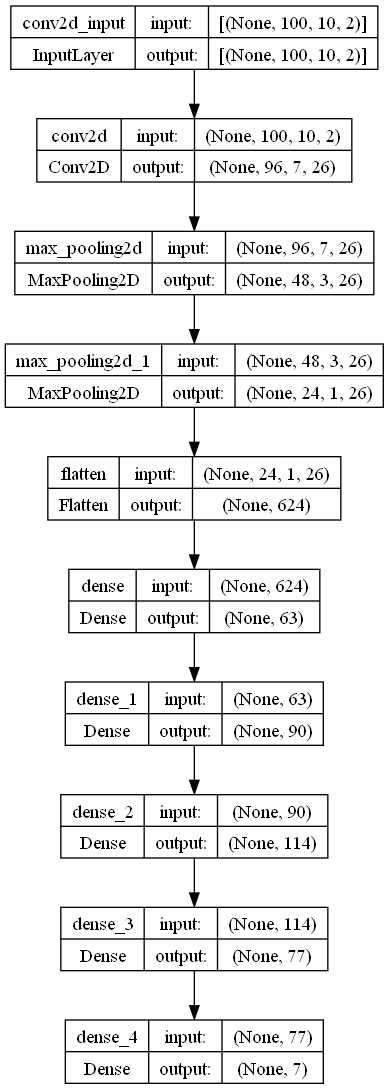

In [27]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [28]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [29]:
def total_mae_loss(y_true, y_pred):
    total_loss = 0
    num_parameters = 7
    for i in range(num_parameters):
        total_loss += tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])
    tf.print(y_true, summarize = -1)
    tf.print(y_pred, summarize = -1)
    return total_loss / num_parameters

In [30]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [31]:
model.compile(optimizer=optimizer,
              loss= 'mean_squared_error',
              metrics=metrics)

In [32]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

def adaptive_learning_rate(epoch):
    initial_lr = 0.001
    final_lr = 0.00001  # Updated final learning rate
    start_decay_epoch = 50
    end_decay_epoch = 1000
    
    if epoch < start_decay_epoch:
        return initial_lr
    elif epoch >= start_decay_epoch and epoch <= end_decay_epoch:
        lr_range = initial_lr - final_lr
        decay_epochs = end_decay_epoch - start_decay_epoch
        decay_per_epoch = lr_range / decay_epochs
        return initial_lr - (epoch - start_decay_epoch) * decay_per_epoch
    else:
        return final_lr

In [33]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 100,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(adaptive_learning_rate)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/1000
70/70 [==============================] - 1s 11ms/step - loss: 7.3416 - a_1: 2.4581 - a_2: 2.4818 - b_1: 2.3418 - b_2: 2.2803 - d_1: 1.5776 - d_2: 1.6023 - n: 1.2467 - mean_metric: 0.4354 - val_loss: 6.1281 - val_a_1: 2.4122 - val_a_2: 2.4112 - val_b_1: 1.9455 - val_b_2: 1.8818 - val_d_1: 1.2272 - val_d_2: 1.2486 - val_n: 1.2034 - val_mean_metric: 0.3819 - lr: 0.0010
Epoch 2/1000
70/70 [==============================] - 1s 8ms/step - loss: 5.8043 - a_1: 2.3793 - a_2: 2.3887 - b_1: 1.8141 - b_2: 1.7313 - d_1: 1.1310 - d_2: 1.0922 - n: 1.2257 - mean_metric: 0.3659 - val_loss: 5.3479 - val_a_1: 2.3487 - val_a_2: 2.3680 - val_b_1: 1.5700 - val_b_2: 1.5532 - val_d_1: 0.9697 - val_d_2: 0.9639 - val_n: 1.1947 - val_mean_metric: 0.3397 - lr: 0.0010
Epoch 3/1000
70/70 [==============================] - 1s 8ms/step - loss: 5.2404 - a_1: 2.3296 - a_2: 2.3505 - b_1: 1.5742 - b_2: 1.4985 - d_1: 0.9309 - d_2: 0.8708 - n: 1.2180 - mean_metric: 0.3351 - val_loss: 5.1491 - val_a_1: 2.3312 -

70/70 [==============================] - 1s 7ms/step - loss: 3.0960 - a_1: 1.9074 - a_2: 1.8651 - b_1: 0.8520 - b_2: 0.9051 - d_1: 0.3654 - d_2: 0.3706 - n: 1.1436 - mean_metric: 0.2305 - val_loss: 3.2422 - val_a_1: 1.9836 - val_a_2: 1.9675 - val_b_1: 0.8449 - val_b_2: 0.9279 - val_d_1: 0.3483 - val_d_2: 0.4040 - val_n: 1.1528 - val_mean_metric: 0.2363 - lr: 0.0010
Epoch 44/1000
70/70 [==============================] - 1s 7ms/step - loss: 3.0779 - a_1: 1.8913 - a_2: 1.8663 - b_1: 0.8603 - b_2: 0.8916 - d_1: 0.3571 - d_2: 0.3617 - n: 1.1426 - mean_metric: 0.2292 - val_loss: 3.3137 - val_a_1: 1.9619 - val_a_2: 1.9568 - val_b_1: 0.9955 - val_b_2: 0.8847 - val_d_1: 0.3965 - val_d_2: 0.4542 - val_n: 1.1459 - val_mean_metric: 0.2414 - lr: 0.0010
Epoch 45/1000
70/70 [==============================] - 1s 7ms/step - loss: 3.0680 - a_1: 1.8869 - a_2: 1.8759 - b_1: 0.8797 - b_2: 0.8672 - d_1: 0.3526 - d_2: 0.3644 - n: 1.1411 - mean_metric: 0.2292 - val_loss: 3.2315 - val_a_1: 1.9758 - val_a_2: 1.

70/70 [==============================] - 1s 7ms/step - loss: 2.6044 - a_1: 1.7307 - a_2: 1.7407 - b_1: 0.7861 - b_2: 0.7892 - d_1: 0.3277 - d_2: 0.3457 - n: 1.1148 - mean_metric: 0.2126 - val_loss: 2.9307 - val_a_1: 1.8739 - val_a_2: 1.9176 - val_b_1: 0.8045 - val_b_2: 0.8781 - val_d_1: 0.3198 - val_d_2: 0.4394 - val_n: 1.1402 - val_mean_metric: 0.2284 - lr: 9.6457e-04
Epoch 86/1000
70/70 [==============================] - 1s 7ms/step - loss: 2.5933 - a_1: 1.7268 - a_2: 1.7349 - b_1: 0.7770 - b_2: 0.7926 - d_1: 0.3325 - d_2: 0.3494 - n: 1.1147 - mean_metric: 0.2124 - val_loss: 2.9029 - val_a_1: 1.8944 - val_a_2: 1.9214 - val_b_1: 0.7845 - val_b_2: 0.8410 - val_d_1: 0.3165 - val_d_2: 0.3901 - val_n: 1.1341 - val_mean_metric: 0.2256 - lr: 9.6353e-04
Epoch 87/1000
70/70 [==============================] - 1s 7ms/step - loss: 2.5673 - a_1: 1.7158 - a_2: 1.7252 - b_1: 0.7621 - b_2: 0.7904 - d_1: 0.3331 - d_2: 0.3501 - n: 1.1128 - mean_metric: 0.2112 - val_loss: 2.8891 - val_a_1: 1.8701 - val

70/70 [==============================] - 0s 7ms/step - loss: 2.3584 - a_1: 1.6389 - a_2: 1.6587 - b_1: 0.7533 - b_2: 0.7752 - d_1: 0.3134 - d_2: 0.3366 - n: 1.1033 - mean_metric: 0.2047 - val_loss: 2.8645 - val_a_1: 1.8636 - val_a_2: 1.8911 - val_b_1: 0.8145 - val_b_2: 0.9434 - val_d_1: 0.3105 - val_d_2: 0.3959 - val_n: 1.1377 - val_mean_metric: 0.2279 - lr: 9.2080e-04
Epoch 128/1000
70/70 [==============================] - 1s 7ms/step - loss: 2.3488 - a_1: 1.6376 - a_2: 1.6476 - b_1: 0.7551 - b_2: 0.7650 - d_1: 0.3134 - d_2: 0.3441 - n: 1.1025 - mean_metric: 0.2042 - val_loss: 2.8657 - val_a_1: 1.8533 - val_a_2: 1.8641 - val_b_1: 0.8664 - val_b_2: 0.9290 - val_d_1: 0.3190 - val_d_2: 0.4263 - val_n: 1.1362 - val_mean_metric: 0.2290 - lr: 9.1976e-04
Epoch 129/1000
70/70 [==============================] - 0s 7ms/step - loss: 2.3789 - a_1: 1.6723 - a_2: 1.6627 - b_1: 0.7565 - b_2: 0.7529 - d_1: 0.3294 - d_2: 0.3311 - n: 1.1052 - mean_metric: 0.2056 - val_loss: 2.9177 - val_a_1: 1.8616 - v

70/70 [==============================] - 1s 7ms/step - loss: 2.2214 - a_1: 1.5948 - a_2: 1.5828 - b_1: 0.7545 - b_2: 0.7456 - d_1: 0.3160 - d_2: 0.3347 - n: 1.0990 - mean_metric: 0.1999 - val_loss: 2.8343 - val_a_1: 1.8382 - val_a_2: 1.9006 - val_b_1: 0.8084 - val_b_2: 0.8842 - val_d_1: 0.3965 - val_d_2: 0.3810 - val_n: 1.1325 - val_mean_metric: 0.2274 - lr: 8.7703e-04
Epoch 170/1000
70/70 [==============================] - 1s 7ms/step - loss: 2.1858 - a_1: 1.5793 - a_2: 1.5734 - b_1: 0.7247 - b_2: 0.7377 - d_1: 0.3186 - d_2: 0.3339 - n: 1.0948 - mean_metric: 0.1979 - val_loss: 2.8223 - val_a_1: 1.8761 - val_a_2: 1.8785 - val_b_1: 0.8098 - val_b_2: 0.8294 - val_d_1: 0.3961 - val_d_2: 0.3482 - val_n: 1.1273 - val_mean_metric: 0.2251 - lr: 8.7599e-04
Epoch 171/1000
70/70 [==============================] - 1s 7ms/step - loss: 2.1826 - a_1: 1.5807 - a_2: 1.5682 - b_1: 0.7311 - b_2: 0.7392 - d_1: 0.3067 - d_2: 0.3313 - n: 1.0961 - mean_metric: 0.1976 - val_loss: 2.8067 - val_a_1: 1.8532 - v

70/70 [==============================] - 1s 7ms/step - loss: 2.0893 - a_1: 1.5084 - a_2: 1.5379 - b_1: 0.7395 - b_2: 0.7361 - d_1: 0.2985 - d_2: 0.3210 - n: 1.0914 - mean_metric: 0.1939 - val_loss: 2.7686 - val_a_1: 1.8340 - val_a_2: 1.8789 - val_b_1: 0.7915 - val_b_2: 0.8088 - val_d_1: 0.3863 - val_d_2: 0.3689 - val_n: 1.1298 - val_mean_metric: 0.2230 - lr: 8.3326e-04
Epoch 212/1000
70/70 [==============================] - 1s 7ms/step - loss: 2.0826 - a_1: 1.5123 - a_2: 1.5245 - b_1: 0.7321 - b_2: 0.7255 - d_1: 0.3132 - d_2: 0.3259 - n: 1.0892 - mean_metric: 0.1936 - val_loss: 2.8553 - val_a_1: 1.8812 - val_a_2: 1.8758 - val_b_1: 0.8121 - val_b_2: 0.8476 - val_d_1: 0.3488 - val_d_2: 0.3854 - val_n: 1.1362 - val_mean_metric: 0.2257 - lr: 8.3222e-04
Epoch 213/1000
70/70 [==============================] - 1s 7ms/step - loss: 2.0747 - a_1: 1.5123 - a_2: 1.5245 - b_1: 0.7135 - b_2: 0.7256 - d_1: 0.3025 - d_2: 0.3297 - n: 1.0922 - mean_metric: 0.1928 - val_loss: 2.7708 - val_a_1: 1.8435 - v

70/70 [==============================] - 1s 7ms/step - loss: 2.0299 - a_1: 1.4574 - a_2: 1.5186 - b_1: 0.7439 - b_2: 0.7295 - d_1: 0.2946 - d_2: 0.3317 - n: 1.0896 - mean_metric: 0.1917 - val_loss: 2.7741 - val_a_1: 1.8379 - val_a_2: 1.8619 - val_b_1: 0.8169 - val_b_2: 0.9084 - val_d_1: 0.3093 - val_d_2: 0.3614 - val_n: 1.1263 - val_mean_metric: 0.2237 - lr: 7.8949e-04
Epoch 254/1000
70/70 [==============================] - 1s 7ms/step - loss: 1.9925 - a_1: 1.4581 - a_2: 1.4844 - b_1: 0.7243 - b_2: 0.7153 - d_1: 0.2940 - d_2: 0.3313 - n: 1.0863 - mean_metric: 0.1895 - val_loss: 2.7696 - val_a_1: 1.8371 - val_a_2: 1.8867 - val_b_1: 0.7982 - val_b_2: 0.8869 - val_d_1: 0.3096 - val_d_2: 0.3574 - val_n: 1.1317 - val_mean_metric: 0.2233 - lr: 7.8845e-04
Epoch 255/1000
70/70 [==============================] - 1s 7ms/step - loss: 1.9971 - a_1: 1.4529 - a_2: 1.4904 - b_1: 0.7196 - b_2: 0.7226 - d_1: 0.2998 - d_2: 0.3342 - n: 1.0882 - mean_metric: 0.1900 - val_loss: 2.8415 - val_a_1: 1.8657 - v

70/70 [==============================] - 1s 7ms/step - loss: 1.9627 - a_1: 1.4154 - a_2: 1.4763 - b_1: 0.7455 - b_2: 0.7296 - d_1: 0.2962 - d_2: 0.3270 - n: 1.0880 - mean_metric: 0.1890 - val_loss: 2.8260 - val_a_1: 1.8564 - val_a_2: 1.8725 - val_b_1: 0.9486 - val_b_2: 0.8382 - val_d_1: 0.2976 - val_d_2: 0.3447 - val_n: 1.1304 - val_mean_metric: 0.2258 - lr: 7.4573e-04
Epoch 296/1000
70/70 [==============================] - 1s 7ms/step - loss: 1.9702 - a_1: 1.4290 - a_2: 1.4895 - b_1: 0.7290 - b_2: 0.7168 - d_1: 0.3066 - d_2: 0.3228 - n: 1.0870 - mean_metric: 0.1891 - val_loss: 2.8220 - val_a_1: 1.8840 - val_a_2: 1.8829 - val_b_1: 0.8335 - val_b_2: 0.8266 - val_d_1: 0.2970 - val_d_2: 0.3461 - val_n: 1.1264 - val_mean_metric: 0.2229 - lr: 7.4468e-04
Epoch 297/1000
70/70 [==============================] - 1s 7ms/step - loss: 1.9318 - a_1: 1.4165 - a_2: 1.4511 - b_1: 0.7174 - b_2: 0.7083 - d_1: 0.2929 - d_2: 0.3184 - n: 1.0844 - mean_metric: 0.1862 - val_loss: 2.7989 - val_a_1: 1.8594 - v

70/70 [==============================] - 1s 7ms/step - loss: 1.8877 - a_1: 1.3876 - a_2: 1.4203 - b_1: 0.7169 - b_2: 0.7237 - d_1: 0.2859 - d_2: 0.3112 - n: 1.0809 - mean_metric: 0.1843 - val_loss: 2.8751 - val_a_1: 1.8722 - val_a_2: 1.8985 - val_b_1: 0.9176 - val_b_2: 0.8196 - val_d_1: 0.2979 - val_d_2: 0.3506 - val_n: 1.1256 - val_mean_metric: 0.2256 - lr: 7.0196e-04
Epoch 338/1000
70/70 [==============================] - 1s 7ms/step - loss: 1.8882 - a_1: 1.3873 - a_2: 1.4239 - b_1: 0.7188 - b_2: 0.7134 - d_1: 0.2831 - d_2: 0.3179 - n: 1.0805 - mean_metric: 0.1843 - val_loss: 2.8338 - val_a_1: 1.8444 - val_a_2: 1.9150 - val_b_1: 0.8730 - val_b_2: 0.8131 - val_d_1: 0.2976 - val_d_2: 0.3550 - val_n: 1.1335 - val_mean_metric: 0.2240 - lr: 7.0092e-04
Epoch 339/1000
70/70 [==============================] - 1s 7ms/step - loss: 1.8911 - a_1: 1.3899 - a_2: 1.4280 - b_1: 0.7202 - b_2: 0.7121 - d_1: 0.2818 - d_2: 0.3163 - n: 1.0804 - mean_metric: 0.1844 - val_loss: 2.8497 - val_a_1: 1.8517 - v

# Analizamos accuracy y loss

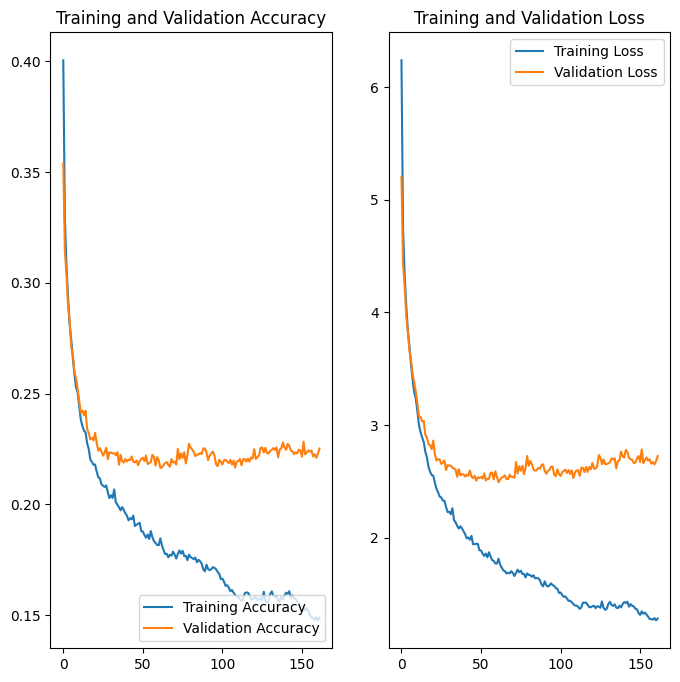

In [36]:
acc = history.history['mean_metric']
val_acc = history.history['val_mean_metric']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(val_epochs)
epochs_range = range(162)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

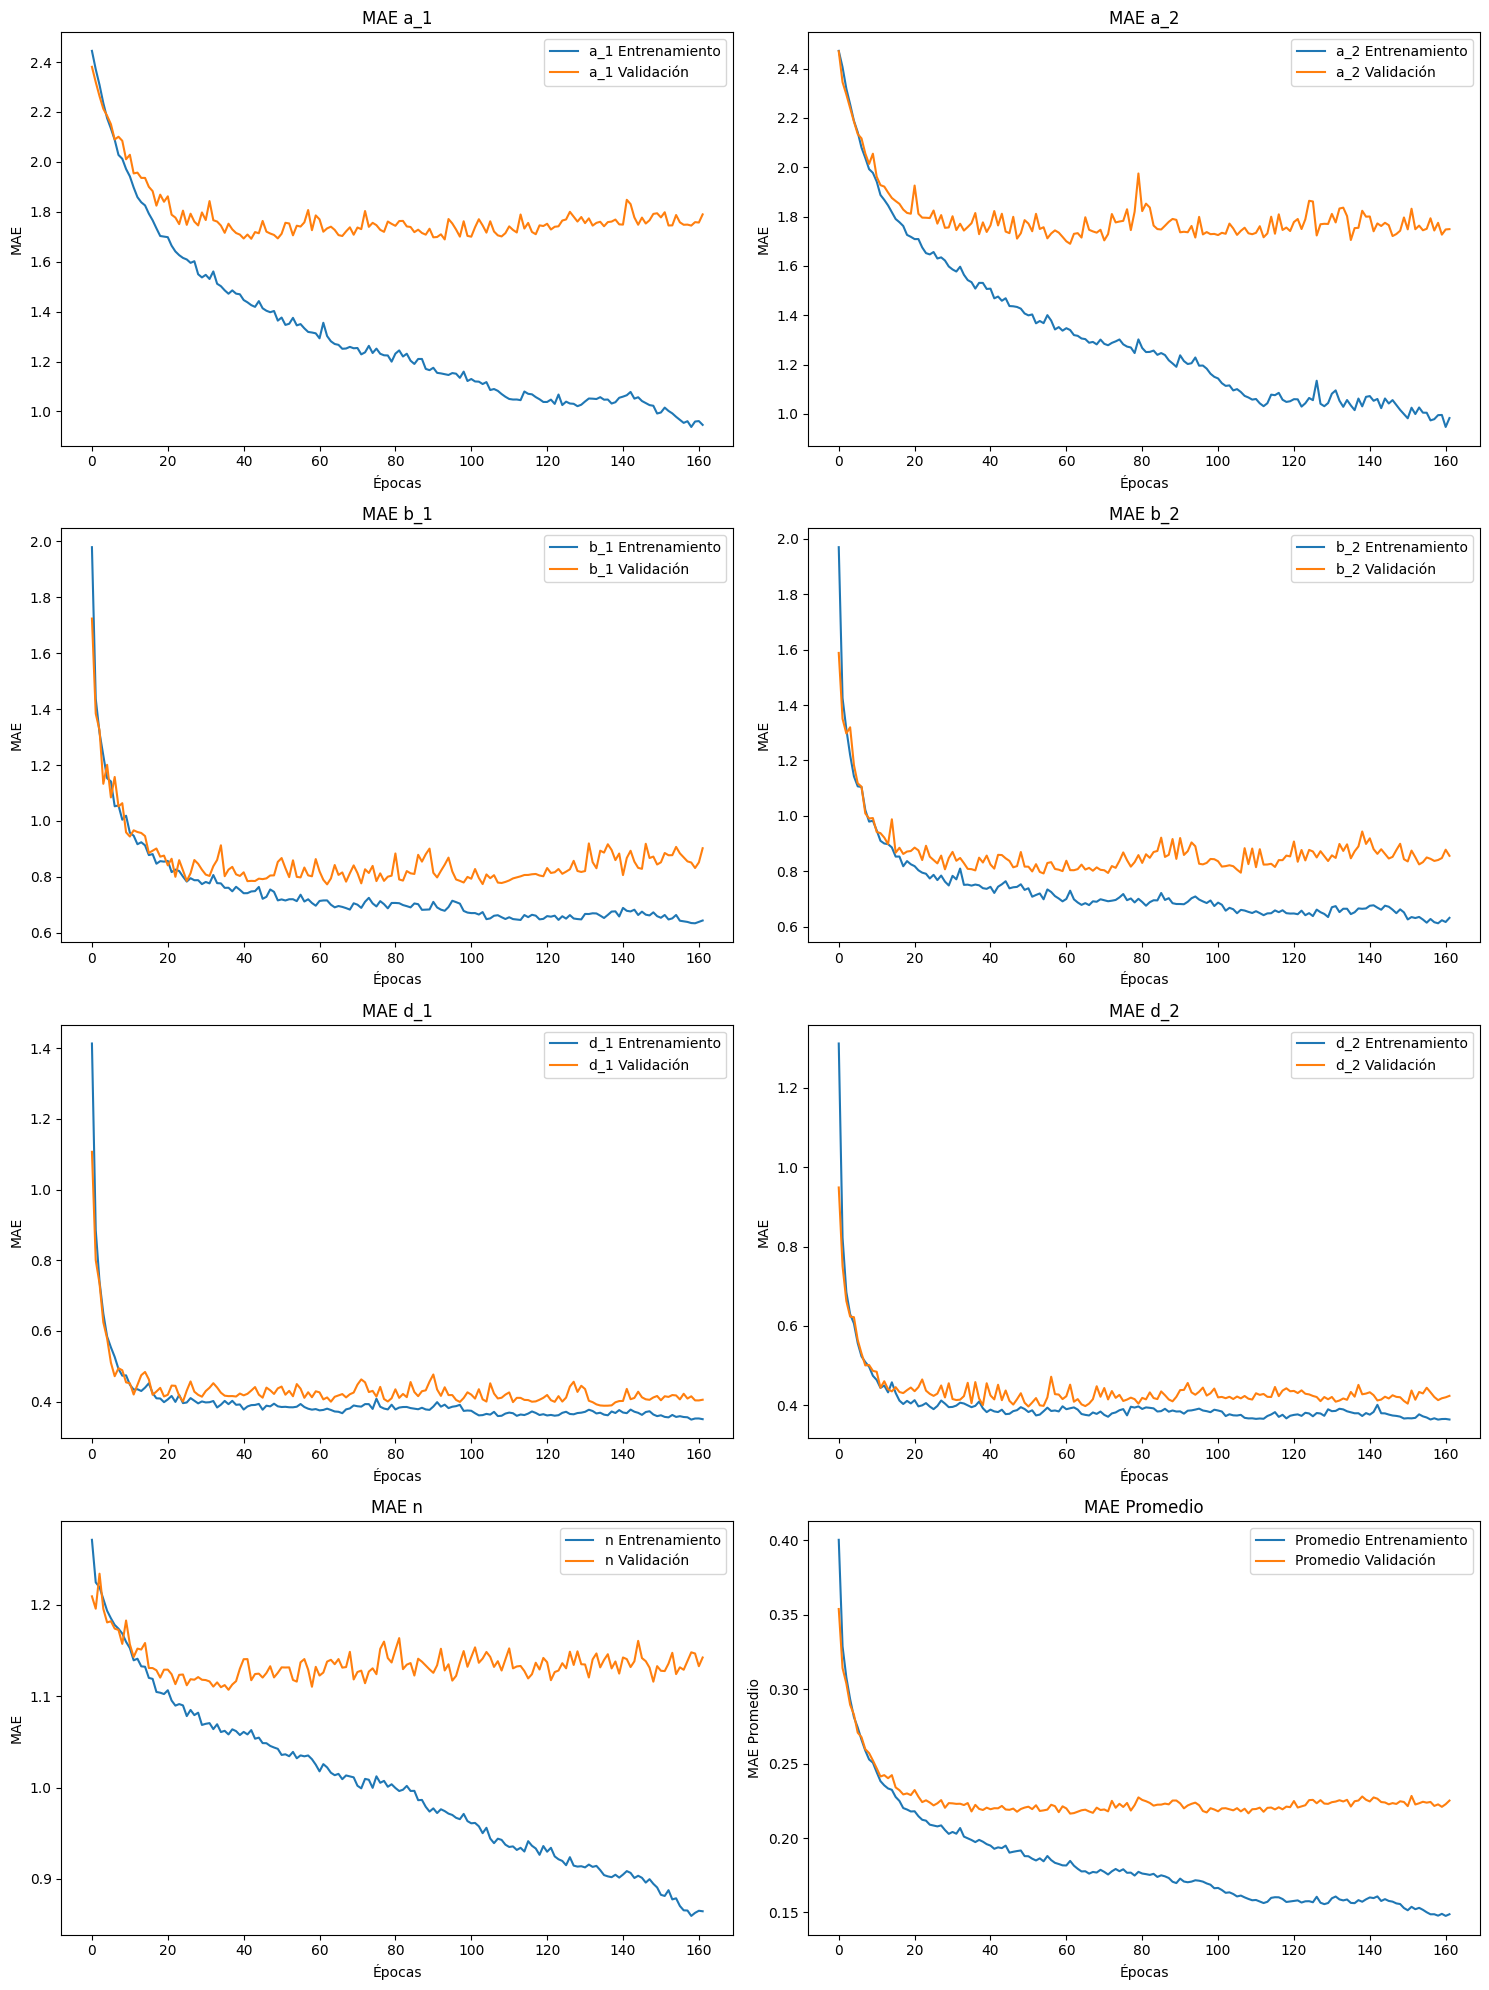

In [37]:
# Número de coeficientes más uno para la métrica adicional
n_coef = len(coeficientesnombres) + 1

# Número de filas y columnas para los subplots
n_rows = (n_coef + 1) // 2
n_cols = 2

# Crear una figura más grande para acomodar todos los subplots
plt.figure(figsize=(15, 5 * n_rows))

# Crear un subplot para cada coeficiente
for i, name in enumerate(coeficientesnombres):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(history.history[name ], label=name + ' Entrenamiento')
    plt.plot(history.history['val_' + name ], label=name + ' Validación')
    plt.title('MAE ' + name)
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()

# Agregar un subplot para la métrica prom_per
plt.subplot(n_rows, n_cols, n_coef)
plt.plot(history.history['mean_metric'], label='Promedio Entrenamiento')
plt.plot(history.history['val_mean_metric'], label='Promedio Validación')
plt.title('MAE Promedio')
plt.xlabel('Épocas')
plt.ylabel('MAE Promedio')
plt.legend()

# Ajustar el diseño para asegurarse de que todo encaje bien
plt.tight_layout()
plt.show()

# Evaluamos el modelo

In [38]:
test_loss, test_a1, test_a2, test_b1, test_b2, test_d1, test_d2, test_n, testprom_per = model.evaluate(
    varftest, coefvarftest)

32/32 [==============================] - 0s 4ms/step - loss: 2.5287 - a_1: 1.7342 - a_2: 1.7402 - b_1: 0.8060 - b_2: 0.7936 - d_1: 0.3983 - d_2: 0.4497 - n: 1.1409 - mean_metric: 0.2170


In [39]:
predictions = model.predict(varftest)

32/32 [==============================] - 0s 2ms/step


In [40]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calcula el MAE
mae = mean_absolute_error(coefvarftest, predictions)

# Calcula la desviación estándar del error
error = coefvarftest - predictions
std_dev = np.std(error)

# Calcula el error absoluto máximo
max_error = np.max(np.abs(error))

print(f"MAE: {mae}, Desviación estándar del error: {std_dev}, Error absoluto máximo: {max_error}")

MAE: 1.0023773386169756, Desviación estándar del error: 1.4409586464586228, Error absoluto máximo: 7.70646595954895


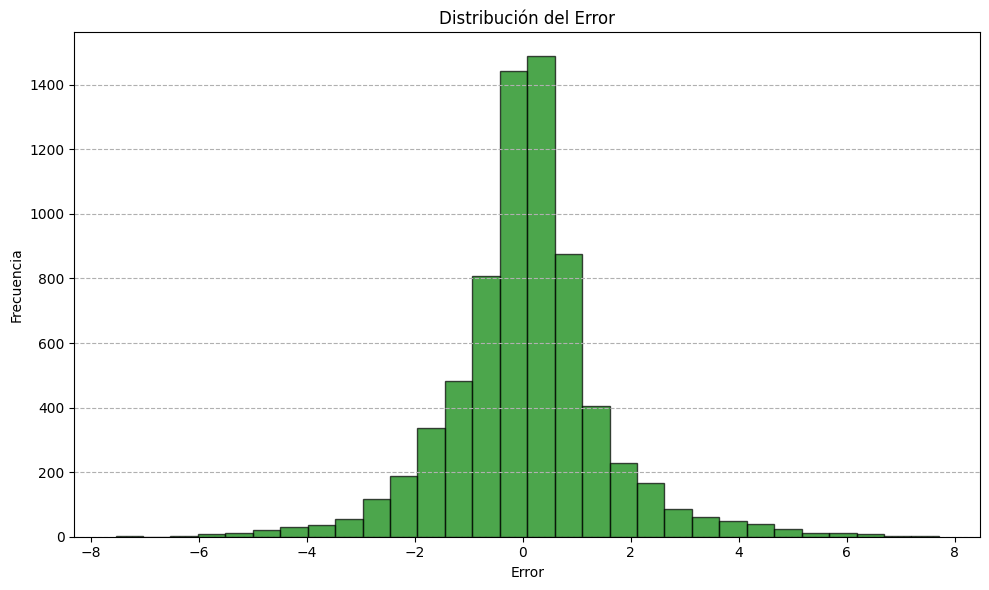

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(error.flatten(), bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error')  # Añade un título al gráfico
plt.xlabel('Error')  # Etiqueta el eje x
plt.ylabel('Frecuencia')  # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

In [42]:
# Calcula el error absoluto para cada dato
absolute_error = np.abs(coefvarftest - predictions)

# Calcula el error para cada dato
error = coefvarftest - predictions

# Calcula la suma de los valores reales para cada dato
sum_real_values = np.sum(coefvarftest, axis=-1)

# Divide el error absoluto por la suma de los valores reales para cada dato
relative_error_per_data = np.sum(absolute_error, axis=-1) / sum_real_values

# Calcula el MAE relativo como la media de los errores relativos
relative_mae = np.mean(relative_error_per_data)

# Divide el error por la suma de los valores reales para cada dato
relative_error_per_data_std_max = np.sum(error, axis=-1) / sum_real_values

# Calcula la desviación estándar del error relativo
relative_std_dev = np.std(relative_error_per_data_std_max)

# Calcula el error absoluto máximo relativo
relative_max_error = np.max(np.abs(relative_error_per_data_std_max))

print(f"MAE relativo: {relative_mae}")
print(f"Desviación estándar del error relativo: {relative_std_dev}")
print(f"Error absoluto máximo relativo: {relative_max_error}")


MAE relativo: 0.21790717131541842
Desviación estándar del error relativo: 0.12352131344120533
Error absoluto máximo relativo: 0.7179672550410032


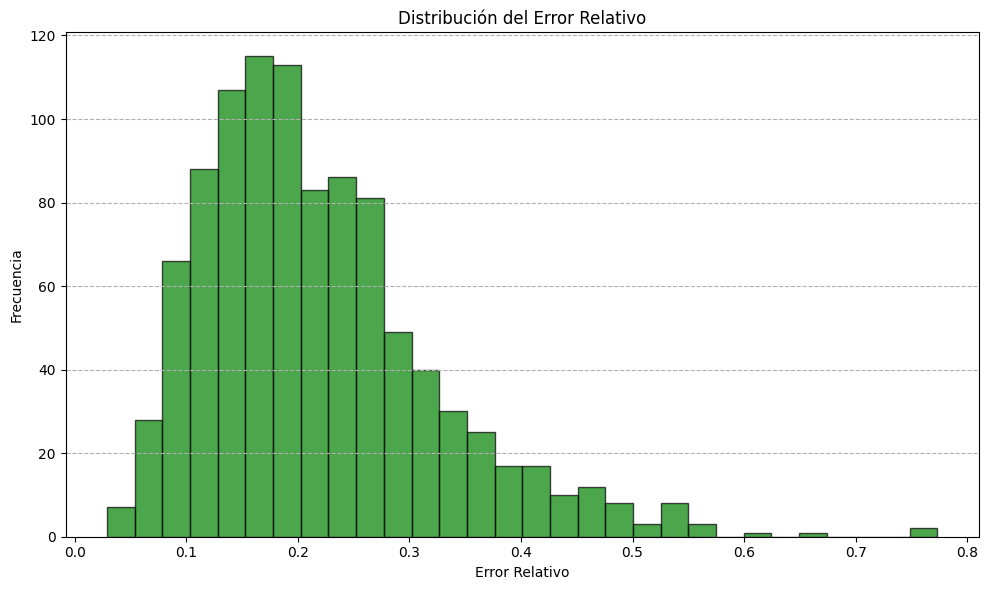

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(relative_error_per_data, bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error Relativo')  # Añade un título al gráfico
plt.xlabel('Error Relativo')  # Etiqueta el eje x
plt.ylabel('Frecuencia')      # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()


# Guardamos los datos de Accuracy y Loss

In [44]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales/History 50,100/historyconvtrayec100.csv', index=False)

# Guardamos el modelo

In [45]:
path_to_save = '../../../Modelos/Modelos 50,100/'

In [46]:
model.save(path_to_save + '/convolucionaltr100.h5')

# Importamos el modelo

In [1]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [2]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [3]:
import keras
import tensorflow as tf
# Creación de un diccionario con todas las métricas personalizadas
custom_objects = {'custom_activation':custom_activation,'mean_metric': mean_metric}
for i in range(7):
    custom_objects[coeficientesnombres[i]] = mse_component(i)
new_model = keras.models.load_model('../../../Modelos/Modelos 50,100/convolucionaltr100.h5', custom_objects=custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [50]:
import random
from scipy.integrate import solve_ivp
condini = []
varf = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b1

        return [dX_dt, dY_dt]

    # Declaramos el vector de tiempo
    t_span = [0, 5]
    times = np.linspace(t_span[0], t_span[1], 100)
    
    varfci2 = []
    for i_ci in range(0, 10):
        # Definimos las condiciones iniciales
        y0 = np.array([random.randint(0, 10), random.randint(0, 10)])
        condini.append(y0)
        # Resolvemos
        # Modificar manualmente el intervalo de tiempo
        sol = solve_ivp(f, t_span, y0, t_eval=times)
        tiempo = sol.t
        var1 = sol.y[0]
        var2 = sol.y[1]

        varfci = np.append([var1], [var2], axis=0)
        varfci2.append(varfci)

       

    varf= varfci2
    print('--------------------------------------------')
    print(coef1)
    print(np.shape(varf))
varf = np.array(varf)
coef = np.array(coef)

--------------------------------------------
[0, 5, 3, 1, 7, 9, 0]
(10, 2, 100)


In [51]:
varfnone = varf[None, :]
varfnone = np.transpose(varfnone, (0,3,1,2))

## Predecimos con los datos nuevos

In [52]:
new_predictions = new_model.predict(varfnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 47ms/step
[[2. 1. 2. 5. 7. 8. 2.]]


## Graficamos con los coeficientes reales

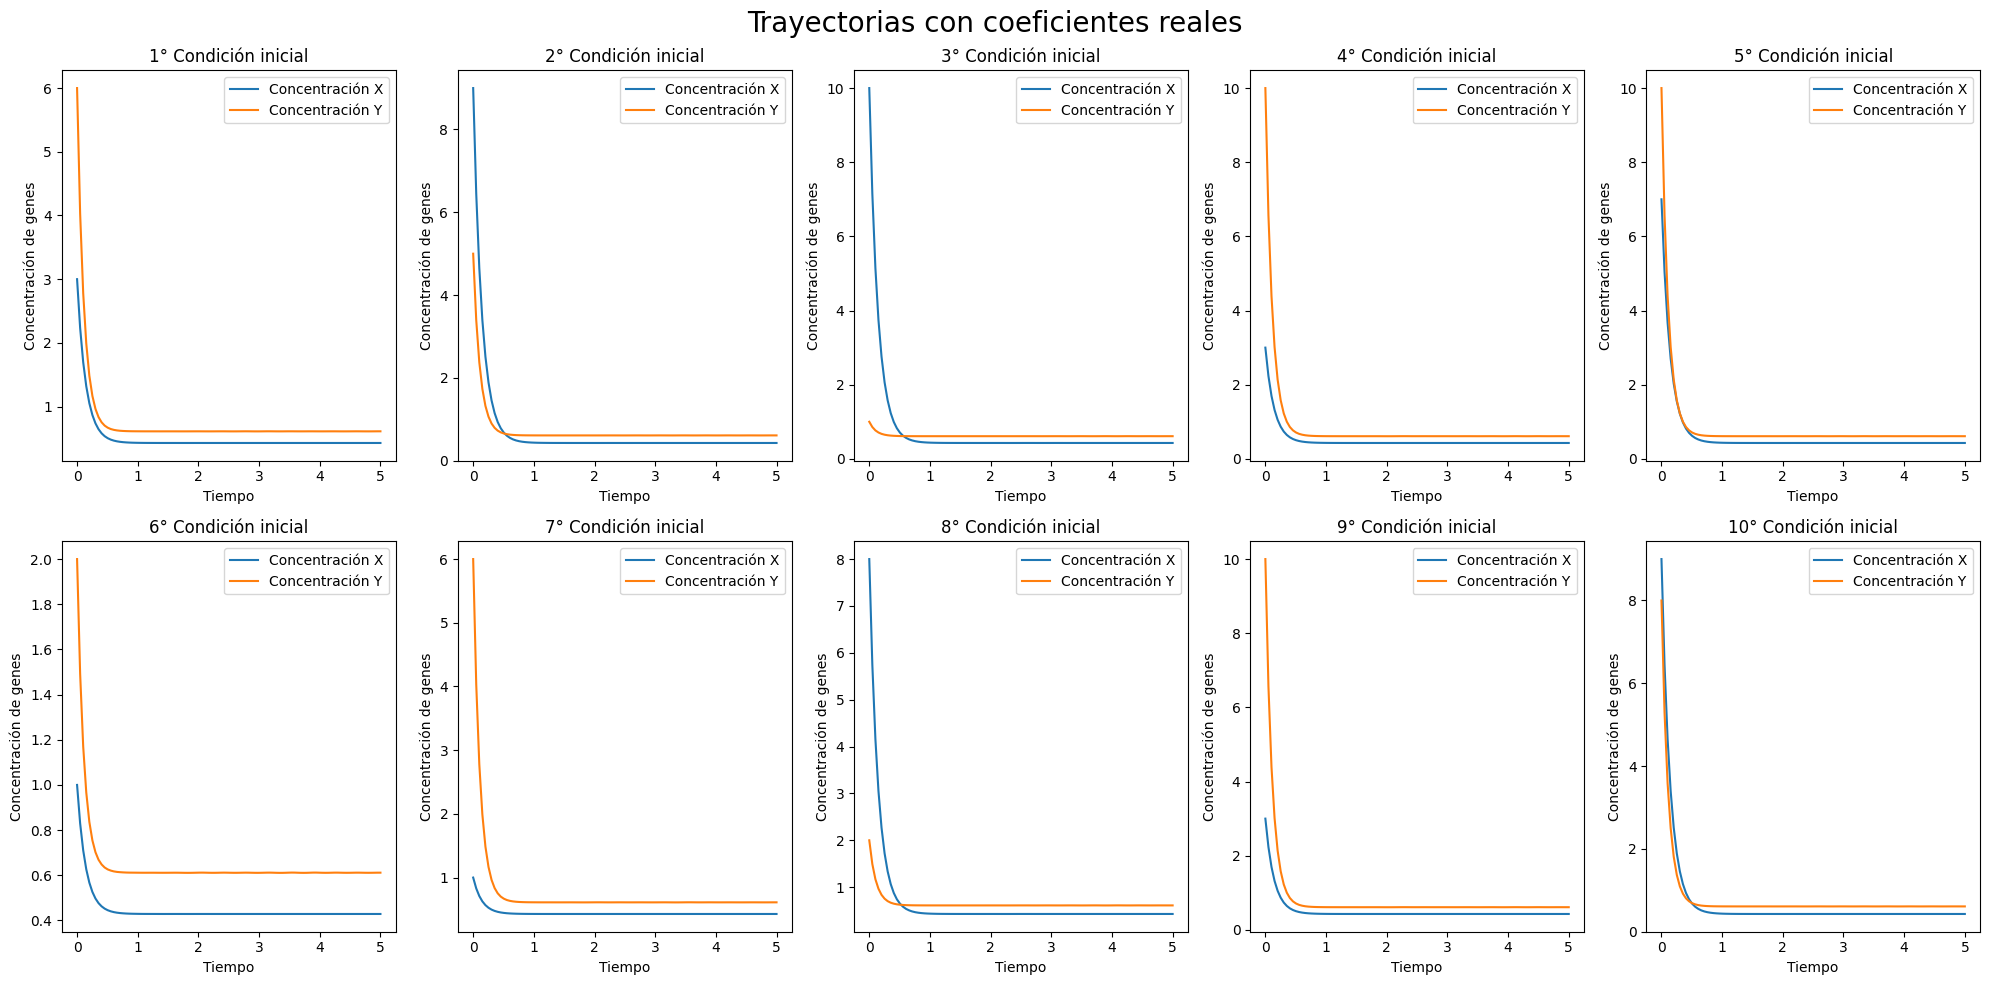

In [53]:
import matplotlib.pyplot as plt

t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes reales', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [54]:
np.shape(new_predictions)

(1, 7)

## Graficamos con los coeficientes predecidos

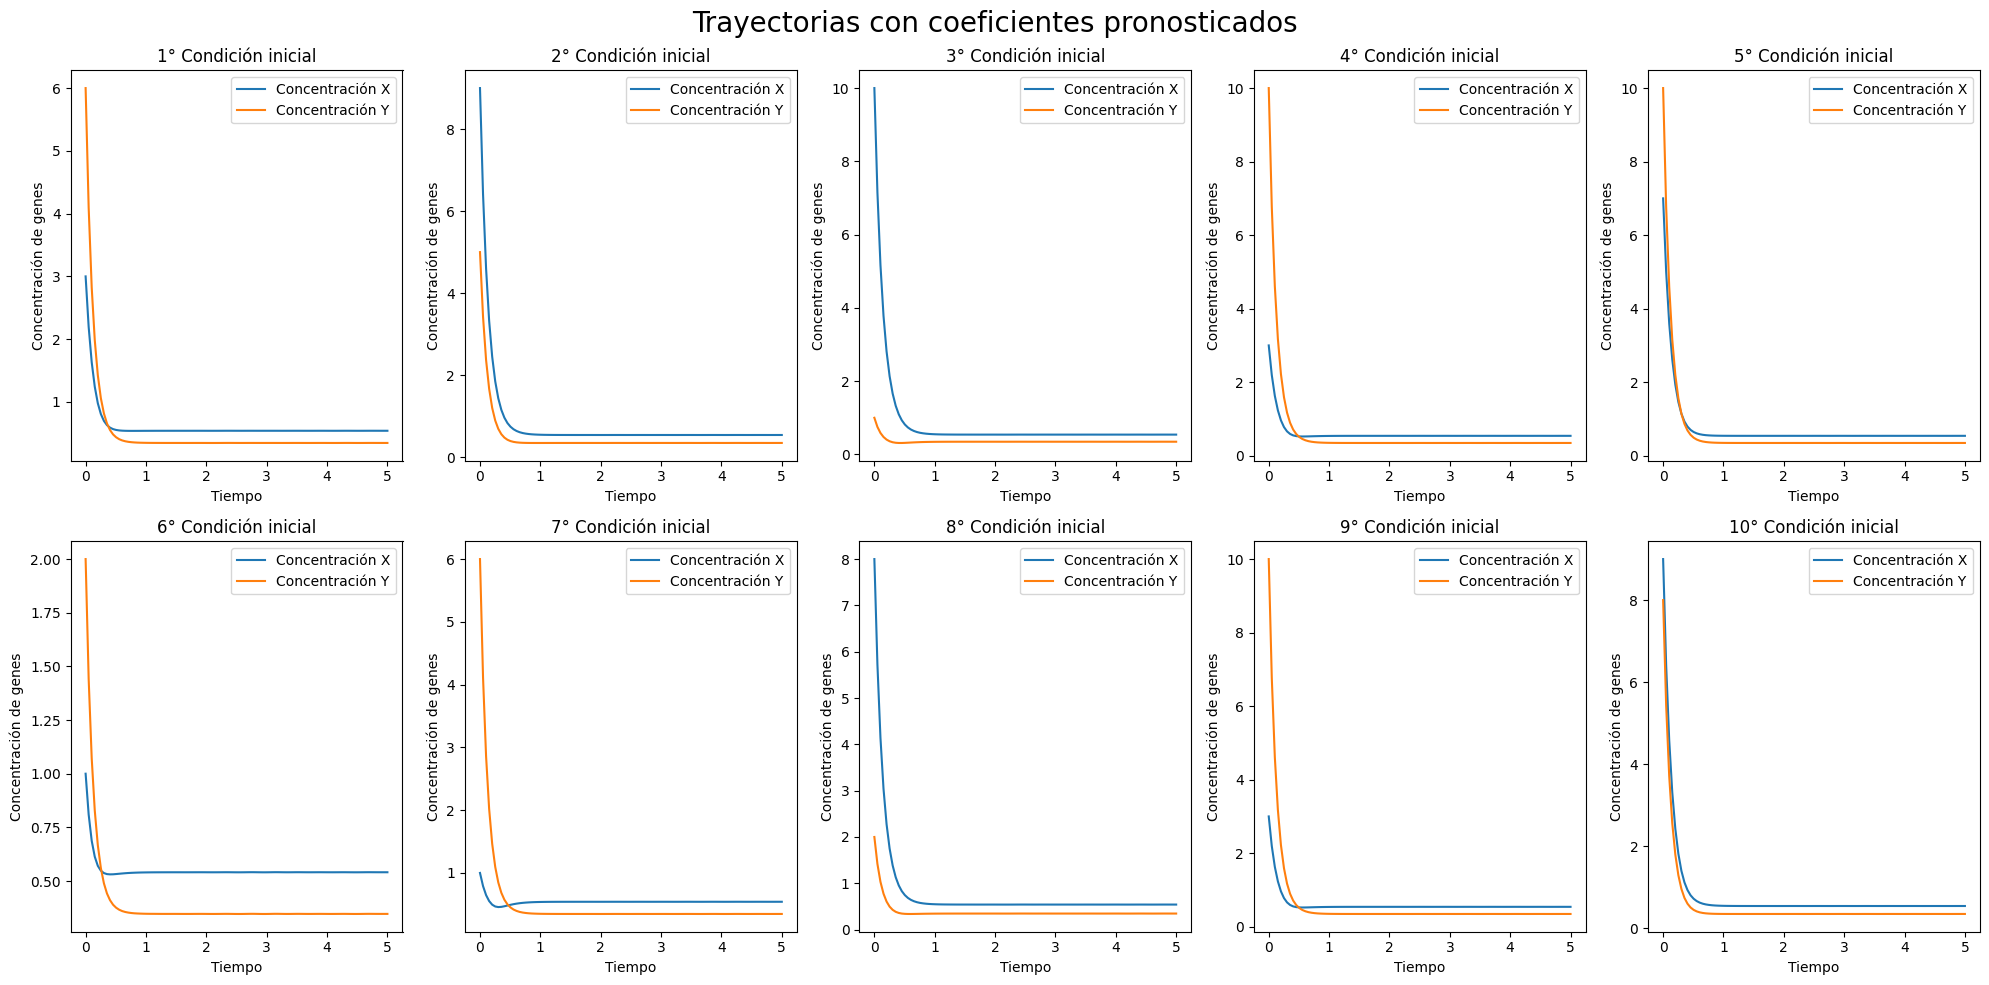

In [55]:
a1 = new_predictions[0,0]
a2 = new_predictions[0,1]
b1 = new_predictions[0,2]
b2 = new_predictions[0,3]
d1 = new_predictions[0,4]
d2 = new_predictions[0,5]
n = new_predictions[0,6]

varfpred = []

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1

    return [dX_dt, dY_dt]

# Declaramos el vector de tiempo
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
varfci2pred = []

for i_ci in range(0, 10):
# Definimos las condiciones iniciales
    y0 = condini[i_ci]
    # Resolvemos
    sol = solve_ivp(f, t_span, y0, t_eval=times)
    tiempo = sol.t
    var1pred = sol.y[0]
    var2pred = sol.y[1]
    varfcipred = np.append([var1pred], [var2pred], axis=0)
    varfci2pred.append(varfcipred)
    
varfpred= varfci2pred

fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos
# Graficamos
for i in range(10):
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes pronosticados', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  
plt.show()

## Graficamos ambos

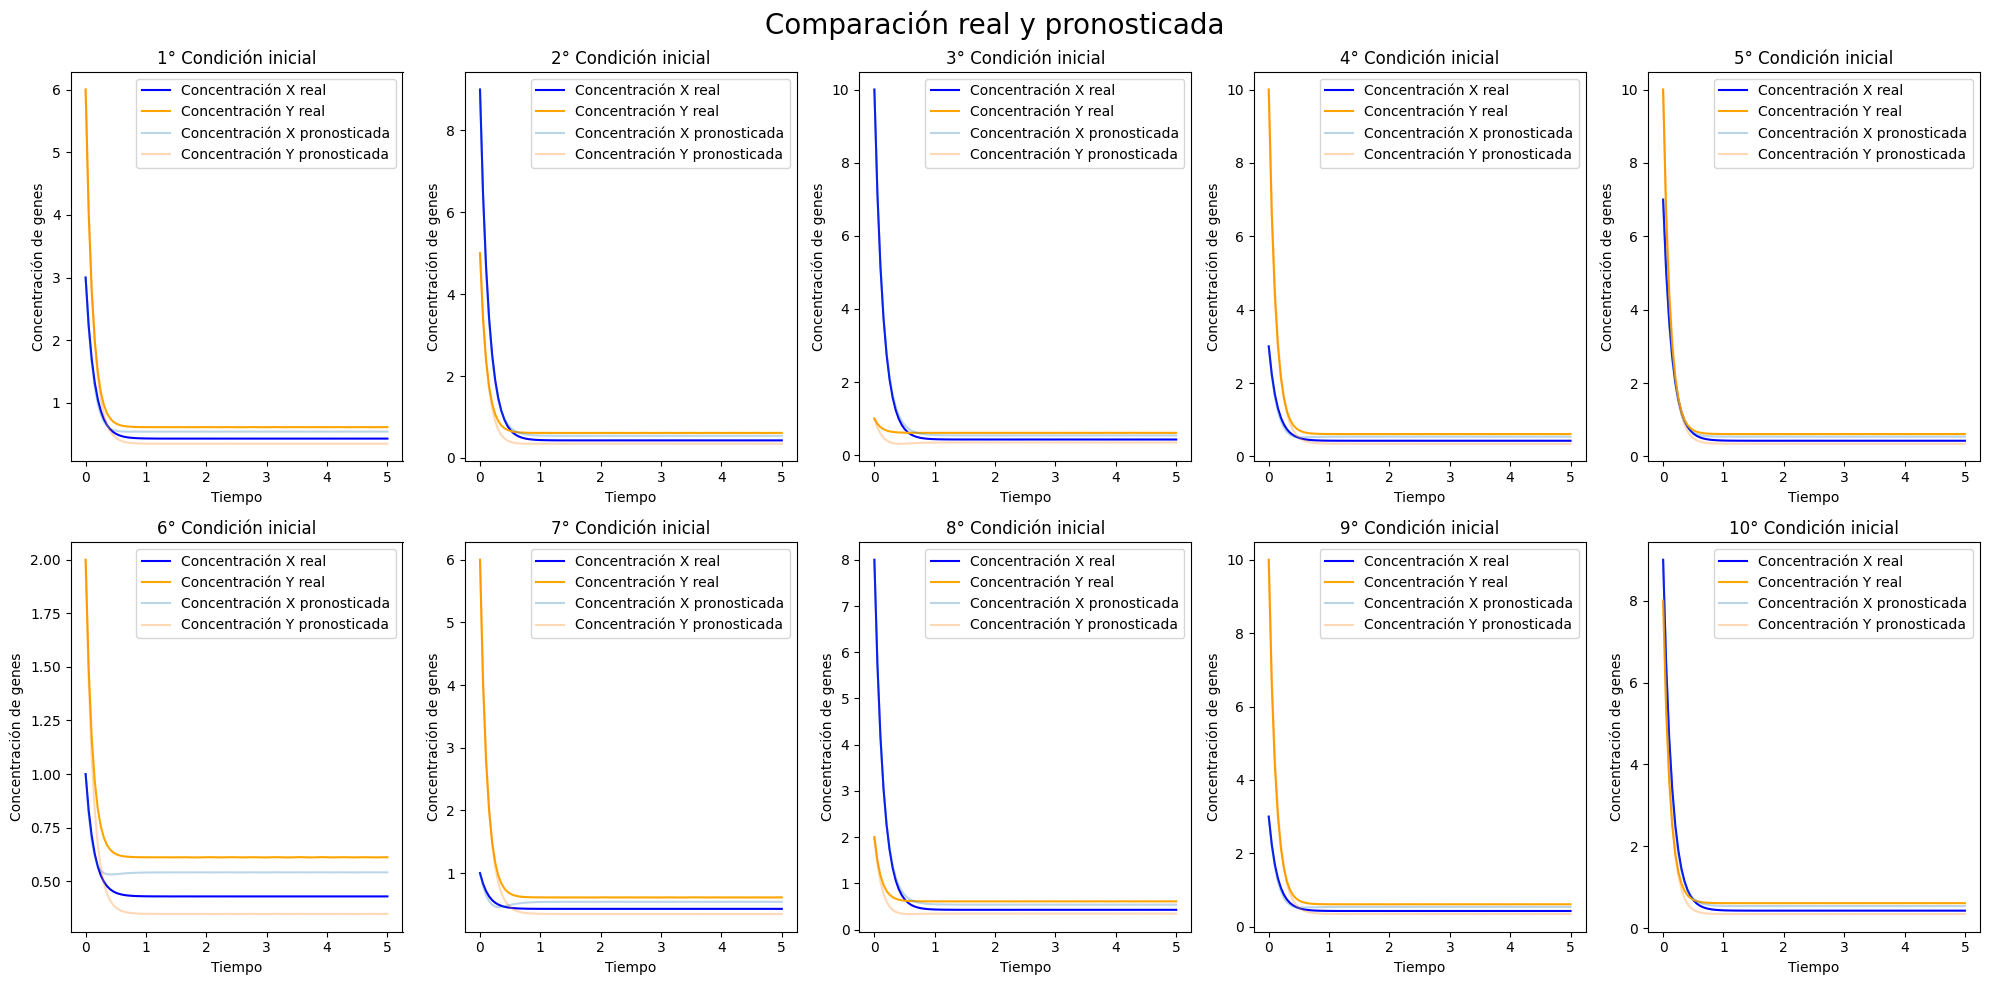

In [56]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    # varf
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X real", alpha=1, color = 'blue')
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y real", alpha=1, color = 'orange')

    # varfpred
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X pronosticada", alpha=0.3)
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y pronosticada", alpha=0.3)

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

## Graficamos la diferencia

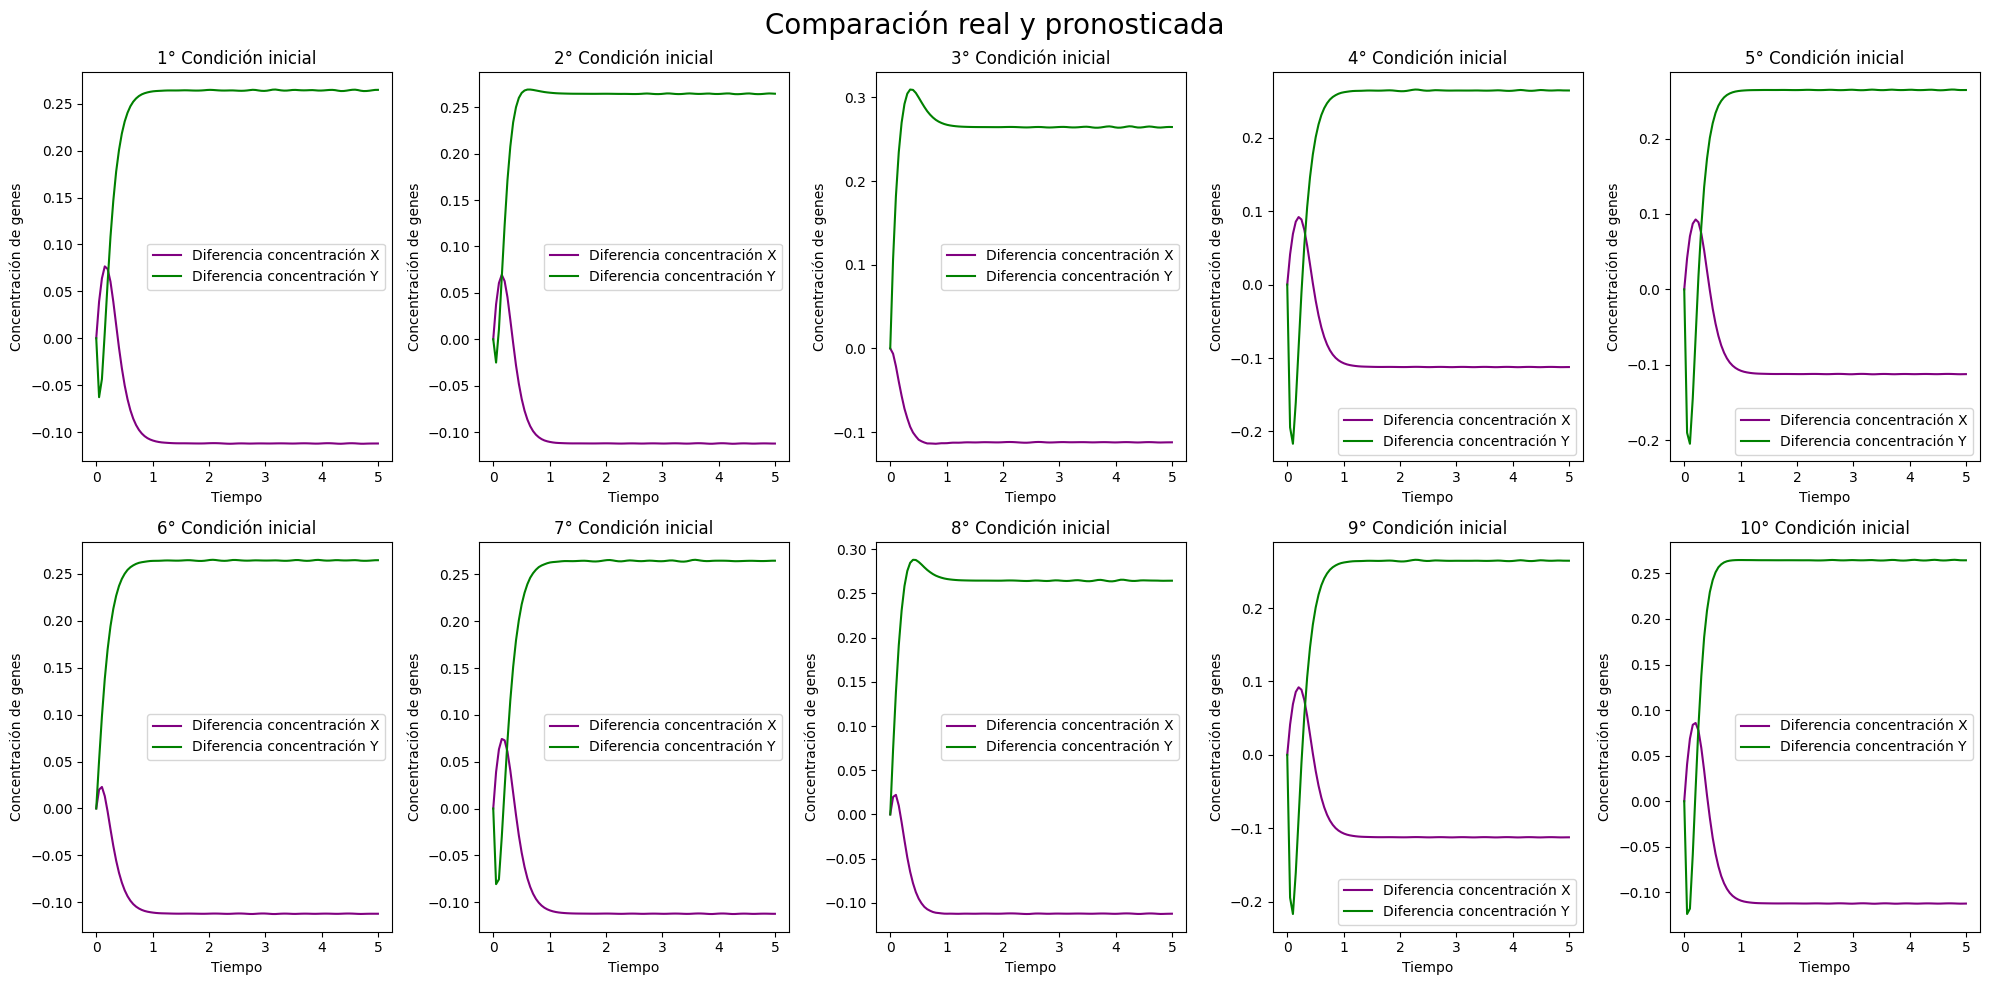

In [57]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

sum_errors_X = []
sum_errors_Y = []
for i in range(10):
    # Diferencia
    diff_X = np.array(varf)[i, 0, :] - np.array(varfpred)[i, 0, :]
    diff_Y = np.array(varf)[i, 1, :] - np.array(varfpred)[i, 1, :]
    axes[i].plot(times, diff_X, label=f"Diferencia concentración X", alpha=1, color = "purple")
    axes[i].plot(times, diff_Y, label=f"Diferencia concentración Y", alpha=1, color = "g")
    # Suma de los errores
    sum_errors_X.append(np.sum(np.abs(diff_X)))
    sum_errors_Y.append(np.sum(np.abs(diff_Y)))

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [90]:
print(np.sum(sum_errors_X)/2000)
print(np.sum(sum_errors_Y)/2000)

0.06470594643369906
0.03245070761557143


## Diferencias relativas

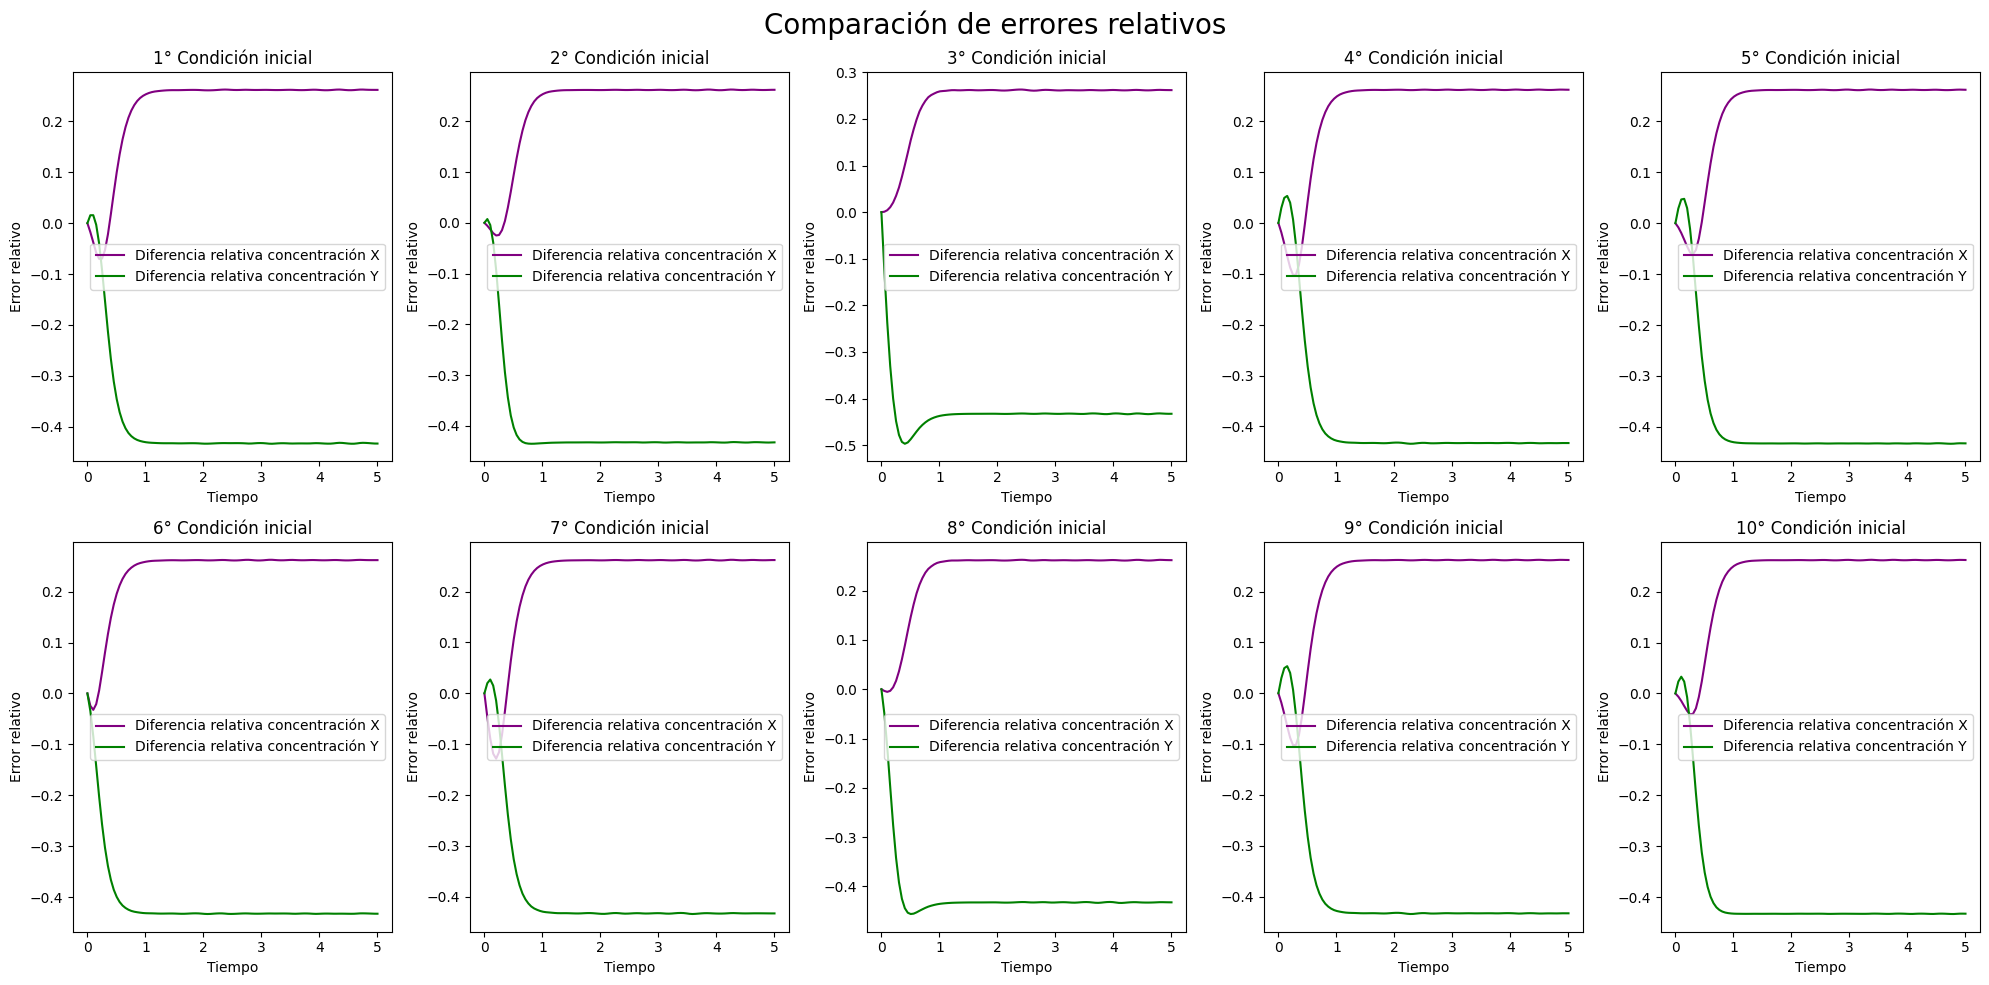

Suma mayor error relativo 66.30008242844642
Número de condición inicial 3


In [58]:
# Vamos a crear una lista para almacenar las sumas de los errores relativos para X y Y
sum_relative_errors_X = []
sum_relative_errors_Y = []

fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    # Diferencia relativa
    # Asegurándonos de evitar divisiones por cero
    real_X = np.array(varf)[i, 0, :]
    real_Y = np.array(varf)[i, 1, :]
    
    pred_X = np.array(varfpred)[i, 0, :]
    pred_Y = np.array(varfpred)[i, 1, :]
    
    relative_diff_X = np.where(real_X != 0, (pred_X - real_X) / real_X, 0)
    relative_diff_Y = np.where(real_Y != 0, (pred_Y - real_Y) / real_Y, 0)
    
    axes[i].plot(times, relative_diff_X, label=f"Diferencia relativa concentración X", alpha=1, color="purple")
    axes[i].plot(times, relative_diff_Y, label=f"Diferencia relativa concentración Y", alpha=1, color="g")
    
    # Suma de los errores relativos
    sum_relative_errors_X.append(np.sum(np.abs(relative_diff_X)))
    sum_relative_errors_Y.append(np.sum(np.abs(relative_diff_Y)))

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Error relativo')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación de errores relativos', fontsize=20)

plt.tight_layout()
plt.show()

# Podrías encontrar el máximo error relativo de la misma forma que el error absoluto
sum_total_relative_errors = [ex + ey for ex, ey in zip(sum_relative_errors_X, sum_relative_errors_Y)]
max_relative_error = max(sum_total_relative_errors)
index_max_relative_error = sum_total_relative_errors.index(max_relative_error) + 1  # Sumamos 1 porque las condiciones iniciales empiezan desde 1 en tu gráfico

print('Suma mayor error relativo', max_relative_error)
print('Número de condición inicial',index_max_relative_error)

## Error relativo global

In [59]:
# Vamos a crear listas para almacenar el máximo error relativo y el tiempo en que ocurre para cada condición inicial
max_relative_errors_X = []
max_relative_errors_Y = []
times_max_error_X = []
times_max_error_Y = []

for i in range(10):
    # Calcular la diferencia relativa como antes
    real_X = np.array(varf)[i, 0, :]
    real_Y = np.array(varf)[i, 1, :]
    
    pred_X = np.array(varfpred)[i, 0, :]
    pred_Y = np.array(varfpred)[i, 1, :]
    
    relative_diff_X = np.where(real_X != 0, np.abs((pred_X - real_X) / real_X), 0)
    relative_diff_Y = np.where(real_Y != 0, np.abs((pred_Y - real_Y) / real_Y), 0)
    
    # Encontrar el valor máximo y el tiempo en el que ocurre
    max_error_X = np.max(np.abs(relative_diff_X))
    max_error_Y = np.max(np.abs(relative_diff_Y))
    time_max_error_X = times[np.argmax(relative_diff_X)]
    time_max_error_Y = times[np.argmax(relative_diff_Y)]
    
    max_relative_errors_X.append(max_error_X)
    max_relative_errors_Y.append(max_error_Y)
    times_max_error_X.append(time_max_error_X)
    times_max_error_Y.append(time_max_error_Y)

# Ahora puedes encontrar el error relativo máximo global y la condición inicial y tiempo en el que ocurre
global_max_error_X = max(max_relative_errors_X)
global_max_error_Y = max(max_relative_errors_Y)

index_global_max_error_X = max_relative_errors_X.index(global_max_error_X) + 1  # Sumamos 1 porque las condiciones iniciales empiezan desde 1 en tu gráfico
index_global_max_error_Y = max_relative_errors_Y.index(global_max_error_Y) + 1

time_global_max_error_X = times_max_error_X[index_global_max_error_X - 1]  # Restamos 1 para ajustar el índice a la lista de Python
time_global_max_error_Y = times_max_error_Y[index_global_max_error_Y - 1]

print(f"El error relativo máximo para X es {global_max_error_X*100:.2f}%")
print("Ocurre en la condición inicial número:", index_global_max_error_X)
print("Ocurre en el tiempo:", time_global_max_error_X)

print(f"El error relativo máximo para Y es {global_max_error_Y*100:.2f}%")
print("Ocurre en la condición inicial número:", index_global_max_error_Y)
print("Ocurre en el tiempo:", time_global_max_error_Y)

El error relativo máximo para X es 26.31%
Ocurre en la condición inicial número: 3
Ocurre en el tiempo: 2.3737373737373737
El error relativo máximo para Y es 49.71%
Ocurre en la condición inicial número: 3
Ocurre en el tiempo: 0.40404040404040403


In [60]:

# Vamos a crear una lista para almacenar el máximo error relativo combinado (X + Y) y los tiempos en los que ocurre para cada condición inicial
max_combined_relative_errors = []
times_max_combined_error = []

for i in range(10):
    # Calcular la diferencia relativa como antes
    real_X = np.array(varf)[i, 0, :]
    real_Y = np.array(varf)[i, 1, :]
    
    pred_X = np.array(varfpred)[i, 0, :]
    pred_Y = np.array(varfpred)[i, 1, :]
    
    relative_diff_X = np.where(real_X != 0, np.abs((pred_X - real_X) / real_X), 0)
    relative_diff_Y = np.where(real_Y != 0, np.abs((pred_Y - real_Y) / real_Y), 0)
    
    # Calculamos la suma de los errores relativos en X y Y para cada punto en el tiempo
    combined_relative_error = relative_diff_X + relative_diff_Y
    
    # Encontramos el valor máximo y el tiempo en el que ocurre
    max_combined_error = np.max(combined_relative_error)
    time_max_combined_error = times[np.argmax(combined_relative_error)]
    
    max_combined_relative_errors.append(max_combined_error)
    times_max_combined_error.append(time_max_combined_error)

# Ahora puedes encontrar el error relativo combinado máximo global y la condición inicial y tiempo en que ocurre
global_max_combined_error = max(max_combined_relative_errors)
index_global_max_combined_error = max_combined_relative_errors.index(global_max_combined_error) + 1  # Sumamos 1 porque las condiciones iniciales empiezan desde 1 en tu gráfico
time_global_max_combined_error = times_max_combined_error[index_global_max_combined_error - 1]  # Restamos 1 para ajustar el índice a la lista de Python

print(f"El error relativo combinado máximo (X + Y) es {global_max_combined_error*100:.2f}%")
print("Ocurre en la condición inicial número:", index_global_max_combined_error)
print("Ocurre en el tiempo:", time_global_max_combined_error)

El error relativo combinado máximo (X + Y) es 69.65%
Ocurre en la condición inicial número: 3
Ocurre en el tiempo: 1.0101010101010102


## Hacemos esto n veces

In [4]:
# Importando las librerías necesarias
import numpy as np
import random
from scipy.integrate import solve_ivp


todas_diferencias_relativas_X = []
todas_diferencias_relativas_Y = []

# Inicializar las variables para almacenar los errores relativos máximos globales y los coeficientes correspondientes
max_global_error_X = 0
max_global_error_Y = 0
coef_max_error_X = None
coef_max_error_Y = None
coef_max_error_X_pred = None
coef_max_error_Y_pred = None
condinimaxX = None
condinimaxY = None

total_elementos_X = 0
elementos_condicion_X = 0

total_elementos_Y = 0
elementos_condicion_Y = 0

# Realizamos 10 iteraciones
for iteration in range(1000):
    condini = []
    varf = []
    coef = []
    # constantes
    a1 = random.randint(1, 10)
    a2 = random.randint(1, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(1, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b2

        return [dX_dt, dY_dt]

    # Declaramos el vector de tiempo
    t_span = [0, 5]
    times = np.linspace(t_span[0], t_span[1], 100)
    
    varfci2 = []
    for i_ci in range(0, 10):
        # Definimos las condiciones iniciales
        y0 = np.array([random.randint(0, 10), random.randint(0, 10)])
        condini.append(y0)
        # Resolvemos
        # Modificar manualmente el intervalo de tiempo
        sol = solve_ivp(f, t_span, y0, t_eval=times)
        # sol=solve_ivp(f, t_span, y0) #Dejar que la librería elija el mejor intervalo
        tiempo = sol.t
        var1 = sol.y[0]
        var2 = sol.y[1]

        varfci = np.append([var1], [var2], axis=0)
        varfci2.append(varfci)    

    varf= varfci2
    varf = np.array(varf)
    print(coef)
    
    varfnone = varf[None, :]
    varfnone = np.transpose(varfnone, (0,3,1,2))  
    new_predictions = new_model.predict(varfnone)
    new_predictions = np.round(new_predictions)
    print(new_predictions)  

    a1pred = new_predictions[0,0]
    a2pred = new_predictions[0,1]
    b1pred = new_predictions[0,2]
    b2pred = new_predictions[0,3]
    d1pred = new_predictions[0,4]
    d2pred = new_predictions[0,5]
    npred = new_predictions[0,6]
    
    # Verificar si a1pred, a2pred, o npred son iguales a cero
    if a1pred == 0 or a2pred == 0 or npred == 0:
        print("Uno de los coeficientes críticos es cero, saltando esta iteración.")
        continue  # Salta al inicio del bucle for para la próxima iteración

    varfpred = []

    def f_pred(t, y):
        X = y[0]
        Y = y[1]
        dX_dt = a1pred / (1 + Y ** npred) - d1pred * X + b1pred
        dY_dt = a2pred / (1 + X ** npred) - d2pred * Y + b2pred
        return [dX_dt, dY_dt]

    varfci2pred = []
    for i_ci in range(10):
        y0 = condini[i_ci]
        sol = solve_ivp(f_pred, t_span, y0, t_eval=times)
        var1pred = sol.y[0]
        var2pred = sol.y[1]
        varfcipred = np.append([var1pred], [var2pred], axis=0)
        varfci2pred.append(varfcipred)
    varfpred = varfci2pred

    # Inicializar listas para almacenar los errores relativos máximos y medios para todas las iteraciones
    todos_errores_maximos_X = []
    todos_errores_maximos_Y = []
    todos_errores_medios_X = []
    todos_errores_medios_Y = []
    
   # Calcular las diferencias relativas para cada conjunto de condiciones iniciales
    for i in range(10):  # Asumiendo que hay 10 condiciones iniciales
        real_X = np.array(varf)[i, 0, :]
        real_Y = np.array(varf)[i, 1, :]
        pred_X = np.array(varfpred)[i, 0, :]
        pred_Y = np.array(varfpred)[i, 1, :]
        
        # Calcular las diferencias relativas donde los valores reales no son cero
        diferencia_relativa_X = np.where(real_X != 0, np.abs((pred_X - real_X) / real_X), 0)
        diferencia_relativa_Y = np.where(real_Y != 0, np.abs((pred_Y - real_Y) / real_Y), 0)
        
        elementos_condicion_X += np.sum(diferencia_relativa_X >= 1)
        total_elementos_X += diferencia_relativa_X.size
        
        elementos_condicion_Y += np.sum(diferencia_relativa_Y >= 1)
        total_elementos_Y += diferencia_relativa_Y.size
        
        # Excluir los valores mayores a 100
        diferencia_relativa_X = np.extract(diferencia_relativa_X <= 1, diferencia_relativa_X)
        diferencia_relativa_Y = np.extract(diferencia_relativa_Y <= 1, diferencia_relativa_Y)
        
        # Agregar estas diferencias a la lista total
        todas_diferencias_relativas_X.extend(diferencia_relativa_X)
        todas_diferencias_relativas_Y.extend(diferencia_relativa_Y)
        
        # Calcular el error relativo máximo en esta iteración y condición inicial
        max_error_iter_X = np.max(diferencia_relativa_X)
        max_error_iter_Y = np.max(diferencia_relativa_Y)
        
        # Comprobar si estos son nuevos máximos globales
        if max_error_iter_X > max_global_error_X:
            max_global_error_X = max_error_iter_X
            coef_max_error_X = coef  # Coeficientes reales
            coef_max_error_X_pred = new_predictions  # Coeficientes predichos
            condinimaxX = condini
            
        if max_error_iter_Y > max_global_error_Y:
            max_global_error_Y = max_error_iter_Y
            coef_max_error_Y = coef  # Coeficientes reales
            coef_max_error_Y_pred = new_predictions  # Coeficientes predichos
            condinimaxY = condini


porcentaje_total_X = (elementos_condicion_X / total_elementos_X) * 100
porcentaje_total_Y = (elementos_condicion_Y / total_elementos_Y) * 100


# Convertir las listas a arreglos NumPy para facilitar los cálculos
todas_diferencias_relativas_X = np.array(todas_diferencias_relativas_X)
todas_diferencias_relativas_Y = np.array(todas_diferencias_relativas_Y)

# Calcular e imprimir los errores relativos medios y máximos globales
print(f"Error relativo medio global para X: {np.mean(todas_diferencias_relativas_X) * 100:.2f}%")
print(f"Error relativo medio global para Y: {np.mean(todas_diferencias_relativas_Y) * 100:.2f}%")
print(f"Error relativo máximo global para X: {np.max(todas_diferencias_relativas_X) * 100:.2f}%")
print(f"Error relativo máximo global para Y: {np.max(todas_diferencias_relativas_Y) * 100:.2f}%")

print(f"Coeficientes reales correspondientes para error máximo X: {coef_max_error_X}")
print(f"Coeficientes predichos correspondientes para error máximo X: {coef_max_error_X_pred}")


print(f"Coeficientes reales correspondientes para Y: {coef_max_error_Y}")
print(f"Coeficientes predichos correspondientes para Y: {coef_max_error_Y_pred}")

print(f"En promedio en X, el {porcentaje_total_X:.2f}% de los puntos tiene una diferencia relativa mayir o igual a 100% a lo largo de todas las condiciones iniciales.")
print(f"En promedio en Y , el {porcentaje_total_Y:.2f}% de los puntos tiene una diferencia relativa mayor o igual a 100% a lo largo de todas las condiciones iniciales.")


[[3, 2, 1, 3, 5, 5, 3]]
1/1 [==============================] - 0s 67ms/step
[[3. 2. 1. 3. 4. 5. 3.]]
[[7, 4, 10, 4, 9, 0, 2]]
1/1 [==============================] - 0s 11ms/step
[[6. 7. 9. 4. 9. 0. 4.]]
[[7, 9, 10, 7, 9, 6, 5]]
1/1 [==============================] - 0s 12ms/step
[[8. 8. 9. 6. 8. 6. 3.]]
[[3, 3, 6, 6, 4, 5, 1]]
1/1 [==============================] - 0s 11ms/step


C:\Users\rafae\AppData\Local\Temp\ipykernel_14212\522220833.py:131: RuntimeWarning: invalid value encountered in true_divide
  diferencia_relativa_X = np.where(real_X != 0, np.abs((pred_X - real_X) / real_X), 0)
C:\Users\rafae\AppData\Local\Temp\ipykernel_14212\522220833.py:132: RuntimeWarning: invalid value encountered in true_divide
  diferencia_relativa_Y = np.where(real_Y != 0, np.abs((pred_Y - real_Y) / real_Y), 0)


[[4. 5. 7. 6. 4. 5. 2.]]
[[4, 1, 1, 9, 3, 7, 1]]
1/1 [==============================] - 0s 11ms/step
[[2. 1. 1. 8. 2. 6. 3.]]
[[9, 4, 7, 7, 3, 6, 3]]
1/1 [==============================] - 0s 12ms/step
[[6. 6. 8. 7. 3. 5. 4.]]
[[3, 3, 1, 5, 9, 2, 3]]
1/1 [==============================] - 0s 11ms/step
[[8. 4. 1. 6. 9. 2. 3.]]
[[4, 5, 8, 1, 6, 1, 2]]
1/1 [==============================] - 0s 12ms/step
[[6. 3. 9. 2. 7. 1. 3.]]
[[5, 2, 2, 2, 3, 3, 2]]
1/1 [==============================] - 0s 11ms/step
[[6. 4. 2. 2. 3. 3. 3.]]
[[4, 5, 0, 0, 1, 0, 4]]
1/1 [==============================] - 0s 12ms/step
[[4. 7. 0. 2. 1. 0. 3.]]
[[3, 7, 9, 10, 7, 4, 3]]
1/1 [==============================] - 0s 13ms/step
[[ 4.  5.  9. 10.  8.  3.  3.]]
[[10, 3, 2, 1, 3, 0, 5]]
1/1 [==============================] - 0s 12ms/step
[[8. 5. 3. 1. 4. 0. 3.]]
[[9, 3, 10, 10, 2, 9, 1]]
1/1 [==============================] - 0s 12ms/step
[[6. 7. 9. 9. 2. 9. 3.]]
[[10, 8, 1, 9, 6, 1, 4]]
1/1 [=========================

1/1 [==============================] - 0s 12ms/step
[[9. 9. 4. 0. 8. 7. 5.]]
[[10, 3, 5, 9, 0, 10, 4]]
1/1 [==============================] - 0s 12ms/step
[[7. 5. 8. 8. 0. 9. 2.]]
[[3, 6, 6, 2, 2, 0, 5]]
1/1 [==============================] - 0s 11ms/step
[[6. 8. 9. 1. 3. 0. 3.]]
[[5, 7, 5, 6, 8, 6, 1]]
1/1 [==============================] - 0s 11ms/step
[[5. 3. 6. 8. 9. 5. 3.]]
[[4, 9, 9, 1, 1, 8, 2]]
1/1 [==============================] - 0s 10ms/step
[[4. 7. 9. 1. 1. 8. 3.]]
[[5, 3, 8, 4, 7, 8, 5]]
1/1 [==============================] - 0s 10ms/step
[[6. 4. 8. 4. 7. 7. 3.]]
[[6, 7, 6, 0, 9, 10, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 7.  5.  6.  0.  9. 10.  3.]]
[[8, 8, 7, 6, 6, 7, 4]]
1/1 [==============================] - 0s 11ms/step
[[9. 7. 7. 6. 6. 7. 4.]]
[[4, 10, 8, 0, 10, 4, 1]]
1/1 [==============================] - 0s 11ms/step
[[5. 3. 8. 4. 9. 4. 2.]]
[[9, 3, 4, 5, 0, 5, 5]]
1/1 [==============================] - 0s 12ms/step
[[7. 8. 4. 4. 0. 5. 3.]]
[[

1/1 [==============================] - 0s 11ms/step
[[7. 4. 8. 6. 2. 9. 2.]]
[[5, 1, 1, 4, 10, 2, 2]]
1/1 [==============================] - 0s 12ms/step
[[6. 2. 2. 3. 9. 2. 3.]]
[[3, 9, 10, 1, 5, 0, 4]]
1/1 [==============================] - 0s 11ms/step
[[3. 3. 9. 1. 4. 0. 3.]]
[[6, 3, 1, 5, 7, 10, 3]]
1/1 [==============================] - 0s 12ms/step
[[6. 1. 1. 5. 7. 9. 3.]]
[[10, 1, 10, 2, 5, 4, 5]]
1/1 [==============================] - 0s 11ms/step
[[9. 3. 9. 2. 5. 4. 4.]]
[[3, 10, 3, 8, 6, 3, 3]]
1/1 [==============================] - 0s 12ms/step
[[5. 9. 3. 9. 6. 2. 3.]]
[[4, 5, 6, 2, 7, 10, 4]]
1/1 [==============================] - 0s 11ms/step
[[3. 4. 5. 1. 6. 9. 3.]]
[[5, 3, 3, 1, 8, 7, 3]]
1/1 [==============================] - 0s 12ms/step
[[6. 3. 2. 1. 8. 7. 3.]]
[[10, 5, 0, 8, 5, 10, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 8.  2.  0.  9.  3. 10.  4.]]
[[6, 1, 9, 8, 3, 5, 5]]
1/1 [==============================] - 0s 11ms/step
[[5. 5. 8. 8. 2. 5. 2.]

1/1 [==============================] - 0s 12ms/step
[[6. 7. 1. 3. 4. 3. 4.]]
[[8, 2, 9, 9, 4, 0, 1]]
1/1 [==============================] - 0s 12ms/step
[[5. 8. 8. 8. 4. 0. 3.]]
[[7, 1, 3, 9, 4, 10, 3]]
1/1 [==============================] - 0s 12ms/step
[[7. 1. 2. 9. 4. 9. 3.]]
[[5, 1, 7, 4, 1, 10, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 7.  8.  6.  2.  1. 10.  2.]]
[[1, 3, 7, 3, 4, 6, 3]]
1/1 [==============================] - 0s 11ms/step
[[4. 4. 4. 2. 4. 5. 3.]]
[[8, 4, 10, 5, 3, 0, 5]]
1/1 [==============================] - 0s 11ms/step
[[8. 4. 8. 3. 3. 0. 3.]]
[[3, 9, 4, 5, 2, 3, 2]]
1/1 [==============================] - 0s 13ms/step
[[5. 8. 4. 4. 1. 2. 3.]]
[[6, 10, 9, 4, 1, 7, 4]]
1/1 [==============================] - 0s 12ms/step
[[6. 7. 9. 3. 1. 7. 2.]]
[[2, 3, 1, 0, 5, 1, 3]]
1/1 [==============================] - 0s 11ms/step
[[4. 4. 0. 1. 4. 1. 4.]]
[[6, 4, 1, 3, 7, 4, 2]]
1/1 [==============================] - 0s 12ms/step
[[5. 3. 1. 3. 8. 3. 4.]]
[[8

[[8. 8. 1. 2. 6. 9. 3.]]
[[3, 2, 2, 4, 2, 6, 5]]
1/1 [==============================] - 0s 11ms/step
[[4. 1. 2. 3. 2. 5. 2.]]
[[5, 4, 6, 2, 3, 10, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 6.  5.  6.  1.  3. 10.  2.]]
[[9, 7, 10, 4, 3, 9, 3]]
1/1 [==============================] - 0s 12ms/step
[[9. 7. 9. 2. 3. 9. 3.]]
[[7, 6, 9, 3, 1, 4, 3]]
1/1 [==============================] - 0s 10ms/step
[[4. 7. 8. 3. 0. 4. 4.]]
[[5, 7, 6, 10, 2, 7, 2]]
1/1 [==============================] - 0s 12ms/step
[[4. 5. 7. 9. 1. 6. 3.]]
[[10, 7, 1, 9, 3, 5, 4]]
1/1 [==============================] - 0s 10ms/step
[[7. 8. 1. 8. 3. 4. 3.]]
[[8, 10, 2, 1, 5, 8, 1]]
1/1 [==============================] - 0s 12ms/step
[[4. 7. 4. 3. 6. 8. 3.]]
[[10, 5, 2, 5, 8, 4, 3]]
1/1 [==============================] - 0s 11ms/step
[[9. 6. 2. 5. 8. 4. 3.]]
[[10, 5, 3, 9, 3, 8, 4]]
1/1 [==============================] - 0s 11ms/step
[[8. 4. 3. 8. 3. 8. 3.]]
[[10, 1, 4, 8, 10, 7, 3]]
1/1 [=====================

1/1 [==============================] - 0s 12ms/step
[[9. 5. 7. 9. 9. 5. 2.]]
[[4, 9, 2, 3, 6, 9, 5]]
1/1 [==============================] - 0s 13ms/step
[[5. 9. 2. 4. 5. 9. 5.]]
[[8, 3, 1, 3, 10, 4, 2]]
1/1 [==============================] - 0s 12ms/step
[[9. 3. 1. 3. 9. 3. 2.]]
[[8, 5, 8, 10, 9, 5, 5]]
1/1 [==============================] - 0s 13ms/step
[[7. 6. 8. 9. 9. 4. 3.]]
[[10, 1, 1, 6, 2, 2, 5]]
1/1 [==============================] - 0s 11ms/step
[[5. 2. 1. 8. 2. 3. 3.]]
[[2, 5, 6, 6, 10, 5, 3]]
1/1 [==============================] - 0s 12ms/step
[[ 3.  5.  7.  7. 10.  5.  3.]]
[[2, 7, 8, 8, 0, 1, 2]]
1/1 [==============================] - 0s 12ms/step
[[7. 7. 7. 7. 0. 1. 3.]]
[[10, 9, 4, 0, 9, 3, 1]]
1/1 [==============================] - 0s 11ms/step
[[9. 2. 7. 4. 9. 3. 3.]]
[[9, 8, 4, 0, 10, 5, 3]]
1/1 [==============================] - 0s 12ms/step
[[8. 8. 4. 1. 8. 4. 4.]]
[[4, 9, 6, 8, 2, 0, 1]]
1/1 [==============================] - 0s 11ms/step
[[7. 8. 7. 9. 2. 0. 3.]]
[

1/1 [==============================] - 0s 11ms/step
[[8. 6. 2. 8. 0. 6. 3.]]
[[10, 2, 0, 3, 0, 3, 2]]
1/1 [==============================] - 0s 11ms/step
[[8. 5. 1. 2. 0. 4. 3.]]
[[4, 3, 1, 4, 6, 5, 1]]
1/1 [==============================] - 0s 10ms/step
[[2. 1. 2. 6. 6. 6. 3.]]
[[2, 7, 1, 3, 4, 8, 3]]
1/1 [==============================] - 0s 11ms/step
[[2. 9. 1. 3. 3. 8. 3.]]
[[4, 8, 9, 1, 6, 7, 2]]
1/1 [==============================] - 0s 12ms/step
[[6. 6. 8. 2. 5. 6. 2.]]
[[6, 1, 1, 0, 6, 10, 4]]
1/1 [==============================] - 0s 10ms/step
[[4. 1. 3. 0. 6. 9. 4.]]
[[7, 10, 10, 1, 3, 10, 1]]
1/1 [==============================] - 0s 11ms/step
[[7. 7. 8. 2. 3. 9. 3.]]
[[2, 3, 1, 1, 4, 0, 2]]
1/1 [==============================] - 0s 10ms/step
[[5. 3. 1. 1. 3. 0. 2.]]
[[7, 4, 0, 1, 10, 3, 4]]
1/1 [==============================] - 0s 11ms/step
[[7. 5. 0. 2. 9. 3. 3.]]
[[4, 4, 6, 1, 10, 4, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 5.  4.  7.  1. 10.  3.  3.]]


1/1 [==============================] - 0s 11ms/step
[[9. 6. 2. 2. 9. 8. 4.]]
[[2, 1, 9, 8, 2, 3, 3]]
1/1 [==============================] - 0s 11ms/step
[[3. 3. 9. 8. 2. 2. 3.]]
[[9, 10, 0, 10, 4, 4, 2]]
1/1 [==============================] - 0s 11ms/step
[[8. 8. 1. 8. 4. 3. 3.]]
[[10, 4, 7, 9, 3, 9, 3]]
1/1 [==============================] - 0s 12ms/step
[[8. 3. 9. 9. 3. 9. 3.]]
[[1, 5, 2, 1, 4, 1, 5]]
1/1 [==============================] - 0s 12ms/step
[[3. 9. 2. 1. 4. 1. 3.]]
[[5, 6, 6, 0, 1, 1, 5]]
1/1 [==============================] - 0s 12ms/step
[[5. 5. 8. 0. 1. 2. 3.]]
[[2, 9, 1, 2, 5, 4, 4]]
1/1 [==============================] - 0s 11ms/step
[[6. 9. 1. 2. 4. 3. 4.]]
[[7, 8, 5, 0, 0, 9, 3]]
1/1 [==============================] - 0s 11ms/step
[[7. 5. 6. 0. 0. 9. 3.]]
[[7, 2, 4, 1, 4, 8, 5]]
1/1 [==============================] - 0s 12ms/step
[[7. 4. 3. 1. 4. 8. 3.]]
[[1, 5, 5, 5, 7, 5, 3]]
1/1 [==============================] - 0s 12ms/step
[[2. 6. 5. 5. 7. 5. 3.]]
[[9, 2, 10,

1/1 [==============================] - 0s 11ms/step
[[6. 9. 1. 6. 6. 1. 3.]]
[[7, 3, 10, 2, 8, 0, 4]]
1/1 [==============================] - 0s 12ms/step
[[3. 5. 7. 1. 6. 0. 3.]]
[[6, 3, 5, 10, 8, 4, 2]]
1/1 [==============================] - 0s 12ms/step
[[8. 3. 5. 9. 8. 4. 2.]]
[[8, 1, 10, 4, 3, 9, 5]]
1/1 [==============================] - 0s 10ms/step
[[7. 3. 9. 3. 2. 9. 3.]]
[[8, 6, 9, 3, 10, 8, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 9.  7.  9.  3. 10.  8.  3.]]
[[2, 5, 8, 0, 1, 2, 3]]
1/1 [==============================] - 0s 11ms/step
[[4. 3. 7. 0. 1. 2. 3.]]
[[8, 3, 0, 1, 3, 6, 3]]
1/1 [==============================] - 0s 11ms/step
[[8. 3. 1. 1. 3. 5. 2.]]
[[4, 6, 2, 10, 2, 5, 2]]
1/1 [==============================] - 0s 12ms/step
[[5. 8. 2. 9. 2. 4. 2.]]
[[9, 4, 4, 7, 1, 8, 3]]
1/1 [==============================] - 0s 12ms/step
[[7. 4. 3. 7. 1. 7. 3.]]
[[8, 8, 2, 7, 0, 10, 2]]
1/1 [==============================] - 0s 12ms/step
[[8. 5. 2. 9. 0. 9. 2.]]
[

1/1 [==============================] - 0s 11ms/step
[[1. 6. 7. 2. 2. 5. 2.]]
[[3, 7, 3, 6, 8, 4, 4]]
1/1 [==============================] - 0s 11ms/step
[[5. 8. 4. 8. 8. 4. 3.]]
[[1, 1, 1, 0, 4, 7, 5]]
1/1 [==============================] - 0s 12ms/step
[[1. 1. 1. 0. 3. 7. 2.]]
[[3, 1, 8, 1, 10, 1, 4]]
1/1 [==============================] - 0s 12ms/step
[[1. 2. 8. 1. 9. 1. 4.]]
[[5, 2, 3, 2, 2, 6, 1]]
1/1 [==============================] - 0s 12ms/step
[[6. 4. 4. 2. 2. 6. 2.]]
[[3, 5, 0, 10, 1, 0, 2]]
1/1 [==============================] - 0s 11ms/step
[[3. 7. 0. 5. 1. 1. 4.]]
[[8, 6, 4, 5, 2, 0, 4]]
1/1 [==============================] - 0s 12ms/step
[[5. 5. 5. 5. 1. 0. 4.]]
[[10, 10, 3, 9, 8, 7, 5]]
1/1 [==============================] - 0s 13ms/step
[[ 6. 10.  3.  9.  7.  6.  4.]]
[[10, 4, 7, 6, 0, 7, 2]]
1/1 [==============================] - 0s 12ms/step
[[6. 7. 9. 4. 0. 6. 3.]]
[[3, 1, 3, 3, 4, 9, 3]]
1/1 [==============================] - 0s 14ms/step
[[3. 3. 2. 1. 4. 8. 2.]]
[[

1/1 [==============================] - 0s 11ms/step
[[5. 2. 2. 8. 9. 7. 2.]]
[[10, 8, 5, 1, 1, 3, 2]]
1/1 [==============================] - 0s 12ms/step
[[8. 4. 2. 1. 1. 3. 3.]]
[[3, 10, 0, 2, 4, 0, 1]]
1/1 [==============================] - 0s 12ms/step
[[6. 7. 1. 4. 4. 0. 3.]]
[[10, 7, 1, 8, 7, 0, 1]]
1/1 [==============================] - 0s 11ms/step
[[7. 7. 1. 8. 6. 0. 3.]]
[[3, 9, 7, 0, 1, 6, 3]]
1/1 [==============================] - 0s 12ms/step
[[2. 6. 7. 0. 1. 6. 3.]]
[[5, 4, 3, 7, 0, 8, 5]]
1/1 [==============================] - 0s 11ms/step
[[6. 2. 4. 7. 0. 9. 4.]]
[[3, 4, 9, 6, 4, 0, 3]]
1/1 [==============================] - 0s 12ms/step
[[7. 4. 9. 7. 4. 0. 3.]]
[[3, 4, 8, 0, 1, 4, 5]]
1/1 [==============================] - 0s 13ms/step
[[4. 7. 6. 0. 1. 3. 4.]]
[[10, 2, 9, 7, 6, 3, 5]]
1/1 [==============================] - 0s 13ms/step
[[5. 2. 9. 8. 6. 3. 2.]]
[[4, 10, 3, 6, 4, 3, 5]]
1/1 [==============================] - 0s 13ms/step
[[6. 9. 5. 3. 4. 2. 4.]]
[[8, 6, 1

[[2. 2. 4. 6. 4. 9. 2.]]
[[7, 5, 10, 3, 9, 9, 4]]
1/1 [==============================] - 0s 12ms/step
[[9. 3. 9. 2. 9. 8. 3.]]
[[7, 9, 4, 0, 2, 5, 1]]
1/1 [==============================] - 0s 12ms/step
[[3. 6. 6. 1. 1. 5. 2.]]
[[8, 8, 2, 0, 10, 5, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 7.  4.  4.  2. 10.  4.  2.]]
[[3, 5, 3, 3, 1, 9, 5]]
1/1 [==============================] - 0s 16ms/step
[[3. 4. 3. 3. 1. 9. 3.]]
[[1, 8, 4, 5, 7, 2, 3]]
1/1 [==============================] - 0s 12ms/step
[[5. 9. 4. 5. 7. 2. 4.]]
[[1, 9, 4, 10, 4, 10, 2]]
1/1 [==============================] - 0s 12ms/step
[[3. 9. 5. 9. 4. 9. 3.]]
[[2, 6, 6, 0, 10, 0, 2]]
1/1 [==============================] - 0s 12ms/step
[[6. 6. 6. 1. 9. 0. 3.]]
[[5, 3, 4, 7, 2, 2, 4]]
1/1 [==============================] - 0s 12ms/step
[[3. 5. 5. 8. 2. 2. 3.]]
[[10, 7, 0, 0, 6, 3, 4]]
1/1 [==============================] - 0s 13ms/step
[[4. 3. 0. 1. 4. 2. 4.]]
[[1, 10, 1, 2, 7, 1, 5]]
1/1 [=======================

1/1 [==============================] - 0s 11ms/step
[[ 6.  8.  7. 10.  3.  9.  2.]]
[[10, 5, 8, 1, 0, 7, 1]]
1/1 [==============================] - 0s 11ms/step
[[5. 4. 9. 1. 0. 8. 3.]]
[[7, 1, 0, 3, 5, 10, 1]]
1/1 [==============================] - 0s 12ms/step
[[3. 2. 2. 1. 5. 9. 3.]]
[[1, 3, 9, 7, 10, 5, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 5.  5.  9.  6. 10.  4.  2.]]
[[7, 9, 0, 0, 6, 4, 2]]
1/1 [==============================] - 0s 11ms/step
[[7. 8. 1. 2. 5. 4. 3.]]
[[3, 3, 4, 10, 3, 7, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 3.  3.  4. 10.  3.  7.  3.]]
[[9, 3, 7, 0, 6, 10, 2]]
1/1 [==============================] - 0s 12ms/step
[[ 8.  3.  8.  1.  5. 10.  3.]]
[[4, 5, 5, 0, 8, 7, 4]]
1/1 [==============================] - 0s 11ms/step
[[3. 5. 5. 0. 8. 7. 3.]]
[[9, 8, 6, 7, 5, 2, 3]]
1/1 [==============================] - 0s 11ms/step
[[7. 6. 6. 8. 5. 1. 3.]]
[[1, 2, 8, 10, 1, 10, 5]]
1/1 [==============================] - 0s 11ms/step
[[5.

## Graficamos para los más grandes

### Para X

[[ 2  5  1  4 10  1  3]]
[9 4]
[9.         3.30735382 1.2599443  0.52017558 0.25293401 0.15619644
 0.12109011 0.10827708 0.10354356 0.10177837 0.10110102 0.10078069
 0.10066519 0.10056424 0.10051638 0.1005014  0.10042182 0.10040122
 0.10045225 0.10041083 0.1003189  0.10037266 0.10044055 0.1002918
 0.10027339 0.10043677 0.10036414 0.10022873 0.10036711 0.1004186
 0.10026503 0.10032589 0.10038166 0.10027269 0.10030704 0.10035044
 0.1002568  0.10027926 0.10035966 0.10025213 0.10022031 0.10035788
 0.10033401 0.10017944 0.10028784 0.10043366 0.10024778 0.10025206
 0.10040522 0.10033156]
[0 1]
[0.         0.09716128 0.11053368 0.1092024  0.10640637 0.10428801
 0.10293469 0.10220747 0.1016181  0.10132745 0.10104616 0.10090097
 0.10080298 0.10065442 0.10062484 0.10061676 0.10046324 0.10043467
 0.10055087 0.10047672 0.10036857 0.10044783 0.10042765 0.10033382
 0.10038764 0.10039173 0.10029079 0.10033333 0.10040792 0.10027176
 0.10025446 0.10040945 0.10034352 0.10021093 0.10034628 0.10041324
 0.

C:\Users\rafae\AppData\Local\Temp\ipykernel_17940\4209954309.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X real", alpha=1, color = 'blue')


ValueError: could not broadcast input array from shape (2,100) into shape (2,)

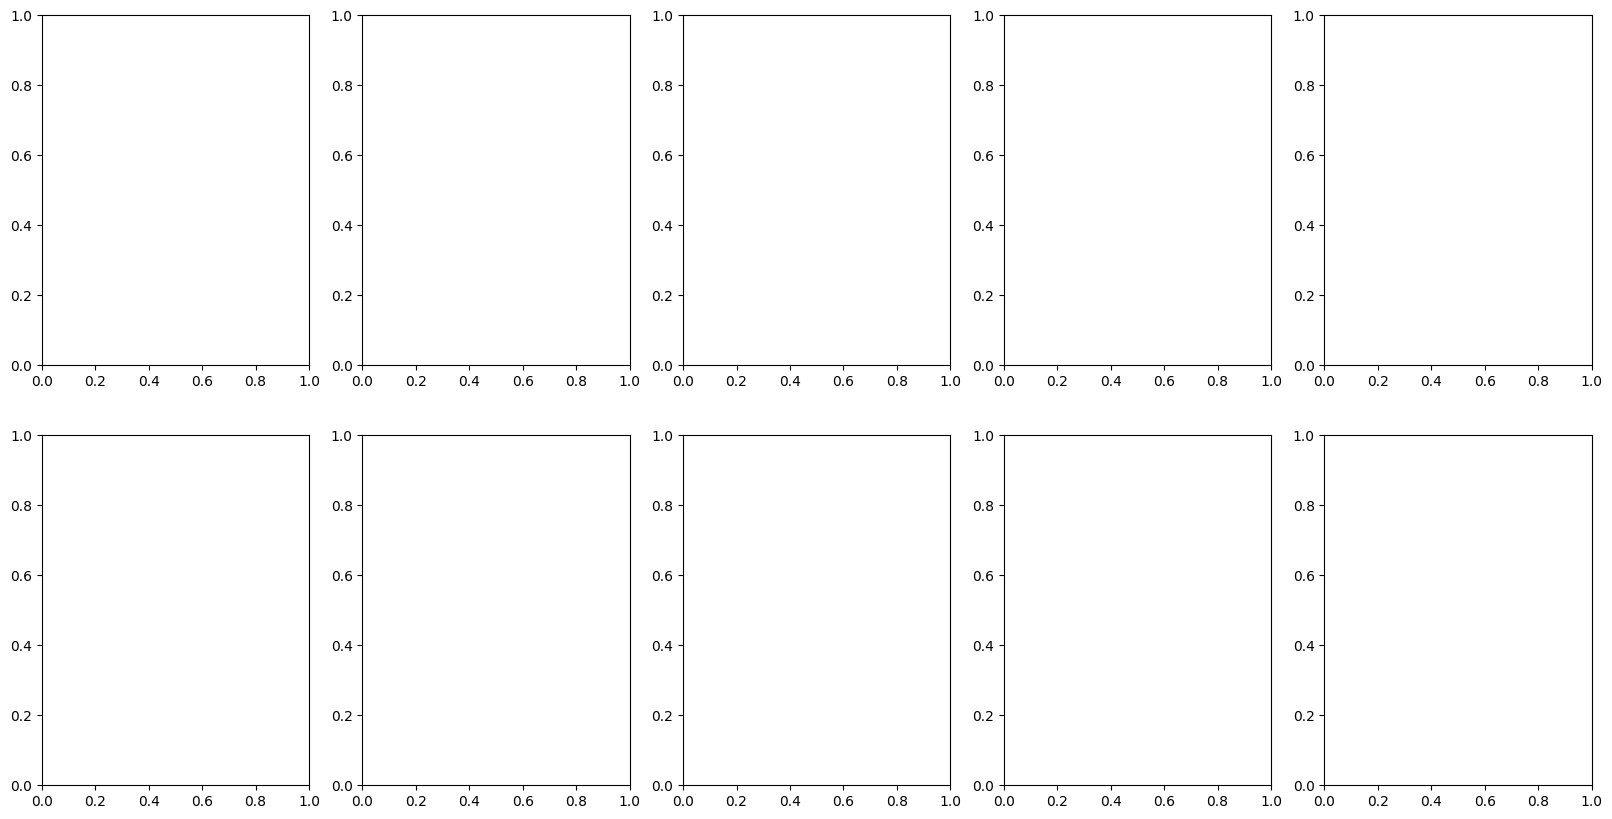

In [64]:
coef_max_error_X = np.array(coef_max_error_X)

a1 = coef_max_error_X[0,0]
a2 = coef_max_error_X[0,1]
b1 = coef_max_error_X[0,2]
b2 = coef_max_error_X[0,3]
d1 = coef_max_error_X[0,4]
d2 = coef_max_error_X[0,5]
n = coef_max_error_X[0,6]
print(coef_max_error_X)
def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b2

    return [dX_dt, dY_dt]

# Declaramos el vector de tiempo
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 50)
varfci2pred = []

for i_ci in range(0, 10):
# Definimos las condiciones iniciales
    y0 = condinimaxX[i_ci]
    print(y0)
    # Resolvemos
    sol = solve_ivp(f, t_span, y0, t_eval=times)
    tiempo = sol.t
    var1 = sol.y[0]
    print(var1)
    var2 = sol.y[1]
    varfci = np.append([var1], [var2], axis=0)
    varfci2.append(varfci)
    
varf= varfci2

a1pred = coef_max_error_X_pred[0,0]
a2pred = coef_max_error_X_pred[0,1]
b1pred = coef_max_error_X_pred[0,2]
b2pred = coef_max_error_X_pred[0,3]
d1pred = coef_max_error_X_pred[0,4]
d2pred = coef_max_error_X_pred[0,5]
npred = coef_max_error_X_pred[0,6]
print(coef_max_error_X_pred)

varfpred = []

def f2(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1pred/(1+Y**npred)-d1pred*X+b1pred
    dY_dt = a2pred/(1+X**npred)-d2pred*Y+b2pred

    return [dX_dt, dY_dt]

# Declaramos el vector de tiempo
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 50)
varfci2pred = []

for i_ci in range(0, 10):
# Definimos las condiciones iniciales
    y0 = condinimaxX[i_ci]
    # Resolvemos
    sol = solve_ivp(f2, t_span, y0, t_eval=times)
    tiempo = sol.t
    var1pred = sol.y[0]
    var2pred = sol.y[1]

    varfcipred = np.append([var1pred], [var2pred], axis=0)
    varfci2pred.append(varfcipred)
    
varfpred= varfci2pred

t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 50)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    # varf
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X real", alpha=1, color = 'blue')
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y real", alpha=1, color = 'orange')

    # varfpred
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X pronosticada", alpha=0.3)
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y pronosticada", alpha=0.3)

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()